### 库

In [1]:
import os, sys, json, re

In [2]:
import numpy as np
import pandas as pd
from time import time, sleep
from math import ceil

In [3]:
from driverOps import getDriver, switchLabel, waitTillOpen, newLabel
from cfg import home

In [4]:
from vVariableInspector import _getshapeof

In [5]:
from vUtil.vLog import print, VLog, VError
print.globals = globals()
from vUtil.vTqdm import tqdm, trange
from vUtil.debug import debug

In [6]:
from vUtil.vTime import getNow
from vUtil.vFile import fprint

In [7]:
from PIL import Image
import io

In [8]:
ourLog = VLog(sep=' ')
ourError = VError(sep=' ')

In [43]:
def loadJson (file, path='.'):
    with open(os.path.join(path,file)) as f:
        rst = json.load(f)
    return rst

In [32]:
def getFileName (name, href):
    href = href.replace('/', '丿').replace(':', '：').replace('?', '？')
    href = href.replace('*', '✲').replace('\\', '㇏').replace('"', "'")
    href = href.replace('<', '＜').replace('>', '＞').replace('|', '丨')
    return name + '(' + href + ').json'

In [60]:
def getNameAndHref (fileName):
    name, href = re.findall('(.+?)\((.+?)\).json', fileName)[0]
    href = href.replace('丿', '/').replace('：', ':').replace('？', '?')
    href = href.replace('✲', '*').replace('㇏', '\\').replace("'", '"')
    href = href.replace('＜', '<').replace('＞', '>').replace('丨', '|')
    return name, href

In [63]:
print(*getNameAndHref(x))

(2021-07-13 11:19:46) 傅伯杰 http://people.ucas.ac.cn/~0003332


In [57]:
x

'傅伯杰(http：丿丿people.ucas.ac.cn丿~0003332).json'

In [33]:
def getPathName (title):
    if title in {'两院院士', '杰出青年', '专任教师', '研究生导师'}: return title
    return '混合'

### 打开浏览器

In [64]:
dv = getDriver()

In [170]:
dv.get(home)

### 获取学者链接

In [56]:
attrs = ['fullname', 'title', 'href']

In [57]:
scholars = pd.DataFrame(columns=attrs)

In [58]:
homes = [
    'https://www.ucas.ac.cn/site/74',
    'https://www.ucas.ac.cn/site/232',
    'https://www.ucas.ac.cn/site/231',
    'https://www.ucas.ac.cn/site/77',
    'https://www.ucas.ac.cn/site/234',
]

In [59]:
pathRoot = "//div[@class='yp_pty']"
pathNum = './/p/span'
reNum = '共(\d+)人'
pathScholars = ".//a[@title]"

In [60]:
def getRootData (root):
    eleNum = root.find_element_by_xpath(pathNum)
    nScholars = int(re.findall(reNum, eleNum.text)[0])
    eleScholars = root.find_elements_by_xpath(pathScholars)
    if nScholars != len(eleScholars):
        print ('学者数量不一致', nScholars, len(eleScholars))
    with tqdm(eleScholars, leave=False) as tq:
        for x in tq:
            values = [x.get_attribute(y) for y in attrs]
            if values[0] != values[1]:
                print ('学者名不一致', attrs[0], values[0], attrs[1], values[1])
            scholars.loc[len(scholars)] = values

In [69]:
max([len(x) for x in scholars.title])

32

In [65]:
max([len(x) for x in scholars.href])

75

In [64]:
scholars

fullname title                                               href
0          艾国祥   艾国祥                     http://people.ucas.ac.cn/~aigx
1          安芷生   安芷生                     http://people.ucas.ac.cn/~anzs
2          白春礼   白春礼                  http://people.ucas.ac.cn/~0009458
3          白以龙   白以龙                  http://people.ucas.ac.cn/~0000728
4          包信和   包信和                    http://people.ucas.ac.cn/~xhbao
...        ...   ...                                                ...
20044      祝素娜   祝素娜  https://www.ucas.ac.cn/site/234?eduUrl=307bbac...
20045      邹定秀   邹定秀  https://www.ucas.ac.cn/site/234?eduUrl=ee8a8a3...
20046       邹铭    邹铭  https://www.ucas.ac.cn/site/234?eduUrl=be2a90c...
20047       邹婷    邹婷  https://www.ucas.ac.cn/site/234?eduUrl=929adbb...
20048      邹文秀   邹文秀  https://www.ucas.ac.cn/site/234?eduUrl=3a2b220...

[20049 rows x 3 columns]

In [63]:
for home in homes:
    print (home)
    dv.get(home)
    roots = dv.find_elements_by_xpath(pathRoot)
    with tqdm(roots) as tq:
        for x in tq:
            getRootData(x)
scholars.to_csv('scholarsOld.csv', index=False)

(2021-07-02 13:22:36) https://www.ucas.ac.cn/site/74



(2021-07-02 13:22:53) https://www.ucas.ac.cn/site/232



(2021-07-02 13:23:29) https://www.ucas.ac.cn/site/231



(2021-07-02 13:25:22) https://www.ucas.ac.cn/site/77


(2021-07-02 13:28:08) 学者数量不一致 2928 2000


(2021-07-02 13:30:45) 学者数量不一致 2076 2000


(2021-07-02 13:33:25) 学者数量不一致 2653 2000



(2021-07-02 13:34:42) https://www.ucas.ac.cn/site/234


### 忘加title，将无用的title替换为ucas分页用的title

In [120]:
scs = pd.read_csv('scholarsOld.csv')

In [122]:
scs['title'] = [''] * len(scs)

In [127]:
scs.loc[:363]['title']

0      两院院士
1      两院院士
2      两院院士
3      两院院士
4      两院院士
       ... 
359    两院院士
360    两院院士
361    两院院士
362    两院院士
363        
Name: title, Length: 364, dtype: object

In [143]:
scs[4352:]['title'] = '研究生导师'

<ipython-input-143-d29664e61484>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scs[4352:]['title'] = '研究生导师'


In [135]:
scs[360:365]

fullname title                                     href
360        庄文颖  两院院士  http://people.ucas.ac.cn/~zhuangwenying
361        邹才能  两院院士        http://people.ucas.ac.cn/~0039469
362        邹世昌  两院院士        http://people.ucas.ac.cn/~0003489
363  阿吉艾克拜尔·艾萨  杰出青年        http://people.ucas.ac.cn/~0001836
364        艾印双  杰出青年        http://people.ucas.ac.cn/~0000686

In [140]:
scs[1280:1286]

fullname title                                 href
1280      祝宁华  杰出青年    http://people.ucas.ac.cn/~0002639
1281      邹冰松  杰出青年    http://people.ucas.ac.cn/~0000429
1282      邹才能  杰出青年    http://people.ucas.ac.cn/~0039469
1283      邹卫国  杰出青年  http://people.ucas.ac.cn/~zouweiguo
1284      左建儒  杰出青年      http://people.ucas.ac.cn/~jrzuo
1285      艾国祥  专任教师       http://people.ucas.ac.cn/~aigx

In [145]:
scs[4350:4355]

fullname  title  \
4350                   左战春   专任教师   
4351                   左真涛   专任教师   
4352      Akihiro Nakamura  研究生导师   
4353         Alberto Macho  研究生导师   
4354  Alexander Strunnikov  研究生导师   

                                               href  
4350              http://people.ucas.ac.cn/~0041498  
4351                  http://people.ucas.ac.cn/~zzt  
4352              http://people.ucas.ac.cn/~0046576  
4353               http://people.ucas.ac.cn/~177958  
4354  http://people.ucas.ac.cn/~Alex_Strunnikov_Lab

In [144]:
scs[-5:]

fullname  title                                       href
19332       钟兴  研究生导师        http://people.ucas.ac.cn/~zhongxing
19333      钟兴福  研究生导师          http://people.ucas.ac.cn/~0002491
19334      钟业腾  研究生导师          http://people.ucas.ac.cn/~0067692
19335       钟音  研究生导师     http://people.ucas.ac.cn/~zhongyin2008
19336      钟永恒  研究生导师  http://people.ucas.ac.cn/~zhong'yong'heng

In [146]:
scs.to_csv('scholars.csv', index=False)

### 学者数据获取函数

In [65]:
pathBaseInfo = '//*[@class="b-pinfo"]'
pathId = '//*[@class="bp-title"]'
pathIds = '//*[@id="main-content"]//*[starts-with(@id, " ")]'
pathHeadPortrait = './/img[@class="bp-photo"]'
pathEnty = './/*[@class="bp-enty"]'

In [66]:
pathItMes = '//*[@class="container"]/*[@class="m-itme"]'
pathMiTitle = './*[@class="mi-t"]'
pathMiBoxes = './*[@class="mi-box"]'
pathMiNotTitle = './*[not(@class="mi-t")]'
pathMiBoxTitle = './*[@class="mib-t"]'
pathMiBoxContent = './*[contains(@class,"mib-c")]'
pathMiBoxNotTitle = './*[not(@class="mib-t")]'

In [67]:
def strJoin (ss):
    for s in ss:
        if not isinstance(s, str):
            return ss
    return '\n'.join(ss)

In [68]:
def dictJoin (dicts):
    if not dicts: return None
    dicts = [x for x in dicts if x]
    if len(dicts) == 1: dicts = dicts[0]
    if not dicts: return None
    if not isinstance(dicts, list): return dicts
    
    dicts = strJoin(dicts)
    if not isinstance(dicts, list): return dicts
    
    for x in dicts:
        if not isinstance(x, dict):
            return dicts
    rst = {}
    n = 0
    for x in dicts:
        rst.update(x)
        n += len(x)
    return rst if len(rst) == n else dicts

In [69]:
def getEleTexts (eles):
    return [c.text.strip() for c in eles if c.text.strip()]

In [70]:
def extractMiBoxes (rst, boxes):
    zs = []
    
    for box in boxes:
        mibTitles = box.find_elements_by_xpath(pathMiBoxTitle)
        mibContents = box.find_elements_by_xpath(pathMiBoxContent)

        if not len(mibContents):
            mibNotTitle = box.find_elements_by_xpath(pathMiBoxNotTitle)
            z = getEleTexts(mibNotTitle)
        else:
            z = []
            for mibc in mibContents:
                mibcBoxes = mibc.find_elements_by_xpath(pathMiBoxes)
                if mibcBoxes: z += [extractMiBoxes(rst, mibcBoxes)]
                else: z += [mibc.text.strip() ]
        z = dictJoin(z)
        
        if 1 < len(mibTitles):
            out = (rst['name'], dv.current_url, 'too much mib-titles')
            print (*out), ourError(*out)
            z = box.text.strip()
        elif len(mibTitles): 
            z = {mibTitles[0].text : z}

        zs += [z]
    return dictJoin(zs)

In [71]:
def extractOthers (rst, end=''):
    itMes = dv.find_elements_by_xpath(pathItMes)

    for x in itMes:
        miTitles = x.find_elements_by_xpath(pathMiTitle)
        if 1 < len(miTitles): 
            out =  (rst['name'], dv.current_url, 'too much mi-titles')
            print (*out), ourError(*out)
        miBoxes = x.find_elements_by_xpath(pathMiBoxes)
        if miBoxes: z = extractMiBoxes(rst, miBoxes)
        else: z = dictJoin(getEleTexts(x.find_elements_by_xpath(pathMiNotTitle)))
        rst[miTitles[0].text + end] = z

In [72]:
def extractScholar(rst, href, end=''):
    while 1:
        try:
            dv.get(href)
            break
        except KeyboardInterrupt as e: raise e
        except Exception as e:
            out = (rst['name'], href, 'open page error', repr(e))
            print(*out), ourError(*out)
    
    eleBaseInfos = dv.find_elements_by_xpath(pathBaseInfo)
    if len(eleBaseInfos) != 1:
        out = (rst['name'], href, 'base info wrong length', len(eleBaseInfos))
        print (*out), ourError(*out)
        return False
    eleBaseInfo = eleBaseInfos[0]
    
    eleId = dv.find_elements_by_xpath(pathId)
    rst['id' + end] = None if not eleId else int(eleId[0].get_attribute('id'))
    rst['ids' + end] = [None if not x.get_attribute('id').strip() else int(x.get_attribute('id')) 
                   for x in eleBaseInfo.find_elements_by_xpath(pathIds)]

    rst['headPortrait' + end] = eleBaseInfo.find_element_by_xpath(pathHeadPortrait).get_attribute('src')
    baseInfo = eleBaseInfo.find_element_by_xpath(pathEnty).text#.split('\n')
    
    rst['baseInfo' + end] = baseInfo
#     rst['baseInfo' + end] = baseInfo[0]
#     for x in baseInfo[1:]:
#         y, z = re.findall('^\s*(.*?)\s*[:： ]\s*(.*?)\s*$', x)[0]
#         rst[y + end] = z
    extractOthers(rst, end)
    return True

### 获取学者数据

In [147]:
name = '艾国祥'
title = '两院院士'

In [67]:
href = scholars.href[0]
href

'http://people.ucas.ac.cn/~aigx'

In [191]:
hrefEn = href + '?language=en'

In [212]:
dv.get(href)

In [71]:
rst = {}

In [74]:
dv.find_elements_by_class_name("b-pinfo")

[<selenium.webdriver.remote.webelement.WebElement (session="951e4fa209200fef958af9b62157b310", element="54451aed-f092-4fcf-bde6-202b599ed0eb")>]

In [44]:
eleBaseInfo = dv.find_element_by_xpath(pathBaseInfo)

In [215]:
eleBaseInfo.find_element_by_xpath(pathHeadPortrait).get_attribute('src')

'http://people.ucas.ac.cn/self/img/4b485cd3-b02b-486c-8543-fb418c2312a9.jpg'

In [45]:
baseInfo = eleBaseInfo.find_element_by_xpath(pathEnty).text.split('\n')
scholarId = int(eleBaseInfo.find_element_by_xpath(pathId).get_attribute('id'))
baseInfo, scholarId

(['Prof. Dr. Xinhe BAO',
  'Dalian Institute of Chemical Physics (DICP)',
  'Chinese Academy of Sciences (CAS)',
  '457 Zhongshan Road, 116023 Dalian, P.R. China',
  '',
  '',
  'Email: xhbao@dicp.ac.cn',
  'http://www.fruit.dicp.ac.cn',
  'Tel : +86 411 8468 6637, Fax : +86 411 8469 4447'],
 224267)

In [161]:
re.findall('^\s*(.*?)\s*[:： ]\s*(.*?)\s*$', '邮政编码：100012 ')

[('邮政编码', '100012')]

In [118]:
for x in baseInfo[1:]:
    print(re.findall('^\s*(.*?)\s*[:： ]\s*(.*?)\s*$', x)[0])

(2021-07-02 15:25:00) ('电子邮件', 'aigx@bao.ac.cn')
(2021-07-02 15:25:00) ('通信地址', '北京市朝阳区大屯路甲20号中科院国家天文台')
(2021-07-02 15:25:00) ('邮政编码', '100012')


In [205]:
rst = {}

In [206]:
rst['name'] = name
rst['title'] = title
rst['href'] = href

In [207]:
extractScholar(rst, href)
rst

{'name': '艾国祥',
 'title': '两院院士',
 'href': 'http://people.ucas.ac.cn/~aigx',
 'ids': [258733,
  258734,
  258735,
  258738,
  258739,
  258741,
  258745,
  258748,
  258751,
  258756],
 'headPortrait': 'http://people.ucas.ac.cn/self/img/4b485cd3-b02b-486c-8543-fb418c2312a9.jpg',
 'baseInfo': '艾国祥 男 博导 国家天文台',
 '电子邮件': 'aigx@bao.ac.cn',
 '通信地址': '北京市朝阳区大屯路甲20号中科院国家天文台',
 '邮政编码': '100012',
 '研究领域': '太阳物理、空间天文、卫星导航',
 '招生信息': '天体物理、天文技术与方法',
 '教育背景': {'学历': '1963年毕业于北京大学地球物理系'},
 '工作经历': '1963年7月至今，中国科学院北京天文台，国家天文台，研究员，博士生导师，1993年当选为中国科学院院士。2002年当选为第三世界科学院院士。曾任中国科学院国家天文台台长，中国科学院数学物理学部主任，中国科协常委。1997～2000年国际天文学联合会第十委员会主席。国家高技术航天领域专家委员会顾问，国家科技部973总顾问组成员。',
 '专利与奖励': '获奖情况\n独立发明并主持研制了太阳磁场望远镜，1987年获国家科技进步一等奖；主持太阳磁场与速度场研究，其研究成果获1994年中科院自然科学一等奖；发明以双折射滤光器为基础的两维同时光谱仪，将太阳磁场测量方法连续推进了三代；主持研制了太阳多通道望远镜，获得1995年中国科学院科技进步一等奖。1996年获何梁何利奖。\n\n专利情况\n卫星导航定位中三频码波伪距和载波相位的组合方法\n国家发明专利申请号：200910131310.6\n申请日期：2009年4月14日\n授权日期：2011年4月28日\n申请人：中国科学院国家天文台、中国科学院国家授时中心\n发明人：艾国祥、马利华、施浒立、郭际、李志刚、吴海涛、边玉敬、马冠一、孙希延、李孝辉',
 '出

In [208]:
extractScholar(rst, hrefEn, 'En')
rst

{'name': '艾国祥',
 'title': '两院院士',
 'href': 'http://people.ucas.ac.cn/~aigx',
 'ids': [258733,
  258734,
  258735,
  258738,
  258739,
  258741,
  258745,
  258748,
  258751,
  258756],
 'headPortrait': 'http://people.ucas.ac.cn/self/img/4b485cd3-b02b-486c-8543-fb418c2312a9.jpg',
 'baseInfo': '艾国祥 男 博导 国家天文台',
 '电子邮件': 'aigx@bao.ac.cn',
 '通信地址': '北京市朝阳区大屯路甲20号中科院国家天文台',
 '邮政编码': '100012',
 '研究领域': '太阳物理、空间天文、卫星导航',
 '招生信息': '天体物理、天文技术与方法',
 '教育背景': {'学历': '1963年毕业于北京大学地球物理系'},
 '工作经历': '1963年7月至今，中国科学院北京天文台，国家天文台，研究员，博士生导师，1993年当选为中国科学院院士。2002年当选为第三世界科学院院士。曾任中国科学院国家天文台台长，中国科学院数学物理学部主任，中国科协常委。1997～2000年国际天文学联合会第十委员会主席。国家高技术航天领域专家委员会顾问，国家科技部973总顾问组成员。',
 '专利与奖励': '获奖情况\n独立发明并主持研制了太阳磁场望远镜，1987年获国家科技进步一等奖；主持太阳磁场与速度场研究，其研究成果获1994年中科院自然科学一等奖；发明以双折射滤光器为基础的两维同时光谱仪，将太阳磁场测量方法连续推进了三代；主持研制了太阳多通道望远镜，获得1995年中国科学院科技进步一等奖。1996年获何梁何利奖。\n\n专利情况\n卫星导航定位中三频码波伪距和载波相位的组合方法\n国家发明专利申请号：200910131310.6\n申请日期：2009年4月14日\n授权日期：2011年4月28日\n申请人：中国科学院国家天文台、中国科学院国家授时中心\n发明人：艾国祥、马利华、施浒立、郭际、李志刚、吴海涛、边玉敬、马冠一、孙希延、李孝辉',
 '出

In [231]:
fprint(json.dumps(rst), file=getFileName(name, href), path=title)

### 开始采集

In [8]:
scholars = pd.read_csv('scholars.csv')

In [9]:
scholars

fullname  title                                       href
0          艾国祥   两院院士             http://people.ucas.ac.cn/~aigx
1          安芷生   两院院士             http://people.ucas.ac.cn/~anzs
2          白春礼   两院院士          http://people.ucas.ac.cn/~0009458
3          白以龙   两院院士          http://people.ucas.ac.cn/~0000728
4          包信和   两院院士            http://people.ucas.ac.cn/~xhbao
...        ...    ...                                        ...
19332       钟兴  研究生导师        http://people.ucas.ac.cn/~zhongxing
19333      钟兴福  研究生导师          http://people.ucas.ac.cn/~0002491
19334      钟业腾  研究生导师          http://people.ucas.ac.cn/~0067692
19335       钟音  研究生导师     http://people.ucas.ac.cn/~zhongyin2008
19336      钟永恒  研究生导师  http://people.ucas.ac.cn/~zhong'yong'heng

[19337 rows x 3 columns]

In [217]:
now = 0
nTotal = len(scholars)#1#

In [230]:
debug(now,nTotal)

<ipython-input-230-bfbbdb75be0c> line 1 : now = 5150, nTotal = 19337


In [266]:
dv.current_url

"http://people.ucas.ac.cn/~zhong'yong'heng?language=en"

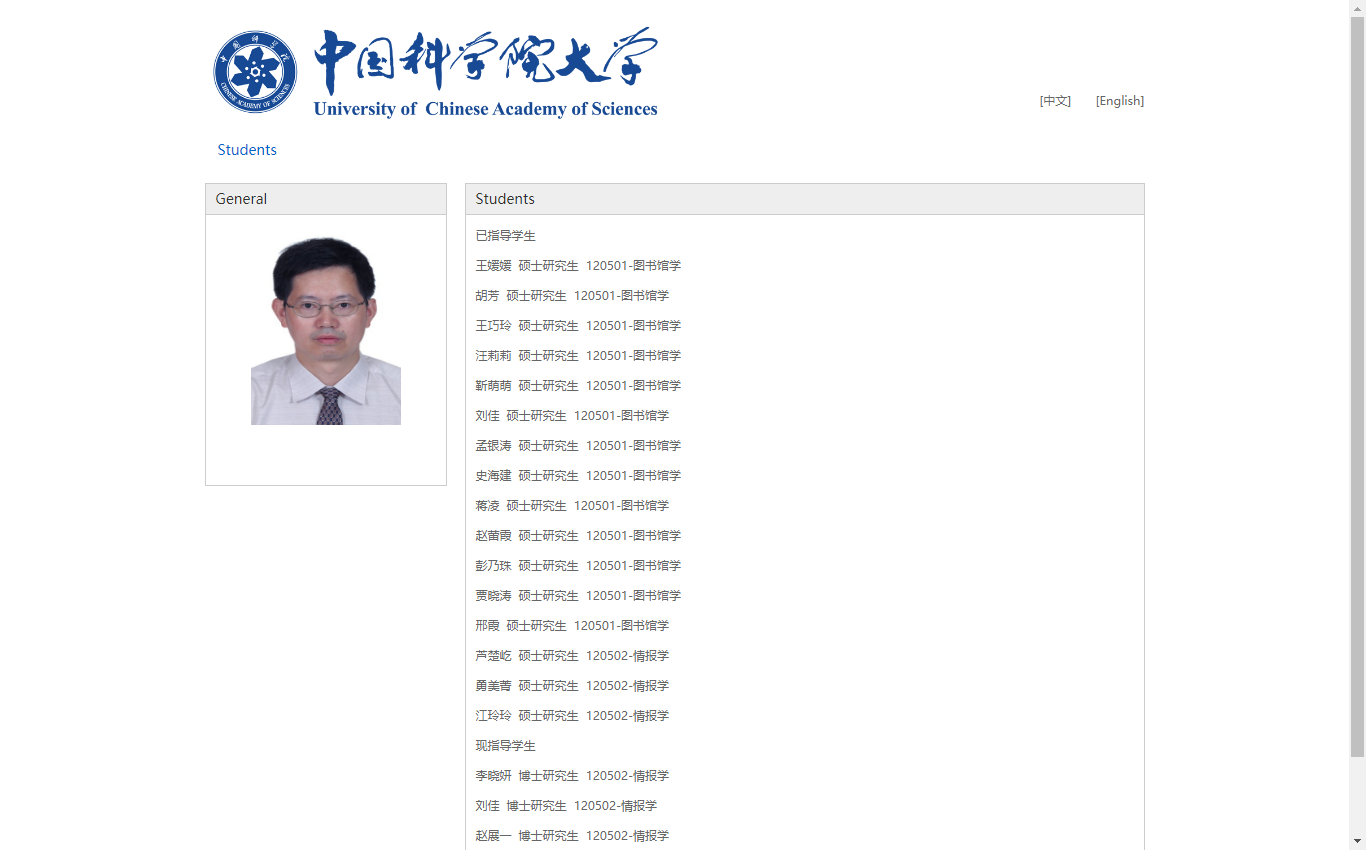

In [265]:
Image.open(io.BytesIO(dv.get_screenshot_as_png()))

#### 采集

In [231]:
tNow = 0
crawlGap = 3
with trange(now, nTotal) as tr:
    for i in tr:
        tWait = ceil(tNow + crawlGap - time())
        if 0 < tWait:
            with trange(tWait, leave=False) as tw:
                for j in tw:
                    print('waiting', tqdm=tw)
                    sleep(1)
        tNow = time()
        
        now = i
        name = scholars['fullname'][i]
        title = scholars['title'][i]
        href = scholars['href'][i]
        hrefEn = href + '?language=en'
        print(title, name, f'{i}/{nTotal}', tqdm=tr)
        
        rst = {}
        rst['name'] = name
        rst['title'] = title
        rst['href'] = href
        err1 = extractScholar(rst, href)
        err2 = extractScholar(rst, hrefEn, 'En')
        if not err1 and not err2:
            rst['code'] = 1
        
        fprint(json.dumps(rst), file=getFileName(name, href), path=title, mode='w')

(2021-07-07 19:55:47) 陈沫先 http://people.ucas.ac.cn/~mchen?language=en base info wrong length 0


(2021-07-07 19:57:26) 陈朴 http://people.ucas.ac.cn/~chenpu?language=en base info wrong length 0


(2021-07-07 19:57:35) 陈棋福 http://people.ucas.ac.cn/~chenqifu base info wrong length 0


(2021-07-07 19:57:39) 陈琦 http://people.ucas.ac.cn/~0000211?language=en base info wrong length 0


(2021-07-07 19:58:06) 陈青松 http://people.ucas.ac.cn/~cqs?language=en base info wrong length 0


(2021-07-07 19:58:34) 陈全胜 http://people.ucas.ac.cn/~0028328?language=en base info wrong length 0


(2021-07-07 19:59:13) 陈睿 http://people.ucas.ac.cn/~rui?language=en base info wrong length 0


(2021-07-07 19:59:34) 陈善慈 http://people.ucas.ac.cn/~csc?language=en base info wrong length 0


(2021-07-07 19:59:40) 陈尚锋 http://people.ucas.ac.cn/~0057603 base info wrong length 0
(2021-07-07 19:59:40) 陈尚锋 http://people.ucas.ac.cn/~0057603?language=en base info wrong length 0


(2021-07-07 19:59:57) 陈劭锋 http://people.ucas.ac.cn/~%E9%99%88%E5%8A%AD%E9%94%8B base info wrong length 0
(2021-07-07 19:59:57) 陈劭锋 http://people.ucas.ac.cn/~%E9%99%88%E5%8A%AD%E9%94%8B?language=en base info wrong length 0


(2021-07-07 20:00:16) 陈实 http://people.ucas.ac.cn/~chenshi?language=en base info wrong length 0


(2021-07-07 20:00:25) 陈世峰 http://people.ucas.ac.cn/~sfchen?language=en base info wrong length 0


(2021-07-07 20:01:13) 陈帅 http://people.ucas.ac.cn/~chenshuai base info wrong length 0
(2021-07-07 20:01:13) 陈帅 http://people.ucas.ac.cn/~chenshuai?language=en base info wrong length 0


(2021-07-07 20:01:25) 陈顺权 http://people.ucas.ac.cn/~chenshunquan base info wrong length 0


(2021-07-07 20:03:52) 陈卫 http://people.ucas.ac.cn/~aalto?language=en base info wrong length 0


(2021-07-07 20:04:03) 陈卫宁 http://people.ucas.ac.cn/~cwn-xy?language=en base info wrong length 0


(2021-07-07 20:04:32) 陈文军 http://people.ucas.ac.cn/~chenwenjun?language=en base info wrong length 0


(2021-07-07 20:04:35) 陈文俐 http://people.ucas.ac.cn/~%E9%99%88%E6%96%87%E4%BF%90 base info wrong length 0
(2021-07-07 20:04:35) 陈文俐 http://people.ucas.ac.cn/~%E9%99%88%E6%96%87%E4%BF%90?language=en base info wrong length 0


(2021-07-07 20:04:40) 陈文武 http://people.ucas.ac.cn/~chenwenwu?language=en base info wrong length 0


(2021-07-07 20:04:55) 陈希爱 http://people.ucas.ac.cn/~chenxiai?language=en base info wrong length 0


(2021-07-07 20:05:05) 陈熙仁 http://people.ucas.ac.cn/~xrchen?language=en base info wrong length 0


(2021-07-07 20:05:15) 陈曦 http://people.ucas.ac.cn/~chenxi?language=en base info wrong length 0


(2021-07-07 20:05:32) 陈祥雨 http://people.ucas.ac.cn/~chenxy?language=en base info wrong length 0


(2021-07-07 20:05:46) 陈小兵 http://people.ucas.ac.cn/~chenxb?language=en base info wrong length 0


(2021-07-07 20:06:00) 陈小林 http://people.ucas.ac.cn/~lin?language=en base info wrong length 0


(2021-07-07 20:06:39) 陈晓明 http://people.ucas.ac.cn/~chenxm?language=en base info wrong length 0


(2021-07-07 20:06:47) 陈晓珊 http://people.ucas.ac.cn/~chenxiaoshan?language=en base info wrong length 0


(2021-07-07 20:06:53) 陈晓亚 http://people.ucas.ac.cn/~Chen%20Xiaoya base info wrong length 0
(2021-07-07 20:06:53) 陈晓亚 http://people.ucas.ac.cn/~Chen%20Xiaoya?language=en base info wrong length 0


(2021-07-07 20:07:01) 陈孝飞 http://people.ucas.ac.cn/~chenxiaofei?language=en base info wrong length 0


(2021-07-07 20:07:15) 陈欣扬 http://people.ucas.ac.cn/~0021581?language=en base info wrong length 0


(2021-07-07 20:07:46) 陈兴 http://people.ucas.ac.cn/~xchen2015?language=en base info wrong length 0


(2021-07-07 20:08:29) 陈旭林 http://people.ucas.ac.cn/~chenxulin?language=en base info wrong length 0


(2021-07-07 20:08:51) 陈学文 http://people.ucas.ac.cn/~chenxuewen?language=en base info wrong length 0


(2021-07-07 20:09:01) 陈雪峰 http://people.ucas.ac.cn/~xfchen?language=en base info wrong length 0


(2021-07-07 20:09:54) 陈燕鑫 http://people.ucas.ac.cn/~CHEN%20Yanxin base info wrong length 0
(2021-07-07 20:09:54) 陈燕鑫 http://people.ucas.ac.cn/~CHEN%20Yanxin?language=en base info wrong length 0


(2021-07-07 20:10:58) 陈意 http://people.ucas.ac.cn/~iggchenyi base info wrong length 0


(2021-07-07 20:11:33) 陈永和 http://people.ucas.ac.cn/~0041131 base info wrong length 0
(2021-07-07 20:11:33) 陈永和 http://people.ucas.ac.cn/~0041131?language=en base info wrong length 0


(2021-07-07 20:11:37) 陈永华 http://people.ucas.ac.cn/~0046308 base info wrong length 0
(2021-07-07 20:11:37) 陈永华 http://people.ucas.ac.cn/~0046308?language=en base info wrong length 0


(2021-07-07 20:11:57) 陈永权 http://people.ucas.ac.cn/~cyq?language=en base info wrong length 0


(2021-07-07 20:13:04) 陈宇航 http://people.ucas.ac.cn/~0024006?language=en base info wrong length 0


(2021-07-07 20:13:18) 陈雨 http://people.ucas.ac.cn/~0027311?language=en base info wrong length 0


(2021-07-07 20:13:22) 陈雨 http://people.ucas.ac.cn/~chenyusiccas?language=en base info wrong length 0


(2021-07-07 20:13:40) 陈玉鹏 http://people.ucas.ac.cn/~chenyupeng?language=en base info wrong length 0


(2021-07-07 20:14:14) 陈媛 http://people.ucas.ac.cn/~6386145?language=en base info wrong length 0


(2021-07-07 20:14:28) 陈悦 http://people.ucas.ac.cn/~yuechen?language=en base info wrong length 0


(2021-07-07 20:14:38) 陈越磊 http://people.ucas.ac.cn/~chenyuelei?language=en base info wrong length 0


(2021-07-07 20:14:42) 陈赟 http://people.ucas.ac.cn/~tutorchy?language=en base info wrong length 0


(2021-07-07 20:14:44) 陈赟 http://people.ucas.ac.cn/~chenyun base info wrong length 0


(2021-07-07 20:14:50) 陈云 http://people.ucas.ac.cn/~cy1205?language=en base info wrong length 0


(2021-07-07 20:15:27) 陈增明 http://people.ucas.ac.cn/~ZMCHEN?language=en base info wrong length 0


(2021-07-07 20:16:08) 陈植武 http://people.ucas.ac.cn/~zhiwuchen?language=en base info wrong length 0


(2021-07-07 20:16:26) 陈志敏 http://people.ucas.ac.cn/~soleczm?language=en base info wrong length 0


(2021-07-07 20:16:54) 陈智勇 http://people.ucas.ac.cn/~chenzhiyong?language=en base info wrong length 0


(2021-07-07 20:17:14) 陈卓 http://people.ucas.ac.cn/~701103 base info wrong length 0
(2021-07-07 20:17:14) 陈卓 http://people.ucas.ac.cn/~701103?language=en base info wrong length 0


(2021-07-07 20:17:20) 陈祖安 http://people.ucas.ac.cn/~chenzuan base info wrong length 0


(2021-07-07 20:17:24) 陈祖昕 http://people.ucas.ac.cn/~zuxinchen?language=en base info wrong length 0


(2021-07-07 20:17:45) 成步文 http://people.ucas.ac.cn/~Buwen%20Cheng base info wrong length 0
(2021-07-07 20:17:45) 成步文 http://people.ucas.ac.cn/~Buwen%20Cheng?language=en base info wrong length 0


(2021-07-07 20:18:09) 成苗 http://people.ucas.ac.cn/~chengmiao?language=en base info wrong length 0


(2021-07-07 20:18:35) 程炳钧 http://people.ucas.ac.cn/~chengbj?language=en base info wrong length 0


(2021-07-07 20:18:41) 程德林 http://people.ucas.ac.cn/~chengdelin?language=en base info wrong length 0


(2021-07-07 20:18:48) 程国峰 http://people.ucas.ac.cn/~021?language=en base info wrong length 0


(2021-07-07 20:19:02) 程浩毅 http://people.ucas.ac.cn/~ChengHao-Yi?language=en base info wrong length 0


(2021-07-07 20:19:24) 程惠红 http://people.ucas.ac.cn/~140801?language=en base info wrong length 0


(2021-07-07 20:19:57) 程进三 http://people.ucas.ac.cn/~0020263?language=en base info wrong length 0


(2021-07-07 20:19:59) 程晋罗 http://people.ucas.ac.cn/~0064437 base info wrong length 0
(2021-07-07 20:19:59) 程晋罗 http://people.ucas.ac.cn/~0064437?language=en base info wrong length 0


(2021-07-07 20:20:23) 程力 http://people.ucas.ac.cn/~0036520?language=en base info wrong length 0


(2021-07-07 20:21:33) 程鑫 http://people.ucas.ac.cn/~chengxin2020?language=en base info wrong length 0


(2021-07-07 20:21:40) 程学武 http://people.ucas.ac.cn/~cxw18?language=en base info wrong length 0


(2021-07-07 20:22:25) 程征伟 http://people.ucas.ac.cn/~zwcheng?language=en base info wrong length 0


(2021-07-07 20:22:54) 池天河 http://people.ucas.ac.cn/~chitianhe base info wrong length 0
(2021-07-07 20:22:54) 池天河 http://people.ucas.ac.cn/~chitianhe?language=en base info wrong length 0


(2021-07-07 20:23:10) 迟浩 http://people.ucas.ac.cn/~chihao?language=en base info wrong length 0


(2021-07-07 20:23:16) 迟晓伟 http://people.ucas.ac.cn/~xwchi?language=en base info wrong length 0


(2021-07-07 20:23:47) 初青伟 http://people.ucas.ac.cn/~cqw?language=en base info wrong length 0


(2021-07-07 20:24:17) 储著银 http://people.ucas.ac.cn/~%E5%82%A8%E8%91%97%E9%93%B6 base info wrong length 0
(2021-07-07 20:24:17) 储著银 http://people.ucas.ac.cn/~%E5%82%A8%E8%91%97%E9%93%B6?language=en base info wrong length 0


(2021-07-07 20:24:30) 楚文玲 http://people.ucas.ac.cn/~chuwenling?language=en base info wrong length 0


(2021-07-07 20:25:03) 褚月英 http://people.ucas.ac.cn/~chuyueying?language=en base info wrong length 0


(2021-07-07 20:25:21) 丛欢 http://people.ucas.ac.cn/~conghuan?language=en base info wrong length 0


(2021-07-07 20:25:42) 丛志奇 http://people.ucas.ac.cn/~Zhiqi%20Cong base info wrong length 0
(2021-07-07 20:25:42) 丛志奇 http://people.ucas.ac.cn/~Zhiqi%20Cong?language=en base info wrong length 0


(2021-07-07 20:26:20) 崔海霞 http://people.ucas.ac.cn/~chx?language=en base info wrong length 0


(2021-07-07 20:26:33) 崔鸿飞 http://people.ucas.ac.cn/~cuihongfei?language=en base info wrong length 0


(2021-07-07 20:26:36) 崔惠娟 http://people.ucas.ac.cn/~cui?language=en base info wrong length 0


(2021-07-07 20:27:01) 崔金明 http://people.ucas.ac.cn/~cuijinming?language=en base info wrong length 0


(2021-07-07 20:27:23) 崔磊 http://people.ucas.ac.cn/~leicui?language=en base info wrong length 0


(2021-07-07 20:27:43) 崔明焕 http://people.ucas.ac.cn/~mhcui?language=en base info wrong length 0


(2021-07-07 20:27:46) 崔朋蕾 http://people.ucas.ac.cn/~plcui?language=en base info wrong length 0


(2021-07-07 20:28:01) 崔胜国 http://people.ucas.ac.cn/~cuishengguo?language=en base info wrong length 0


(2021-07-07 20:28:09) 崔帅 http://people.ucas.ac.cn/~cshuai?language=en base info wrong length 0


(2021-07-07 20:28:57) 崔小明 http://people.ucas.ac.cn/~cuixm?language=en base info wrong length 0


(2021-07-07 20:29:49) 崔玥 http://people.ucas.ac.cn/~cuiyue?language=en base info wrong length 0


(2021-07-07 20:30:02) 崔振东 http://people.ucas.ac.cn/~cuizhendong base info wrong length 0


(2021-07-07 20:30:07) 崔子立 http://people.ucas.ac.cn/~cuizili?language=en base info wrong length 0


(2021-07-07 20:30:19) 寸玉鹏 http://people.ucas.ac.cn/~cunyp?language=en base info wrong length 0


(2021-07-07 20:30:36) Dieter H. Bimberg http://people.ucas.ac.cn/~Bimberg?language=en base info wrong length 0


(2021-07-07 20:30:57) 代锋 http://people.ucas.ac.cn/~daifeng?language=en base info wrong length 0


(2021-07-07 20:31:13) 代焕琴 http://people.ucas.ac.cn/~hd?language=en base info wrong length 0


(2021-07-07 20:31:55) 戴凤钊 http://people.ucas.ac.cn/~daifengzhao?language=en base info wrong length 0


(2021-07-07 20:31:58) 戴高乐 http://people.ucas.ac.cn/~0028434?language=en base info wrong length 0


(2021-07-07 20:33:16) 戴路 http://people.ucas.ac.cn/~dailu?language=en base info wrong length 0


(2021-07-07 20:34:45) 戴永浩 http://people.ucas.ac.cn/~0026698?language=en base info wrong length 0


(2021-07-07 20:35:12) 戴住波 http://people.ucas.ac.cn/~daizhubo?language=en base info wrong length 0


(2021-07-07 20:35:16) 戴卓君 http://people.ucas.ac.cn/~ZDlab?language=en base info wrong length 0


(2021-07-07 20:36:16) 邓成龙 http://people.ucas.ac.cn/~dengchenglong base info wrong length 0


(2021-07-07 20:36:55) 邓鹤 http://people.ucas.ac.cn/~denghe?language=en base info wrong length 0


(2021-07-07 20:37:29) 邓建明 http://people.ucas.ac.cn/~qingyi1207?language=en base info wrong length 0


(2021-07-07 20:37:39) 邓瑾妮 http://people.ucas.ac.cn/~dengjinni?language=en base info wrong length 0


(2021-07-07 20:38:43) 邓容 http://people.ucas.ac.cn/~dengrong?language=en base info wrong length 0
(2021-07-07 20:38:45) 邓赛 http://people.ucas.ac.cn/~dengsai?language=en base info wrong length 0


(2021-07-07 20:39:06) 邓淞文 http://people.ucas.ac.cn/~dengsongwen?language=en base info wrong length 0


(2021-07-07 20:41:09) 邓祝云 http://people.ucas.ac.cn/~dengzhuyun?language=en base info wrong length 0


(2021-07-07 20:41:20) 狄增峰 http://people.ucas.ac.cn/~dizengfeng?language=en base info wrong length 0


(2021-07-07 20:41:44) 邸思 http://people.ucas.ac.cn/~ds?language=en base info wrong length 0


(2021-07-07 20:41:52) 邸迎彤 http://people.ucas.ac.cn/~diyingtongchemicalbiology1?language=en base info wrong length 0


(2021-07-07 20:41:54) 底青云 http://people.ucas.ac.cn/~qydi base info wrong length 0


(2021-07-07 20:42:12) 丁昌峰 http://people.ucas.ac.cn/~changfengding?language=en base info wrong length 0


(2021-07-07 20:42:17) 丁超 http://people.ucas.ac.cn/~cding?language=en base info wrong length 0


(2021-07-07 20:42:48) 丁锋 http://people.ucas.ac.cn/~dingfeng base info wrong length 0


(2021-07-07 20:45:03) 丁文武 http://people.ucas.ac.cn/~dingwenwu?language=en base info wrong length 0


(2021-07-07 20:45:30) 丁雅韵 http://people.ucas.ac.cn/~dingyy?language=en base info wrong length 0


(2021-07-07 20:45:46) 丁义纯 http://people.ucas.ac.cn/~0067395?language=en base info wrong length 0


(2021-07-07 20:47:20) 董东 http://people.ucas.ac.cn/~dongdong?language=en base info wrong length 0


(2021-07-07 20:47:34) 董凤良 http://people.ucas.ac.cn/~fldong?language=en base info wrong length 0


(2021-07-07 20:48:54) 董建敏 http://people.ucas.ac.cn/~dongjianmin?language=en base info wrong length 0


(2021-07-07 20:49:31) 董磊 http://people.ucas.ac.cn/~donglei?language=en base info wrong length 0


(2021-07-07 20:49:50) 董亮 http://people.ucas.ac.cn/~dongliang?language=en base info wrong length 0


(2021-07-07 20:50:02) 董宁宁 http://people.ucas.ac.cn/~dongningning?language=en base info wrong length 0


(2021-07-07 20:50:27) 董绍武 http://people.ucas.ac.cn/~0002835 base info wrong length 0
(2021-07-07 20:50:27) 董绍武 http://people.ucas.ac.cn/~0002835?language=en base info wrong length 0


(2021-07-07 20:51:23) 董喜存 http://people.ucas.ac.cn/~dongxicun?language=en base info wrong length 0
(2021-07-07 20:51:24) 董侠 http://people.ucas.ac.cn/~Xia%20Dong base info wrong length 0
(2021-07-07 20:51:24) 董侠 http://people.ucas.ac.cn/~Xia%20Dong?language=en base info wrong length 0


(2021-07-07 20:51:28) 董先智 http://people.ucas.ac.cn/~dongxianzhi?language=en base info wrong length 0


(2021-07-07 20:52:08) 董雪 http://people.ucas.ac.cn/~dongxue?language=en base info wrong length 0


(2021-07-07 20:52:23) 董阳 http://people.ucas.ac.cn/~yangdong?language=en base info wrong length 0


(2021-07-07 20:52:36) 董莹莹 http://people.ucas.ac.cn/~dongyy?language=en base info wrong length 0


(2021-07-07 20:53:20) 董志超 http://people.ucas.ac.cn/~zhichao?language=en base info wrong length 0


(2021-07-07 20:54:10) 窦强 http://people.ucas.ac.cn/~0043954?language=en base info wrong length 0


(2021-07-07 20:56:22) 杜久林 http://people.ucas.ac.cn/~Jiulin%20Du base info wrong length 0
(2021-07-07 20:56:22) 杜久林 http://people.ucas.ac.cn/~Jiulin%20Du?language=en base info wrong length 0


(2021-07-07 20:56:29) 杜娟 http://people.ucas.ac.cn/~0046412 base info wrong length 0
(2021-07-07 20:56:29) 杜娟 http://people.ucas.ac.cn/~0046412?language=en base info wrong length 0


(2021-07-07 20:58:15) 杜特专 http://people.ucas.ac.cn/~dutezhuan?language=en base info wrong length 0


(2021-07-07 20:58:43) 杜杏叶 http://people.ucas.ac.cn/~duxingye?language=en base info wrong length 0


(2021-07-07 20:58:51) 杜嬛 http://people.ucas.ac.cn/~xdu?language=en base info wrong length 0


(2021-07-07 20:58:57) 杜亚蓉 http://people.ucas.ac.cn/~duyarong?language=en base info wrong length 0


(2021-07-07 20:59:21) 杜垚 http://people.ucas.ac.cn/~0041294?language=en base info wrong length 0


(2021-07-07 20:59:46) 杜宇 http://people.ucas.ac.cn/~DUYU?language=en base info wrong length 0


(2021-07-07 21:00:42) 杜竹玮 http://people.ucas.ac.cn/~Duzhuwei?language=en base info wrong length 0


(2021-07-07 21:00:55) 段宝利 http://people.ucas.ac.cn/~0021398?language=en base info wrong length 0


(2021-07-07 21:00:59) 段彬 http://people.ucas.ac.cn/~duanbin?language=en base info wrong length 0


(2021-07-07 21:01:14) 段春阳 http://people.ucas.ac.cn/~dcy?language=en base info wrong length 0


(2021-07-07 21:01:53) 段洪敏 http://people.ucas.ac.cn/~dhm?language=en base info wrong length 0


(2021-07-07 21:02:40) 段谟杰 http://people.ucas.ac.cn/~mduan?language=en base info wrong length 0


(2021-07-07 21:02:56) 段弢 http://people.ucas.ac.cn/~duantao?language=en base info wrong length 0


(2021-07-07 21:03:03) 段微波 http://people.ucas.ac.cn/~duanweibo?language=en base info wrong length 0


(2021-07-07 21:03:17) 段晓霞 http://people.ucas.ac.cn/~xxduan?language=en base info wrong length 0


(2021-07-07 21:03:54) 段哲 http://people.ucas.ac.cn/~zduan?language=en base info wrong length 0


(2021-07-07 21:04:22) 鄂书林 http://people.ucas.ac.cn/~eshulin?language=en base info wrong length 0


(2021-07-07 21:04:45) 樊邦奎 http://people.ucas.ac.cn/~fanbangkui?language=en base info wrong length 0


(2021-07-07 21:04:50) 樊春良 http://people.ucas.ac.cn/~%E6%A8%8A%E6%98%A5%E8%89%AF base info wrong length 0
(2021-07-07 21:04:50) 樊春良 http://people.ucas.ac.cn/~%E6%A8%8A%E6%98%A5%E8%89%AF?language=en base info wrong length 0


(2021-07-07 21:05:50) 樊启顺 http://people.ucas.ac.cn/~fanqishun?language=en base info wrong length 0


(2021-07-07 21:06:37) 范川林 http://people.ucas.ac.cn/~chlfan?language=en base info wrong length 0


(2021-07-07 21:07:02) 范芳丽 http://people.ucas.ac.cn/~fanfangli?language=en base info wrong length 0


(2021-07-07 21:07:25) 范宏瑞 http://people.ucas.ac.cn/~fanhongrui base info wrong length 0


(2021-07-07 21:07:57) 范丽军 http://people.ucas.ac.cn/~fanlj?language=en base info wrong length 0


(2021-07-07 21:08:20) 范涛 http://people.ucas.ac.cn/~fantao?language=en base info wrong length 0


(2021-07-07 21:08:32) 范伟 http://people.ucas.ac.cn/~weifan?language=en base info wrong length 0


(2021-07-07 21:08:33) 范蔚茗 http://people.ucas.ac.cn/~Fan%20Weiming base info wrong length 0
(2021-07-07 21:08:33) 范蔚茗 http://people.ucas.ac.cn/~Fan%20Weiming?language=en base info wrong length 0


(2021-07-07 21:08:42) 范文杰 http://people.ucas.ac.cn/~fanwenjie?language=en base info wrong length 0


(2021-07-07 21:09:14) 范玉峰 http://people.ucas.ac.cn/~0028458?language=en base info wrong length 0


(2021-07-07 21:09:52) 方芳 http://people.ucas.ac.cn/~fangf?language=en base info wrong length 0


(2021-07-07 21:10:03) 方国东 http://people.ucas.ac.cn/~gdfang?language=en base info wrong length 0


(2021-07-07 21:10:28) 方华军 http://people.ucas.ac.cn/~huajunfang?language=en base info wrong length 0


(2021-07-07 21:11:25) 方齐乐 http://people.ucas.ac.cn/~fangqile?language=en base info wrong length 0


(2021-07-07 21:11:39) 方全 http://people.ucas.ac.cn/~quanfang?language=en base info wrong length 0
(2021-07-07 21:11:44) 方少波 http://people.ucas.ac.cn/~5?language=en base info wrong length 0


(2021-07-07 21:12:08) 方伟慧 http://people.ucas.ac.cn/~fangweihui?language=en base info wrong length 0


(2021-07-07 21:12:58) 方一兵 http://people.ucas.ac.cn/~yibingfang base info wrong length 0
(2021-07-07 21:12:58) 方一兵 http://people.ucas.ac.cn/~yibingfang?language=en base info wrong length 0


(2021-07-07 21:13:23) 方灶军 http://people.ucas.ac.cn/~fangzaojun?language=en base info wrong length 0


(2021-07-07 21:14:07) 房林 http://people.ucas.ac.cn/~linfang?language=en base info wrong length 0


(2021-07-07 21:14:18) 房强 http://people.ucas.ac.cn/~fangqiang base info wrong length 0
(2021-07-07 21:14:18) 房强 http://people.ucas.ac.cn/~fangqiang?language=en base info wrong length 0


(2021-07-07 21:14:23) 房世峰 http://people.ucas.ac.cn/~fangshifeng?language=en base info wrong length 0


(2021-07-07 21:14:36) 房新强 http://people.ucas.ac.cn/~The%20Fang%20Group base info wrong length 0
(2021-07-07 21:14:36) 房新强 http://people.ucas.ac.cn/~The%20Fang%20Group?language=en base info wrong length 0


(2021-07-07 21:14:41) 房嬛 http://people.ucas.ac.cn/~fangx?language=en base info wrong length 0


(2021-07-07 21:15:06) 封安辉 http://people.ucas.ac.cn/~fenganhui?language=en base info wrong length 0


(2021-07-07 21:16:08) 冯德鑫 http://people.ucas.ac.cn/~fengdexin?language=en base info wrong length 0


(2021-07-07 21:16:25) 冯海兰 http://people.ucas.ac.cn/~hlfeng?language=en base info wrong length 0


(2021-07-07 21:17:10) 冯立强 http://people.ucas.ac.cn/~Liqiang%20Feng base info wrong length 0
(2021-07-07 21:17:10) 冯立强 http://people.ucas.ac.cn/~Liqiang%20Feng?language=en base info wrong length 0


(2021-07-07 21:17:47) 冯宁东 http://people.ucas.ac.cn/~fnd?language=en base info wrong length 0


(2021-07-07 21:18:21) 冯青郁 http://people.ucas.ac.cn/~qingyufeng?language=en base info wrong length 0


(2021-07-07 21:18:36) 冯少辉 http://people.ucas.ac.cn/~fengshaohui?language=en base info wrong length 0


(2021-07-07 21:18:45) 冯树龙 http://people.ucas.ac.cn/~fengshulong?language=en base info wrong length 0


(2021-07-07 21:19:07) 冯维淼 http://people.ucas.ac.cn/~fengweimiao?language=en base info wrong length 0


(2021-07-07 21:19:10) 冯伟 http://people.ucas.ac.cn/~fengwei?language=en base info wrong length 0


(2021-07-07 21:19:52) 冯晓明 http://people.ucas.ac.cn/~0017482?language=en base info wrong length 0


(2021-07-07 21:21:01) 冯缨 http://people.ucas.ac.cn/~luckfy?language=en base info wrong length 0


(2021-07-07 21:21:34) 冯志杰 http://people.ucas.ac.cn/~fengzhijie?language=en base info wrong length 0


(2021-07-07 21:22:11) 付长民 http://people.ucas.ac.cn/~fcm?language=en base info wrong length 0


(2021-07-07 21:22:38) 付国柱 http://people.ucas.ac.cn/~fuguozhu?language=en base info wrong length 0


(2021-07-07 21:22:59) 付晶莹 http://people.ucas.ac.cn/~fjy?language=en base info wrong length 0


(2021-07-07 21:23:39) 付生鹏 http://people.ucas.ac.cn/~fushengpeng?language=en base info wrong length 0


(2021-07-07 21:24:55) 傅瑞标 http://people.ucas.ac.cn/~Fu%20Ruibiao base info wrong length 0
(2021-07-07 21:24:55) 傅瑞标 http://people.ucas.ac.cn/~Fu%20Ruibiao?language=en base info wrong length 0


(2021-07-07 21:25:20) 傅兴玉 http://people.ucas.ac.cn/~fxy?language=en base info wrong length 0


(2021-07-07 21:26:39) 甘阳洲 http://people.ucas.ac.cn/~yangzhou_GAN?language=en base info wrong length 0


(2021-07-07 21:26:42) 甘永东 http://people.ucas.ac.cn/~ganyongdong?language=en base info wrong length 0


(2021-07-07 21:27:26) 高博 http://people.ucas.ac.cn/~GB?language=en base info wrong length 0


(2021-07-07 21:27:47) 高琛 http://people.ucas.ac.cn/~cgao?language=en base info wrong length 0


(2021-07-07 21:27:50) 高程 http://people.ucas.ac.cn/~chenggao?language=en base info wrong length 0


(2021-07-07 21:28:30) 高东峰 http://people.ucas.ac.cn/~dfgao?language=en base info wrong length 0


(2021-07-07 21:28:38) 高冬平 http://people.ucas.ac.cn/~0041840?language=en base info wrong length 0


(2021-07-07 21:29:05) 高方圆 http://people.ucas.ac.cn/~gfy?language=en base info wrong length 0


(2021-07-07 21:29:59) 高国荣 http://people.ucas.ac.cn/~gaogr?language=en base info wrong length 0


(2021-07-07 21:30:04) 高红 http://people.ucas.ac.cn/~gaohong?language=en base info wrong length 0


(2021-07-07 21:30:43) 高剑峰 http://people.ucas.ac.cn/~gaojianfeng?language=en base info wrong length 0


(2021-07-07 21:30:47) 高江波 http://people.ucas.ac.cn/~0037871?language=en base info wrong length 0


(2021-07-07 21:31:45) 高俊华 http://people.ucas.ac.cn/~gaojh?language=en base info wrong length 0


(2021-07-07 21:33:08) 高明辉 http://people.ucas.ac.cn/~ccgaomh1971?language=en base info wrong length 0


(2021-07-07 21:33:28) 高朋鑫 http://people.ucas.ac.cn/~gaopengxin?language=en base info wrong length 0


(2021-07-07 21:33:42) 高鹏 http://people.ucas.ac.cn/~penggao?language=en base info wrong length 0


(2021-07-07 21:33:51) 高七一 http://people.ucas.ac.cn/~gaoqiyi?language=en base info wrong length 0


(2021-07-07 21:34:01) 高庆波 http://people.ucas.ac.cn/~0029857?language=en base info wrong length 0


(2021-07-07 21:34:13) 高山 http://people.ucas.ac.cn/~shangaoqdio?language=en base info wrong length 0


(2021-07-07 21:34:45) 高爽 http://people.ucas.ac.cn/~gaoshuang?language=en base info wrong length 0


(2021-07-07 21:34:47) 高水英 http://people.ucas.ac.cn/~%E9%AB%98%E6%B0%B4%E8%8B%B1 base info wrong length 0
(2021-07-07 21:34:47) 高水英 http://people.ucas.ac.cn/~%E9%AB%98%E6%B0%B4%E8%8B%B1?language=en base info wrong length 0


(2021-07-07 21:35:26) 高伟 http://people.ucas.ac.cn/~gw2020?language=en base info wrong length 0


(2021-07-07 21:36:20) 高晓东 http://people.ucas.ac.cn/~doniao?language=en base info wrong length 0


(2021-07-07 21:36:44) 高笑菲 http://people.ucas.ac.cn/~gaoxf?language=en base info wrong length 0


(2021-07-07 21:36:54) 高鑫 http://people.ucas.ac.cn/~gaoxin?language=en base info wrong length 0


(2021-07-07 21:37:08) 高兴宇 http://people.ucas.ac.cn/~0066348 base info wrong length 0
(2021-07-07 21:37:08) 高兴宇 http://people.ucas.ac.cn/~0066348?language=en base info wrong length 0


(2021-07-07 21:37:37) 高学睿 http://people.ucas.ac.cn/~gaoxuerui?language=en base info wrong length 0


(2021-07-07 21:38:09) 高阳 http://people.ucas.ac.cn/~yang.gao?language=en base info wrong length 0


(2021-07-07 21:38:20) 高嶷 http://people.ucas.ac.cn/~gaoyi?language=en base info wrong length 0


(2021-07-07 21:38:41) 高永 http://people.ucas.ac.cn/~gaoyong?language=en base info wrong length 0


(2021-07-07 21:38:51) 高宇 http://people.ucas.ac.cn/~gaoyu?language=en base info wrong length 0


(2021-07-07 21:39:21) 高云东 http://people.ucas.ac.cn/~yundonggao?language=en base info wrong length 0


(2021-07-07 21:40:13) 戈敏 http://people.ucas.ac.cn/~gm?language=en base info wrong length 0


(2021-07-07 21:40:16) 格日乐 http://people.ucas.ac.cn/~dicpgerile?language=en base info wrong length 0


(2021-07-07 21:41:15) 葛亮 http://people.ucas.ac.cn/~geliang?language=en base info wrong length 0


(2021-07-07 21:41:56) 葛体达 http://people.ucas.ac.cn/~Tida?language=en base info wrong length 0


(2021-07-07 21:42:28) 葛永刚 http://people.ucas.ac.cn/~imdegeyonggang?language=en base info wrong length 0


(2021-07-07 21:42:50) 葛志伟 http://people.ucas.ac.cn/~zhwge?language=en base info wrong length 0


(2021-07-07 21:43:38) 耿旭辉 http://people.ucas.ac.cn/~gengxuhui?language=en base info wrong length 0
(2021-07-07 21:43:44) 耿艳娟 http://people.ucas.ac.cn/~gengyj?language=en base info wrong length 0


(2021-07-07 21:43:59) 耿志辉 http://people.ucas.ac.cn/~zhhg?language=en base info wrong length 0


(2021-07-07 21:44:01) 公发全 http://people.ucas.ac.cn/~888?language=en base info wrong length 0


(2021-07-07 21:44:05) 公茂明 http://people.ucas.ac.cn/~gmm?language=en base info wrong length 0


(2021-07-07 21:44:45) 宫在晓 http://people.ucas.ac.cn/~0004292?language=en base info wrong length 0


(2021-07-07 21:44:53) 龚成 http://people.ucas.ac.cn/~gongcheng?language=en base info wrong length 0


(2021-07-07 21:45:07) 龚海楠 http://people.ucas.ac.cn/~gonghainan?language=en base info wrong length 0


(2021-07-07 21:45:30) 龚亮 http://people.ucas.ac.cn/~%E9%BE%9A%E4%BA%AE base info wrong length 0
(2021-07-07 21:45:30) 龚亮 http://people.ucas.ac.cn/~%E9%BE%9A%E4%BA%AE?language=en base info wrong length 0


(2021-07-07 21:46:06) 龚伟 http://people.ucas.ac.cn/~wgong?language=en base info wrong length 0


(2021-07-07 21:46:36) 龚勇 http://people.ucas.ac.cn/~gongyong?language=en base info wrong length 0


(2021-07-07 21:46:47) 龚洲 http://people.ucas.ac.cn/~gongzhou?language=en base info wrong length 0


(2021-07-07 21:46:56) 巩方玲 http://people.ucas.ac.cn/~gfling?language=en base info wrong length 0


(2021-07-07 21:47:04) 巩蕤梓 http://people.ucas.ac.cn/~gonglizhi base info wrong length 0
(2021-07-07 21:47:05) 巩蕤梓 http://people.ucas.ac.cn/~gonglizhi?language=en base info wrong length 0


(2021-07-07 21:47:24) 缑永胜 http://people.ucas.ac.cn/~gouyongsheng?language=en base info wrong length 0


(2021-07-07 21:47:27) 苟高鹏 http://people.ucas.ac.cn/~gougaopeng?language=en base info wrong length 0


(2021-07-07 21:47:41) 古宏伟 http://people.ucas.ac.cn/~guhw?language=en base info wrong length 0


(2021-07-07 21:47:50) 古若雷 http://people.ucas.ac.cn/~guruolei?language=en base info wrong length 0


(2021-07-07 21:48:07) 谷丰 http://people.ucas.ac.cn/~gufeng?language=en base info wrong length 0


(2021-07-07 21:48:25) 谷林 http://people.ucas.ac.cn/~gulin?language=en base info wrong length 0


(2021-07-07 21:48:32) 谷松 http://people.ucas.ac.cn/~gusong?language=en base info wrong length 0


(2021-07-07 21:48:52) 谷志刚 http://people.ucas.ac.cn/~gu?language=en base info wrong length 0


(2021-07-07 21:49:39) 顾可伟 http://people.ucas.ac.cn/~gukw@impcas.ac.cn?language=en base info wrong length 0


(2021-07-07 21:52:20) 关武祥 http://people.ucas.ac.cn/~guanwx2012?language=en base info wrong length 0


(2021-07-07 21:52:22) 关晓武 http://people.ucas.ac.cn/~Guan%20Xiaowu base info wrong length 0
(2021-07-07 21:52:22) 关晓武 http://people.ucas.ac.cn/~Guan%20Xiaowu?language=en base info wrong length 0


(2021-07-07 21:52:27) 关欣 http://people.ucas.ac.cn/~guanxin?language=en base info wrong length 0


(2021-07-07 21:52:38) 关莹 http://people.ucas.ac.cn/~guanying?language=en base info wrong length 0


(2021-07-07 21:52:41) 关永军 http://people.ucas.ac.cn/~guan?language=en base info wrong length 0


(2021-07-07 21:52:53) 官建成 http://people.ucas.ac.cn/~guanjianch?language=en base info wrong length 0


(2021-07-07 21:52:59) 官轮辉 http://people.ucas.ac.cn/~%E5%AE%98%E8%BD%AE%E8%BE%89 base info wrong length 0
(2021-07-07 21:52:59) 官轮辉 http://people.ucas.ac.cn/~%E5%AE%98%E8%BD%AE%E8%BE%89?language=en base info wrong length 0


(2021-07-07 21:54:33) 郭崇滨 http://people.ucas.ac.cn/~chongbin.guo?language=en base info wrong length 0


(2021-07-07 21:54:40) 郭春海 http://people.ucas.ac.cn/~guochunhai?language=en base info wrong length 0


(2021-07-07 21:55:22) 郭大权 http://people.ucas.ac.cn/~guodaquan base info wrong length 0
(2021-07-07 21:55:22) 郭大权 http://people.ucas.ac.cn/~guodaquan?language=en base info wrong length 0


(2021-07-07 21:56:04) 郭光军 http://people.ucas.ac.cn/~guoguangjun base info wrong length 0


(2021-07-07 21:57:00) 郭嘉丰 http://people.ucas.ac.cn/~0023936?language=en base info wrong length 0


(2021-07-07 21:57:26) 郭建明 http://people.ucas.ac.cn/~guojianming?language=en base info wrong length 0


(2021-07-07 21:57:35) 郭建伟 http://people.ucas.ac.cn/~jianweiguo?language=en base info wrong length 0


(2021-07-07 21:58:10) 郭疆 http://people.ucas.ac.cn/~guojiang?language=en base info wrong length 0


(2021-07-07 21:58:43) 郭静 http://people.ucas.ac.cn/~guojing base info wrong length 0
(2021-07-07 21:58:43) 郭静 http://people.ucas.ac.cn/~guojing?language=en base info wrong length 0


(2021-07-07 21:59:06) 郭磊 http://people.ucas.ac.cn/~guolei?language=en base info wrong length 0


(2021-07-07 22:00:16) 郭鹏 http://people.ucas.ac.cn/~guopeng?language=en base info wrong length 0


(2021-07-07 22:00:31) 郭谦谦 http://people.ucas.ac.cn/~guoqq?language=en base info wrong length 0


(2021-07-07 22:00:39) 郭茜旎 http://people.ucas.ac.cn/~gqn?language=en base info wrong length 0


(2021-07-07 22:00:46) 郭秦敏 http://people.ucas.ac.cn/~guoqinmin?language=en base info wrong length 0


(2021-07-07 22:01:05) 郭铨 http://people.ucas.ac.cn/~guoquan?language=en base info wrong length 0


(2021-07-07 22:01:16) 郭汝海 http://people.ucas.ac.cn/~guoruhai?language=en base info wrong length 0


(2021-07-07 22:01:19) 郭汝江 http://people.ucas.ac.cn/~guorj?language=en base info wrong length 0


(2021-07-07 22:02:00) 郭双喜 http://people.ucas.ac.cn/~guoshuangxi?language=en base info wrong length 0


(2021-07-07 22:02:02) 郭顺 http://people.ucas.ac.cn/~guoshun base info wrong length 0


(2021-07-07 22:02:11) 郭松峰 http://people.ucas.ac.cn/~guosongfeng?language=en base info wrong length 0


(2021-07-07 22:02:47) 郭伟 http://people.ucas.ac.cn/~0015476?language=en base info wrong length 0


(2021-07-07 22:02:55) 郭炜 http://people.ucas.ac.cn/~guowei2016?language=en base info wrong length 0


(2021-07-07 22:02:59) 郭文勇 http://people.ucas.ac.cn/~guowenyong?language=en base info wrong length 0


(2021-07-07 22:03:19) 郭晓峰 http://people.ucas.ac.cn/~xfguo?language=en base info wrong length 0


(2021-07-07 22:03:50) 郭新新 http://people.ucas.ac.cn/~guoxinxin?language=en base info wrong length 0


(2021-07-07 22:04:22) 郭亚楠 http://people.ucas.ac.cn/~guoyanan?language=en base info wrong length 0


(2021-07-07 22:05:07) 郭迎辉 http://people.ucas.ac.cn/~guoyinghui?language=en base info wrong length 0


(2021-07-07 22:05:21) 郭永卫 http://people.ucas.ac.cn/~guoyongwei?language=en base info wrong length 0


(2021-07-07 22:05:54) 郭媛君 http://people.ucas.ac.cn/~Yuanjun_Guo?language=en base info wrong length 0


(2021-07-07 22:06:50) 郭志英 http://people.ucas.ac.cn/~zhiyingguo?language=en base info wrong length 0


(2021-07-07 22:07:26) 过龙根 http://people.ucas.ac.cn/~GuoLG?language=en base info wrong length 0


(2021-07-07 22:08:31) 韩春静 http://people.ucas.ac.cn/~hanchunjing base info wrong length 0
(2021-07-07 22:08:31) 韩春静 http://people.ucas.ac.cn/~hanchunjing?language=en base info wrong length 0


(2021-07-07 22:08:34) 韩春明 http://people.ucas.ac.cn/~hanchunming base info wrong length 0


(2021-07-07 22:09:38) 韩凤朋 http://people.ucas.ac.cn/~2012110026?language=en base info wrong length 0


(2021-07-07 22:09:57) 韩广业 http://people.ucas.ac.cn/~hanguangye?language=en base info wrong length 0


(2021-07-07 22:10:17) 韩琥 http://people.ucas.ac.cn/~hhan?language=en base info wrong length 0


(2021-07-07 22:10:35) 韩建龙 http://people.ucas.ac.cn/~0017430?language=en base info wrong length 0


(2021-07-07 22:10:46) 韩健 http://people.ucas.ac.cn/~hanjian?language=en base info wrong length 0


(2021-07-07 22:10:50) 韩健平 http://people.ucas.ac.cn/~hanjp?language=en base info wrong length 0


(2021-07-07 22:11:07) 韩军 http://people.ucas.ac.cn/~junhan?language=en base info wrong length 0


(2021-07-07 22:11:43) 韩丽君 http://people.ucas.ac.cn/~ljhan?language=en base info wrong length 0


(2021-07-07 22:12:21) 韩清珍 http://people.ucas.ac.cn/~qzhan@ipe.ac.cn?language=en base info wrong length 0


(2021-07-07 22:12:33) 韩瑞 http://people.ucas.ac.cn/~RuiHan?language=en base info wrong length 0


(2021-07-07 22:12:50) 韩树娟 http://people.ucas.ac.cn/~hansj?language=en base info wrong length 0


(2021-07-07 22:12:52) 韩双丽 http://people.ucas.ac.cn/~hanshuangli?language=en base info wrong length 0


(2021-07-07 22:13:12) 韩腾 http://people.ucas.ac.cn/~tenghan?language=en base info wrong length 0


(2021-07-07 22:13:36) 韩伟 http://people.ucas.ac.cn/~weihan?language=en base info wrong length 0


(2021-07-07 22:14:14) 韩兴博 http://people.ucas.ac.cn/~hanxingbo?language=en base info wrong length 0


(2021-07-07 22:15:12) 韩瑛 http://people.ucas.ac.cn/~hanying?language=en base info wrong length 0


(2021-07-07 22:15:35) 韩月彭 http://people.ucas.ac.cn/~Han%20Yuepeng base info wrong length 0
(2021-07-07 22:15:35) 韩月彭 http://people.ucas.ac.cn/~Han%20Yuepeng?language=en base info wrong length 0


(2021-07-07 22:15:57) 韩志 http://people.ucas.ac.cn/~hanzhi?language=en base info wrong length 0


(2021-07-07 22:16:28) 豪富华 http://people.ucas.ac.cn/~haofuhua?language=en base info wrong length 0


(2021-07-07 22:16:51) 郝佳龙 http://people.ucas.ac.cn/~haojialong?language=en base info wrong length 0


(2021-07-07 22:16:57) 郝金来 http://people.ucas.ac.cn/~haojinlai base info wrong length 0


(2021-07-07 22:17:05) 郝乐 http://people.ucas.ac.cn/~haole?language=en base info wrong length 0


(2021-07-07 22:17:09) 郝蕾 http://people.ucas.ac.cn/~0017660?language=en base info wrong length 0


(2021-07-07 22:17:27) 郝沛 http://people.ucas.ac.cn/~happer?language=en base info wrong length 0


(2021-07-07 22:17:31) 郝鹏 http://people.ucas.ac.cn/~hp312?language=en base info wrong length 0


(2021-07-07 22:17:47) 郝贤鹏 http://people.ucas.ac.cn/~haoxianpeng?language=en base info wrong length 0


(2021-07-07 22:17:53) 郝晓华 http://people.ucas.ac.cn/~0046227 base info wrong length 0
(2021-07-07 22:17:53) 郝晓华 http://people.ucas.ac.cn/~0046227?language=en base info wrong length 0


(2021-07-07 22:18:29) 郝振东 http://people.ucas.ac.cn/~%E9%83%9D%E6%8C%AF%E4%B8%9C base info wrong length 0
(2021-07-07 22:18:29) 郝振东 http://people.ucas.ac.cn/~%E9%83%9D%E6%8C%AF%E4%B8%9C?language=en base info wrong length 0


(2021-07-07 22:18:43) 郝志成 http://people.ucas.ac.cn/~haozhicheng?language=en base info wrong length 0


(2021-07-07 22:18:47) 郝志鹏 http://people.ucas.ac.cn/~haozhipeng?language=en base info wrong length 0


(2021-07-07 22:19:56) 何道刚 http://people.ucas.ac.cn/~0052454 base info wrong length 0
(2021-07-07 22:19:56) 何道刚 http://people.ucas.ac.cn/~0052454?language=en base info wrong length 0


(2021-07-07 22:20:47) 何海勇 http://people.ucas.ac.cn/~hehaiyong?language=en base info wrong length 0


(2021-07-07 22:20:54) 何宏平 http://people.ucas.ac.cn/~hehongping base info wrong length 0
(2021-07-07 22:20:54) 何宏平 http://people.ucas.ac.cn/~hehongping?language=en base info wrong length 0


(2021-07-07 22:21:42) 何建江 http://people.ucas.ac.cn/~hejianjiang?language=en base info wrong length 0


(2021-07-07 22:21:44) 何建坤 http://people.ucas.ac.cn/~He%20Jiankun base info wrong length 0
(2021-07-07 22:21:44) 何建坤 http://people.ucas.ac.cn/~He%20Jiankun?language=en base info wrong length 0


(2021-07-07 22:22:07) 何进鹏 http://people.ucas.ac.cn/~hejinpeng?language=en base info wrong length 0


(2021-07-07 22:22:21) 何俊 http://people.ucas.ac.cn/~hejun1?language=en base info wrong length 0


(2021-07-07 22:22:38) 何凯 http://people.ucas.ac.cn/~0035310?language=en base info wrong length 0


(2021-07-07 22:22:45) 何康林 http://people.ucas.ac.cn/~hekl base info wrong length 0
(2021-07-07 22:22:45) 何康林 http://people.ucas.ac.cn/~hekl?language=en base info wrong length 0


(2021-07-07 22:23:39) 何明 http://people.ucas.ac.cn/~heming2020?language=en base info wrong length 0


(2021-07-07 22:23:48) 何宁 http://people.ucas.ac.cn/~%E4%BD%95%E5%AE%81 base info wrong length 0
(2021-07-07 22:23:48) 何宁 http://people.ucas.ac.cn/~%E4%BD%95%E5%AE%81?language=en base info wrong length 0


(2021-07-07 22:24:24) 何上明 http://people.ucas.ac.cn/~heshangming?language=en base info wrong length 0


(2021-07-07 22:24:38) 何世柱 http://people.ucas.ac.cn/~shizhuhe?language=en base info wrong length 0


(2021-07-07 22:25:57) 何小伟 http://people.ucas.ac.cn/~xiaowei?language=en base info wrong length 0


(2021-07-07 22:26:22) 何鑫 http://people.ucas.ac.cn/~xinhe?language=en base info wrong length 0


(2021-07-07 22:27:12) 何勇 http://people.ucas.ac.cn/~heyong?language=en base info wrong length 0


(2021-07-07 22:27:28) 何玉梅 http://people.ucas.ac.cn/~heyumei base info wrong length 0


(2021-07-07 22:27:59) 何振艳 http://people.ucas.ac.cn/~zhenyanhe base info wrong length 0
(2021-07-07 22:28:00) 何振艳 http://people.ucas.ac.cn/~zhenyanhe?language=en base info wrong length 0


(2021-07-07 22:28:16) 何子锋 http://people.ucas.ac.cn/~hezifeng?language=en base info wrong length 0


(2021-07-07 22:28:33) 和亮 http://people.ucas.ac.cn/~heliang?language=en base info wrong length 0


(2021-07-07 22:28:51) 贺东 http://people.ucas.ac.cn/~hedong?language=en base info wrong length 0


(2021-07-07 22:28:55) 贺飞 http://people.ucas.ac.cn/~hefei641?language=en base info wrong length 0


(2021-07-07 22:29:42) 贺军 http://people.ucas.ac.cn/~hejun?language=en base info wrong length 0


(2021-07-07 22:30:06) 贺茂勇 http://people.ucas.ac.cn/~hemaoyong?language=en base info wrong length 0


(2021-07-07 22:30:10) 贺蒙 http://people.ucas.ac.cn/~hemeng?language=en base info wrong length 0
(2021-07-07 22:30:12) 贺鹏 http://people.ucas.ac.cn/~hepeng?language=en base info wrong length 0


(2021-07-07 22:30:16) 贺鹏博 http://people.ucas.ac.cn/~hepengbo?language=en base info wrong length 0


(2021-07-07 22:30:40) 贺岩 http://people.ucas.ac.cn/~heyan?language=en base info wrong length 0


(2021-07-07 22:31:06) 贺周同 http://people.ucas.ac.cn/~hezhoutong?language=en base info wrong length 0


(2021-07-07 22:31:08) 赫建明 http://people.ucas.ac.cn/~hejianming base info wrong length 0


(2021-07-07 22:31:35) 洪才浩 http://people.ucas.ac.cn/~hongch?language=en base info wrong length 0


(2021-07-07 22:33:02) 侯保荣 http://people.ucas.ac.cn/~0003442 base info wrong length 0
(2021-07-07 22:33:03) 侯保荣 http://people.ucas.ac.cn/~0003442?language=en base info wrong length 0


(2021-07-07 22:33:49) 侯佳 http://people.ucas.ac.cn/~houjia?language=en base info wrong length 0


(2021-07-07 22:35:35) 侯亚芹 http://people.ucas.ac.cn/~houyaqin309?language=en base info wrong length 0


(2021-07-07 22:35:40) 侯娅丽 http://people.ucas.ac.cn/~0024209?language=en base info wrong length 0


(2021-07-07 22:35:49) 侯鹰 http://people.ucas.ac.cn/~yinghou?language=en base info wrong length 0


(2021-07-07 22:36:13) 侯治龙 http://people.ucas.ac.cn/~houzl?language=en base info wrong length 0


(2021-07-07 22:36:50) 胡冰 http://people.ucas.ac.cn/~hubing?language=en base info wrong length 0


(2021-07-07 22:37:13) 胡昌苗 http://people.ucas.ac.cn/~akaishi?language=en base info wrong length 0


(2021-07-07 22:38:45) 胡斐南 http://people.ucas.ac.cn/~hufn1?language=en base info wrong length 0


(2021-07-07 22:39:10) 胡国良 http://people.ucas.ac.cn/~huguoliang?language=en base info wrong length 0


(2021-07-07 22:39:26) 胡海韬 http://people.ucas.ac.cn/~HHT?language=en base info wrong length 0


(2021-07-07 22:39:30) 胡海翔 http://people.ucas.ac.cn/~huhaixiang?language=en base info wrong length 0


(2021-07-07 22:39:38) 胡海英 http://people.ucas.ac.cn/~hhy123?language=en base info wrong length 0


(2021-07-07 22:40:11) 胡建宝 http://people.ucas.ac.cn/~hujianbao?language=en base info wrong length 0


(2021-07-07 22:41:06) 胡静涛 http://people.ucas.ac.cn/~siahujingtao base info wrong length 0
(2021-07-07 22:41:06) 胡静涛 http://people.ucas.ac.cn/~siahujingtao?language=en base info wrong length 0


(2021-07-07 22:41:11) 胡军浩 http://people.ucas.ac.cn/~0037998?language=en base info wrong length 0


(2021-07-07 22:41:36) 胡开明 http://people.ucas.ac.cn/~kaiming?language=en base info wrong length 0


(2021-07-07 22:42:18) 胡伦 http://people.ucas.ac.cn/~hulun?language=en base info wrong length 0


(2021-07-07 22:42:36) 胡乃军 http://people.ucas.ac.cn/~0048298 base info wrong length 0
(2021-07-07 22:42:36) 胡乃军 http://people.ucas.ac.cn/~0048298?language=en base info wrong length 0


(2021-07-07 22:42:41) 胡鹏杰 http://people.ucas.ac.cn/~pjhu?language=en base info wrong length 0


(2021-07-07 22:42:44) 胡苹 http://people.ucas.ac.cn/~0017162?language=en base info wrong length 0


(2021-07-07 22:42:52) 胡珀 http://people.ucas.ac.cn/~hupo?language=en base info wrong length 0


(2021-07-07 22:43:03) 胡强 http://people.ucas.ac.cn/~John_Hu?language=en base info wrong length 0


(2021-07-07 22:43:29) 胡锐 http://people.ucas.ac.cn/~hurui?language=en base info wrong length 0


(2021-07-07 22:45:19) 胡维波 http://people.ucas.ac.cn/~0056535?language=en base info wrong length 0


(2021-07-07 22:45:47) 胡伟伟 http://people.ucas.ac.cn/~weiweihu?language=en base info wrong length 0


(2021-07-07 22:46:02) 胡卫兵 http://people.ucas.ac.cn/~huweibing?language=en base info wrong length 0


(2021-07-07 22:46:06) 胡卫国 http://people.ucas.ac.cn/~WeiguoHu?language=en base info wrong length 0


(2021-07-07 22:46:12) 胡渭 http://people.ucas.ac.cn/~0027301?language=en base info wrong length 0


(2021-07-07 22:47:56) 胡雪静 http://people.ucas.ac.cn/~huxuejing?language=en base info wrong length 0


(2021-07-07 22:48:06) 胡岩峰 http://people.ucas.ac.cn/~yyy1?language=en base info wrong length 0


(2021-07-07 22:48:09) 胡岩峰 http://people.ucas.ac.cn/~huyanfeng2020?language=en base info wrong length 0


(2021-07-07 22:48:29) 胡轶红 http://people.ucas.ac.cn/~Yihong%20Hu base info wrong length 0
(2021-07-07 22:48:29) 胡轶红 http://people.ucas.ac.cn/~Yihong%20Hu?language=en base info wrong length 0


(2021-07-07 22:48:47) 胡颖哲 http://people.ucas.ac.cn/~yingzhehu?language=en base info wrong length 0


(2021-07-07 22:49:38) 胡玉新 http://people.ucas.ac.cn/~yxhu?language=en base info wrong length 0


(2021-07-07 22:49:53) 胡跃华 http://people.ucas.ac.cn/~huyuehua?language=en base info wrong length 0


(2021-07-07 22:50:05) 胡蕴菲 http://people.ucas.ac.cn/~huyf?language=en base info wrong length 0


(2021-07-07 22:50:19) 胡战利 http://people.ucas.ac.cn/~huzhanli?language=en base info wrong length 0


(2021-07-07 22:50:35) 胡正峰 http://people.ucas.ac.cn/~zfhu?language=en base info wrong length 0


(2021-07-07 22:50:50) 胡政 http://people.ucas.ac.cn/~huzheng?language=en base info wrong length 0


(2021-07-07 22:51:32) 胡自民 http://people.ucas.ac.cn/~seaweedman?language=en base info wrong length 0


(2021-07-07 22:52:52) 郇志广 http://people.ucas.ac.cn/~huanzhiguang?language=en base info wrong length 0


(2021-07-07 22:52:54) 皇甫静亮 http://people.ucas.ac.cn/~huangfujingliang?language=en base info wrong length 0


(2021-07-07 22:52:58) 皇世春 http://people.ucas.ac.cn/~huangshch?language=en base info wrong length 0


(2021-07-07 22:53:02) 黄宝荣 http://people.ucas.ac.cn/~huangbaorong?language=en base info wrong length 0


(2021-07-07 22:54:05) 黄传兵 http://people.ucas.ac.cn/~greentree?language=en base info wrong length 0


(2021-07-07 22:54:42) 黄恩亮 http://people.ucas.ac.cn/~huangenliang?language=en base info wrong length 0


(2021-07-07 22:55:24) 黄贵荣 http://people.ucas.ac.cn/~huangguirong?language=en base info wrong length 0


(2021-07-07 22:55:39) 黄海波 http://people.ucas.ac.cn/~h2o?language=en base info wrong length 0


(2021-07-07 22:56:08) 黄洪波 http://people.ucas.ac.cn/~huanghongbo?language=en base info wrong length 0


(2021-07-07 22:56:31) 黄慧润 http://people.ucas.ac.cn/~huanghuirun?language=en base info wrong length 0


(2021-07-07 22:56:34) 黄集权 http://people.ucas.ac.cn/~hjq?language=en base info wrong length 0


(2021-07-07 22:56:53) 黄佳聪 http://people.ucas.ac.cn/~iLake?language=en base info wrong length 0


(2021-07-07 22:56:56) 黄佳佳 http://people.ucas.ac.cn/~jiajiahuang?language=en base info wrong length 0


(2021-07-07 22:57:13) 黄建辉 http://people.ucas.ac.cn/~0050621 base info wrong length 0
(2021-07-07 22:57:13) 黄建辉 http://people.ucas.ac.cn/~0050621?language=en base info wrong length 0


(2021-07-07 22:58:11) 黄静 http://people.ucas.ac.cn/~huangjing?language=en base info wrong length 0


(2021-07-07 22:59:21) 黄龙文 http://people.ucas.ac.cn/~huanglongwen?language=en base info wrong length 0


(2021-07-07 22:59:41) 黄猛 http://people.ucas.ac.cn/~huangmeng?language=en base info wrong length 0


(2021-07-07 23:00:05) 黄明斌 http://people.ucas.ac.cn/~huangmb base info wrong length 0
(2021-07-07 23:00:05) 黄明斌 http://people.ucas.ac.cn/~huangmb?language=en base info wrong length 0


(2021-07-07 23:00:14) 黄明辉 http://people.ucas.ac.cn/~hmh?language=en base info wrong length 0


(2021-07-07 23:00:17) 黄明强 http://people.ucas.ac.cn/~mqhuang?language=en base info wrong length 0


(2021-07-07 23:00:21) 黄明阳 http://people.ucas.ac.cn/~huangmy?language=en base info wrong length 0


(2021-07-07 23:00:35) 黄平 http://people.ucas.ac.cn/~0021190?language=en base info wrong length 0


(2021-07-07 23:00:44) 黄萍 http://people.ucas.ac.cn/~hp09?language=en base info wrong length 0


(2021-07-07 23:00:51) 黄强 http://people.ucas.ac.cn/~huangqiang?language=en base info wrong length 0


(2021-07-07 23:01:00) 黄晴菲 http://people.ucas.ac.cn/~fay?language=en base info wrong length 0


(2021-07-07 23:01:57) 黄森 http://people.ucas.ac.cn/~Sen%20Huang base info wrong length 0
(2021-07-07 23:01:57) 黄森 http://people.ucas.ac.cn/~Sen%20Huang?language=en base info wrong length 0


(2021-07-07 23:02:31) 黄松 http://people.ucas.ac.cn/~0027517?language=en base info wrong length 0


(2021-07-07 23:02:55) 黄天航 http://people.ucas.ac.cn/~h?language=en base info wrong length 0


(2021-07-07 23:03:05) 黄天文 http://people.ucas.ac.cn/~tianwenhuang?language=en base info wrong length 0


(2021-07-07 23:03:38) 黄伟 http://people.ucas.ac.cn/~huangw?language=en base info wrong length 0


(2021-07-07 23:03:43) 黄伟 http://people.ucas.ac.cn/~huangwei3002?language=en base info wrong length 0


(2021-07-07 23:04:09) 黄蔚 http://people.ucas.ac.cn/~weihuang?language=en base info wrong length 0


(2021-07-07 23:04:50) 黄希 http://people.ucas.ac.cn/~xh?language=en base info wrong length 0


(2021-07-07 23:04:57) 黄先富 http://people.ucas.ac.cn/~huangxf?language=en base info wrong length 0


(2021-07-07 23:05:53) 黄鑫 http://people.ucas.ac.cn/~huangxin?language=en base info wrong length 0


(2021-07-07 23:06:12) 黄学良 http://people.ucas.ac.cn/~huangxueliang?language=en base info wrong length 0


(2021-07-07 23:06:17) 黄雪年 http://people.ucas.ac.cn/~0064836 base info wrong length 0
(2021-07-07 23:06:17) 黄雪年 http://people.ucas.ac.cn/~0064836?language=en base info wrong length 0


(2021-07-07 23:06:41) 黄琰 http://people.ucas.ac.cn/~huangyan1?language=en base info wrong length 0


(2021-07-07 23:07:22) 黄耀欢 http://people.ucas.ac.cn/~huangyaohuan?language=en base info wrong length 0


(2021-07-07 23:07:30) 黄义争 http://people.ucas.ac.cn/~hyz?language=en base info wrong length 0


(2021-07-07 23:08:06) 黄永东 http://people.ucas.ac.cn/~ydhuang?language=en base info wrong length 0


(2021-07-07 23:09:09) 黄元峰 http://people.ucas.ac.cn/~huangyuanfeng08?language=en base info wrong length 0


(2021-07-07 23:09:26) 黄粤 http://people.ucas.ac.cn/~huangy@ms.xjb.ac.cn?language=en base info wrong length 0


(2021-07-07 23:10:15) 黄智强 http://people.ucas.ac.cn/~hzq?language=en base info wrong length 0


(2021-07-07 23:10:24) 惠斌 http://people.ucas.ac.cn/~huibin1 base info wrong length 0
(2021-07-07 23:10:24) 惠斌 http://people.ucas.ac.cn/~huibin1?language=en base info wrong length 0


(2021-07-07 23:10:45) 霍朝辉 http://people.ucas.ac.cn/~huo?language=en base info wrong length 0


(2021-07-07 23:12:57) 姬琪 http://people.ucas.ac.cn/~jiqi?language=en base info wrong length 0


(2021-07-07 23:13:01) 姬强 http://people.ucas.ac.cn/~jqwxnjq?language=en base info wrong length 0


(2021-07-07 23:13:10) 吉东生 http://people.ucas.ac.cn/~%E5%90%89%E4%B8%9C%E7%94%9F base info wrong length 0
(2021-07-07 23:13:10) 吉东生 http://people.ucas.ac.cn/~%E5%90%89%E4%B8%9C%E7%94%9F?language=en base info wrong length 0


(2021-07-07 23:13:15) 吉可明 http://people.ucas.ac.cn/~jikeming?language=en base info wrong length 0


(2021-07-07 23:14:24) 纪伟 http://people.ucas.ac.cn/~jiwei?language=en base info wrong length 0


(2021-07-07 23:14:28) 纪伟强 http://people.ucas.ac.cn/~82998042?language=en base info wrong length 0


(2021-07-07 23:14:38) 纪奕才 http://people.ucas.ac.cn/~flyabout?language=en base info wrong length 0


(2021-07-07 23:14:42) 纪永军 http://people.ucas.ac.cn/~yjji?language=en base info wrong length 0


(2021-07-07 23:15:28) 季晓斌 http://people.ucas.ac.cn/~0005782?language=en base info wrong length 0


(2021-07-07 23:16:10) 贾凡 http://people.ucas.ac.cn/~jiafan?language=en base info wrong length 0


(2021-07-07 23:16:25) 贾国卿 http://people.ucas.ac.cn/~gqjia?language=en base info wrong length 0


(2021-07-07 23:16:30) 贾晗 http://people.ucas.ac.cn/~jiahan?language=en base info wrong length 0


(2021-07-07 23:16:44) 贾欢 http://people.ucas.ac.cn/~jh?language=en base info wrong length 0


(2021-07-07 23:17:13) 贾立好 http://people.ucas.ac.cn/~jialihao?language=en base info wrong length 0


(2021-07-07 23:17:16) 贾丽涛 http://people.ucas.ac.cn/~0012444?language=en base info wrong length 0


(2021-07-07 23:17:20) 贾龙 http://people.ucas.ac.cn/~jialong?language=en base info wrong length 0


(2021-07-07 23:17:25) 贾明明 http://people.ucas.ac.cn/~jiamingming?language=en base info wrong length 0


(2021-07-07 23:17:48) 贾锐 http://people.ucas.ac.cn/~%E8%B4%BE%E9%94%90 base info wrong length 0
(2021-07-07 23:17:48) 贾锐 http://people.ucas.ac.cn/~%E8%B4%BE%E9%94%90?language=en base info wrong length 0


(2021-07-07 23:18:16) 贾伟乐 http://people.ucas.ac.cn/~jiaweile?language=en base info wrong length 0


(2021-07-07 23:18:38) 贾炎 http://people.ucas.ac.cn/~yjia?language=en base info wrong length 0


(2021-07-07 23:18:56) 贾永忠 http://people.ucas.ac.cn/~%E8%B4%BE%E6%B0%B8%E5%BF%A0 base info wrong length 0
(2021-07-07 23:18:56) 贾永忠 http://people.ucas.ac.cn/~%E8%B4%BE%E6%B0%B8%E5%BF%A0?language=en base info wrong length 0


(2021-07-07 23:19:22) 蹇毅 http://people.ucas.ac.cn/~jianyi?language=en base info wrong length 0


(2021-07-07 23:19:33) 江波 http://people.ucas.ac.cn/~jiangbo?language=en base info wrong length 0


(2021-07-07 23:19:47) 江芳 http://people.ucas.ac.cn/~jiangfang?language=en base info wrong length 0


(2021-07-07 23:21:00) 江陆斌 http://people.ucas.ac.cn/~Lubin%20Jiang base info wrong length 0
(2021-07-07 23:21:00) 江陆斌 http://people.ucas.ac.cn/~Lubin%20Jiang?language=en base info wrong length 0


(2021-07-07 23:21:03) 江茂生 http://people.ucas.ac.cn/~jiangmaosheng base info wrong length 0


(2021-07-07 23:21:10) 江敏 http://people.ucas.ac.cn/~jiangmin?language=en base info wrong length 0


(2021-07-07 23:21:20) 江南 http://people.ucas.ac.cn/~jiangnan?language=en base info wrong length 0


(2021-07-07 23:21:27) 江权 http://people.ucas.ac.cn/~jiangq?language=en base info wrong length 0


(2021-07-07 23:22:10) 江源源 http://people.ucas.ac.cn/~jiangyuanyuan base info wrong length 0
(2021-07-07 23:22:10) 江源源 http://people.ucas.ac.cn/~jiangyuanyuan?language=en base info wrong length 0


(2021-07-07 23:22:19) 江智浩 http://people.ucas.ac.cn/~jiangzhh?language=en base info wrong length 0


(2021-07-07 23:23:28) 姜海 http://people.ucas.ac.cn/~jianglab base info wrong length 0
(2021-07-07 23:23:28) 姜海 http://people.ucas.ac.cn/~jianglab?language=en base info wrong length 0


(2021-07-07 23:24:15) 姜军 http://people.ucas.ac.cn/~junjiang?language=en base info wrong length 0


(2021-07-07 23:24:42) 姜娈 http://people.ucas.ac.cn/~0029277?language=en base info wrong length 0


(2021-07-07 23:24:58) 姜明明 http://people.ucas.ac.cn/~jiangmm base info wrong length 0


(2021-07-07 23:25:09) 姜能 http://people.ucas.ac.cn/~jiangneng base info wrong length 0


(2021-07-07 23:25:12) 姜鹏 http://people.ucas.ac.cn/~jiangpeng?language=en base info wrong length 0


(2021-07-07 23:25:18) 姜鹏 http://people.ucas.ac.cn/~jp?language=en base info wrong length 0


(2021-07-07 23:25:31) 姜帅 http://people.ucas.ac.cn/~jiangshuai?language=en base info wrong length 0


(2021-07-07 23:25:38) 姜维春 http://people.ucas.ac.cn/~0027305?language=en base info wrong length 0


(2021-07-07 23:26:08) 姜小明 http://people.ucas.ac.cn/~fjirsm-xmjiang?language=en base info wrong length 0


(2021-07-07 23:27:11) 姜宇航 http://people.ucas.ac.cn/~yuhangjiang?language=en base info wrong length 0


(2021-07-07 23:27:48) 姜紫庆 http://people.ucas.ac.cn/~jiangziqing?language=en base info wrong length 0


(2021-07-07 23:28:00) 蒋滨 http://people.ucas.ac.cn/~jiangbin?language=en base info wrong length 0


(2021-07-07 23:28:09) 蒋大鹏 http://people.ucas.ac.cn/~jiangdapeng?language=en base info wrong length 0


(2021-07-07 23:28:20) 蒋德伟 http://people.ucas.ac.cn/~jiangdewei?language=en base info wrong length 0


(2021-07-07 23:28:44) 蒋国祥 http://people.ucas.ac.cn/~scbg022?language=en base info wrong length 0


(2021-07-07 23:28:48) 蒋浩 http://people.ucas.ac.cn/~jiangh?language=en base info wrong length 0


(2021-07-07 23:29:06) 蒋晖 http://people.ucas.ac.cn/~huijiang?language=en base info wrong length 0


(2021-07-07 23:30:38) 蒋鑫龙 http://people.ucas.ac.cn/~xinlongj?language=en base info wrong length 0


(2021-07-07 23:32:08) 蒋治武 http://people.ucas.ac.cn/~jiangzhiwu?language=en base info wrong length 0


(2021-07-07 23:32:57) 焦念东 http://people.ucas.ac.cn/~jiaoniandong?language=en base info wrong length 0


(2021-07-07 23:33:05) 焦淑娟 http://people.ucas.ac.cn/~jiaoshujuan base info wrong length 0


(2021-07-07 23:33:53) 焦兆阳 http://people.ucas.ac.cn/~jiaozhaoyang?language=en base info wrong length 0


(2021-07-07 23:33:56) 焦臻桢 http://people.ucas.ac.cn/~jzz?language=en base info wrong length 0


(2021-07-07 23:34:15) 金兵 http://people.ucas.ac.cn/~jinbing?language=en base info wrong length 0


(2021-07-07 23:34:34) 金春兰 http://people.ucas.ac.cn/~cljin?language=en base info wrong length 0


(2021-07-07 23:34:47) 金帆 http://people.ucas.ac.cn/~jinfan?language=en base info wrong length 0


(2021-07-07 23:36:11) 金钱玉 http://people.ucas.ac.cn/~jinqianyu?language=en base info wrong length 0


(2021-07-07 23:36:34) 金万洙 http://people.ucas.ac.cn/~jinw?language=en base info wrong length 0


(2021-07-07 23:37:51) 靳春胜 http://people.ucas.ac.cn/~jinchunsheng?language=en base info wrong length 0


(2021-07-07 23:39:07) 荆红梅 http://people.ucas.ac.cn/~sidsse?language=en base info wrong length 0


(2021-07-07 23:39:15) 荆莉红 http://people.ucas.ac.cn/~Jing_Lihong?language=en base info wrong length 0


(2021-07-07 23:39:27) 井哲帆 http://people.ucas.ac.cn/~0000715 base info wrong length 0
(2021-07-07 23:39:27) 井哲帆 http://people.ucas.ac.cn/~0000715?language=en base info wrong length 0


(2021-07-07 23:39:54) 景晓东 http://people.ucas.ac.cn/~xdjing_ipe?language=en base info wrong length 0


(2021-07-07 23:40:46) 瞿明凯 http://people.ucas.ac.cn/~qumingkai?language=en base info wrong length 0


(2021-07-07 23:41:03) 阚辉 http://people.ucas.ac.cn/~kanhui?language=en base info wrong length 0


(2021-07-07 23:41:06) 阚剑 http://people.ucas.ac.cn/~jiankan?language=en base info wrong length 0


(2021-07-07 23:41:44) 康凯 http://people.ucas.ac.cn/~kangkai?language=en base info wrong length 0


(2021-07-07 23:42:26) 康亭亭 http://people.ucas.ac.cn/~0021291?language=en base info wrong length 0


(2021-07-07 23:42:36) 康翼鸿 http://people.ucas.ac.cn/~kangyihong?language=en base info wrong length 0


(2021-07-07 23:42:59) 柯敏 http://people.ucas.ac.cn/~kemin?language=en base info wrong length 0


(2021-07-07 23:43:20) 柯于斌 http://people.ucas.ac.cn/~yubinke?language=en base info wrong length 0


(2021-07-07 23:43:25) 柯志新 http://people.ucas.ac.cn/~kezhixin?language=en base info wrong length 0


(2021-07-07 23:43:46) 孔德鹏 http://people.ucas.ac.cn/~kongdepeng?language=en base info wrong length 0


(2021-07-07 23:43:59) 孔芳 http://people.ucas.ac.cn/~kf?language=en base info wrong length 0
(2021-07-07 23:44:02) 孔航辉 http://people.ucas.ac.cn/~konghh?language=en base info wrong length 0


(2021-07-07 23:44:33) 孔屏 http://people.ucas.ac.cn/~kongping base info wrong length 0


(2021-07-07 23:44:47) 孔庆群 http://people.ucas.ac.cn/~qqkong?language=en base info wrong length 0


(2021-07-07 23:45:07) 孔雯雯 http://people.ucas.ac.cn/~kongww?language=en base info wrong length 0


(2021-07-07 23:45:39) 孔亚卓 http://people.ucas.ac.cn/~kongyz?language=en base info wrong length 0


(2021-07-07 23:45:49) 孔英俊 http://people.ucas.ac.cn/~yjkong?language=en base info wrong length 0


(2021-07-07 23:46:05) 寇琦 http://people.ucas.ac.cn/~KouQi?language=en base info wrong length 0


(2021-07-07 23:46:54) LAM YEK WAH http://people.ucas.ac.cn/~lamyihua?language=en base info wrong length 0


(2021-07-07 23:47:25) 赖雪峰 http://people.ucas.ac.cn/~laixuefeng?language=en base info wrong length 0


(2021-07-07 23:47:40) 兰海强 http://people.ucas.ac.cn/~lanhq base info wrong length 0


(2021-07-07 23:47:48) 兰俊 http://people.ucas.ac.cn/~lanjun?language=en base info wrong length 0


(2021-07-07 23:48:06) 蓝爱兰 http://people.ucas.ac.cn/~lanailan?language=en base info wrong length 0


(2021-07-07 23:48:17) 蓝建慧 http://people.ucas.ac.cn/~0027294?language=en base info wrong length 0


(2021-07-07 23:48:33) 蓝席建 http://people.ucas.ac.cn/~lxj?language=en base info wrong length 0


(2021-07-07 23:49:01) 乐霁培 http://people.ucas.ac.cn/~yuejipei?language=en base info wrong length 0


(2021-07-07 23:49:53) 雷和花 http://people.ucas.ac.cn/~lhh?language=en base info wrong length 0


(2021-07-07 23:50:48) 雷世文 http://people.ucas.ac.cn/~leishiwen?language=en base info wrong length 0


(2021-07-07 23:50:55) 雷天柱 http://people.ucas.ac.cn/~tzleilzdzs?language=en base info wrong length 0


(2021-07-07 23:51:12) 雷裕红 http://people.ucas.ac.cn/~leiyuhong001?language=en base info wrong length 0


(2021-07-07 23:51:54) 冷伟 http://people.ucas.ac.cn/~wleng?language=en base info wrong length 0


(2021-07-07 23:52:36) 黎嘉威 http://people.ucas.ac.cn/~304?language=en base info wrong length 0


(2021-07-07 23:52:46) 黎静 http://people.ucas.ac.cn/~jingli?language=en base info wrong length 0


(2021-07-07 23:54:13) 李保华 http://people.ucas.ac.cn/~LI%20Baohua base info wrong length 0
(2021-07-07 23:54:13) 李保华 http://people.ucas.ac.cn/~LI%20Baohua?language=en base info wrong length 0


(2021-07-07 23:55:21) 李丙文 http://people.ucas.ac.cn/~libw?language=en base info wrong length 0


(2021-07-07 23:55:26) 李波 http://people.ucas.ac.cn/~Li%20Bo base info wrong length 0
(2021-07-07 23:55:27) 李波 http://people.ucas.ac.cn/~Li%20Bo?language=en base info wrong length 0


(2021-07-07 23:56:20) 李超 http://people.ucas.ac.cn/~lichao?language=en base info wrong length 0


(2021-07-07 23:56:38) 李超凡 http://people.ucas.ac.cn/~lichaofan?language=en base info wrong length 0


(2021-07-07 23:56:47) 李朝辉 http://people.ucas.ac.cn/~ciomlzh?language=en base info wrong length 0


(2021-07-07 23:57:47) 李翀 http://people.ucas.ac.cn/~0026336 base info wrong length 0
(2021-07-07 23:57:48) 李翀 http://people.ucas.ac.cn/~0026336?language=en base info wrong length 0


(2021-07-07 23:57:59) 李传金 http://people.ucas.ac.cn/~lichuanjin base info wrong length 0
(2021-07-07 23:57:59) 李传金 http://people.ucas.ac.cn/~lichuanjin?language=en base info wrong length 0


(2021-07-07 23:58:39) 李春林 http://people.ucas.ac.cn/~lichunlin?language=en base info wrong length 0


(2021-07-07 23:58:49) 李春明 http://people.ucas.ac.cn/~cmli?language=en base info wrong length 0


(2021-07-07 23:59:02) 李春旺 http://people.ucas.ac.cn/~licw20160806?language=en base info wrong length 0


(2021-07-07 23:59:07) 李春香 http://people.ucas.ac.cn/~lichunxiang base info wrong length 0
(2021-07-07 23:59:07) 李春香 http://people.ucas.ac.cn/~lichunxiang?language=en base info wrong length 0


(2021-07-07 23:59:22) 李淳芃 http://people.ucas.ac.cn/~vr?language=en base info wrong length 0


(2021-07-07 23:59:24) 李从刚 http://people.ucas.ac.cn/~conggangli?language=en base info wrong length 0


(2021-07-07 23:59:39) 李大林 http://people.ucas.ac.cn/~lidalin?language=en base info wrong length 0


(2021-07-07 23:59:50) 李大伟 http://people.ucas.ac.cn/~dawei510?language=en base info wrong length 0


(2021-07-07 23:59:59) 李大禹 http://people.ucas.ac.cn/~lidayu?language=en base info wrong length 0


(2021-07-08 00:00:06) 李丹 http://people.ucas.ac.cn/~lidan248?language=en base info wrong length 0


(2021-07-08 00:00:51) 李德茂 http://people.ucas.ac.cn/~Demao%20Li base info wrong length 0
(2021-07-08 00:00:52) 李德茂 http://people.ucas.ac.cn/~Demao%20Li?language=en base info wrong length 0


(2021-07-08 00:01:32) 李东坚 http://people.ucas.ac.cn/~lidongjian?language=en base info wrong length 0


(2021-07-08 00:02:31) 李恩德 http://people.ucas.ac.cn/~liende?language=en base info wrong length 0


(2021-07-08 00:03:21) 李飞 http://people.ucas.ac.cn/~0019045?language=en base info wrong length 0


(2021-07-08 00:03:37) 李飞 http://people.ucas.ac.cn/~lifei@siat?language=en base info wrong length 0


(2021-07-08 00:03:48) 李丰江 http://people.ucas.ac.cn/~lifengjiang?language=en base info wrong length 0


(2021-07-08 00:04:12) 李锋 http://people.ucas.ac.cn/~lifeng1?language=en base info wrong length 0


(2021-07-08 00:04:32) 李凤荣 http://people.ucas.ac.cn/~lifengrong?language=en base info wrong length 0


(2021-07-08 00:04:35) 李凤有 http://people.ucas.ac.cn/~lifengyou?language=en base info wrong length 0


(2021-07-08 00:04:52) 李富佳 http://people.ucas.ac.cn/~lifujia?language=en base info wrong length 0


(2021-07-08 00:04:58) 李刚 http://people.ucas.ac.cn/~0010785?language=en base info wrong length 0


(2021-07-08 00:05:14) 李刚 http://people.ucas.ac.cn/~GNSligang?language=en base info wrong length 0


(2021-07-08 00:05:22) 李刚 http://people.ucas.ac.cn/~ligangsoil?language=en base info wrong length 0


(2021-07-08 00:05:47) 李功华 http://people.ucas.ac.cn/~0067169?language=en base info wrong length 0


(2021-07-08 00:05:54) 李冠海 http://people.ucas.ac.cn/~liguanhai?language=en base info wrong length 0


(2021-07-08 00:06:23) 李广慈 http://people.ucas.ac.cn/~0064808 base info wrong length 0
(2021-07-08 00:06:23) 李广慈 http://people.ucas.ac.cn/~0064808?language=en base info wrong length 0


(2021-07-08 00:06:31) 李广顺 http://people.ucas.ac.cn/~0066103?language=en base info wrong length 0


(2021-07-08 00:06:42) 李广泽 http://people.ucas.ac.cn/~liguagnze?language=en base info wrong length 0


(2021-07-08 00:06:45) 李桂花 http://people.ucas.ac.cn/~liguihua?language=en base info wrong length 0


(2021-07-08 00:07:32) 李国庆 http://people.ucas.ac.cn/~guoqingli?language=en base info wrong length 0


(2021-07-08 00:07:37) 李国庆 http://people.ucas.ac.cn/~guoqing.li?language=en base info wrong length 0


(2021-07-08 00:08:05) 李国玉 http://people.ucas.ac.cn/~guoyuli?language=en base info wrong length 0


(2021-07-08 00:08:29) 李海东 http://people.ucas.ac.cn/~lihaidong base info wrong length 0
(2021-07-08 00:08:29) 李海东 http://people.ucas.ac.cn/~lihaidong?language=en base info wrong length 0


(2021-07-08 00:08:45) 李海鹏 http://people.ucas.ac.cn/~haipengLee?language=en base info wrong length 0


(2021-07-08 00:09:04) 李汉杰 http://people.ucas.ac.cn/~hanjieli?language=en base info wrong length 0


(2021-07-08 00:09:28) 李和平 http://people.ucas.ac.cn/~0036372?language=en base info wrong length 0


(2021-07-08 00:09:32) 李贺 http://people.ucas.ac.cn/~HeLi?language=en base info wrong length 0


(2021-07-08 00:09:44) 李鹤 http://people.ucas.ac.cn/~lihe502?language=en base info wrong length 0


(2021-07-08 00:09:58) 李红 http://people.ucas.ac.cn/~hong?language=en base info wrong length 0


(2021-07-08 00:10:02) 李红变 http://people.ucas.ac.cn/~0035973?language=en base info wrong length 0


(2021-07-08 00:10:19) 李红芳 http://people.ucas.ac.cn/~hongfangli?language=en base info wrong length 0


(2021-07-08 00:10:41) 李宏芳 http://people.ucas.ac.cn/~lihongfang?language=en base info wrong length 0


(2021-07-08 00:10:49) 李宏伟 http://people.ucas.ac.cn/~lhw?language=en base info wrong length 0


(2021-07-08 00:11:09) 李洪忠 http://people.ucas.ac.cn/~hzli?language=en base info wrong length 0


(2021-07-08 00:12:12) 李怀申 http://people.ucas.ac.cn/~lihuaishen?language=en base info wrong length 0


(2021-07-08 00:12:33) 李辉 http://people.ucas.ac.cn/~lihui2400?language=en base info wrong length 0


(2021-07-08 00:12:36) 李辉 http://people.ucas.ac.cn/~%E6%9D%8E%E8%BE%89 base info wrong length 0
(2021-07-08 00:12:36) 李辉 http://people.ucas.ac.cn/~%E6%9D%8E%E8%BE%89?language=en base info wrong length 0


(2021-07-08 00:13:05) 李慧 http://people.ucas.ac.cn/~lihui1?language=en base info wrong length 0


(2021-07-08 00:13:17) 李季伟 http://people.ucas.ac.cn/~lijiwei20025?language=en base info wrong length 0


(2021-07-08 00:13:21) 李继超 http://people.ucas.ac.cn/~lijichao?language=en base info wrong length 0


(2021-07-08 00:13:24) 李继磊 http://people.ucas.ac.cn/~lijilei?language=en base info wrong length 0


(2021-07-08 00:14:12) 李嘉男 http://people.ucas.ac.cn/~lijianan?language=en base info wrong length 0


(2021-07-08 00:15:35) 李剑东 http://people.ucas.ac.cn/~iaplijd?language=en base info wrong length 0


(2021-07-08 00:15:59) 李江 http://people.ucas.ac.cn/~lijiang?language=en base info wrong length 0


(2021-07-08 00:16:04) 李江山 http://people.ucas.ac.cn/~lijiangshanwhrsm?language=en base info wrong length 0


(2021-07-08 00:16:22) 李杰 http://people.ucas.ac.cn/~0041066?language=en base info wrong length 0


(2021-07-08 00:17:34) 李金阳 http://people.ucas.ac.cn/~niuoba?language=en base info wrong length 0


(2021-07-08 00:17:49) 李锦英 http://people.ucas.ac.cn/~lijinying?language=en base info wrong length 0


(2021-07-08 00:17:57) 李劲松 http://people.ucas.ac.cn/~lijinsong?language=en base info wrong length 0


(2021-07-08 00:18:01) 李进 http://people.ucas.ac.cn/~0043201?language=en base info wrong length 0


(2021-07-08 00:18:11) 李京华 http://people.ucas.ac.cn/~leejh?language=en base info wrong length 0


(2021-07-08 00:18:31) 李晶 http://people.ucas.ac.cn/~lijing17?language=en base info wrong length 0


(2021-07-08 00:18:52) 李靖 http://people.ucas.ac.cn/~lijing06?language=en base info wrong length 0


(2021-07-08 00:19:27) 李娟 http://people.ucas.ac.cn/~igglijuan base info wrong length 0


(2021-07-08 00:19:47) 李娟 http://people.ucas.ac.cn/~lijuan?language=en base info wrong length 0


(2021-07-08 00:20:02) 李娟 http://people.ucas.ac.cn/~lijuan030562?language=en base info wrong length 0


(2021-07-08 00:20:27) 李军503 http://people.ucas.ac.cn/~dicpjunli?language=en base info wrong length 0


(2021-07-08 00:20:46) 李君 http://people.ucas.ac.cn/~lijun1981?language=en base info wrong length 0


(2021-07-08 00:21:31) 李俊麟 http://people.ucas.ac.cn/~lijunlin?language=en base info wrong length 0


(2021-07-08 00:21:49) 李骏旻 http://people.ucas.ac.cn/~ljm?language=en base info wrong length 0


(2021-07-08 00:22:06) 李恺 http://people.ucas.ac.cn/~20140711?language=en base info wrong length 0


(2021-07-08 00:22:21) 李克成 http://people.ucas.ac.cn/~KechengLi?language=en base info wrong length 0


(2021-07-08 00:25:12) 李亮 http://people.ucas.ac.cn/~liangli?language=en base info wrong length 0


(2021-07-08 00:25:20) 李亮 http://people.ucas.ac.cn/~lliang?language=en base info wrong length 0


(2021-07-08 00:25:41) 李林静 http://people.ucas.ac.cn/~ljli?language=en base info wrong length 0


(2021-07-08 00:26:46) 李论 http://people.ucas.ac.cn/~lilun1 base info wrong length 0
(2021-07-08 00:26:47) 李论 http://people.ucas.ac.cn/~lilun1?language=en base info wrong length 0


(2021-07-08 00:27:06) 李萌 http://people.ucas.ac.cn/~limeng?language=en base info wrong length 0


(2021-07-08 00:27:08) 李萌启 http://people.ucas.ac.cn/~mqli?language=en base info wrong length 0


(2021-07-08 00:27:15) 李蒙蒙 http://people.ucas.ac.cn/~limengmeng?language=en base info wrong length 0


(2021-07-08 00:27:41) 李名润 http://people.ucas.ac.cn/~limr?language=en base info wrong length 0


(2021-07-08 00:27:54) 李明 http://people.ucas.ac.cn/~0024552?language=en base info wrong length 0


(2021-07-08 00:28:11) 李明 http://people.ucas.ac.cn/~liming_im?language=en base info wrong length 0


(2021-07-08 00:28:44) 李鸣雷 http://people.ucas.ac.cn/~liminglei?language=en base info wrong length 0


(2021-07-08 00:29:21) 李楠 http://people.ucas.ac.cn/~linan_amss?language=en base info wrong length 0


(2021-07-08 00:29:48) 李培欣 http://people.ucas.ac.cn/~lipeixin?language=en base info wrong length 0


(2021-07-08 00:29:51) 李佩玥 http://people.ucas.ac.cn/~lipeiyue?language=en base info wrong length 0


(2021-07-08 00:30:26) 李平 http://people.ucas.ac.cn/~plipecas?language=en base info wrong length 0


(2021-07-08 00:30:41) 李萍 http://people.ucas.ac.cn/~liping007?language=en base info wrong length 0


(2021-07-08 00:31:32) 李倩 http://people.ucas.ac.cn/~0021193?language=en base info wrong length 0


(2021-07-08 00:31:50) 李强 http://people.ucas.ac.cn/~carlipe?language=en base info wrong length 0


(2021-07-08 00:32:11) 李琴 http://people.ucas.ac.cn/~liqin?language=en base info wrong length 0


(2021-07-08 00:32:26) 李清军 http://people.ucas.ac.cn/~liqingjun?language=en base info wrong length 0


(2021-07-08 00:33:08) 李庆伟 http://people.ucas.ac.cn/~liqw?language=en base info wrong length 0


(2021-07-08 00:33:52) 李仁贵 http://people.ucas.ac.cn/~0037371?language=en base info wrong length 0


(2021-07-08 00:36:18) 李圣明 http://people.ucas.ac.cn/~lsm?language=en base info wrong length 0


(2021-07-08 00:36:25) 李诗豪 http://people.ucas.ac.cn/~lishihao?language=en base info wrong length 0


(2021-07-08 00:36:44) 李世国 http://people.ucas.ac.cn/~shiguoli?language=en base info wrong length 0


(2021-07-08 00:37:09) 李守定 http://people.ucas.ac.cn/~lishouding base info wrong length 0


(2021-07-08 00:37:37) 李树峰 http://people.ucas.ac.cn/~lisf?language=en base info wrong length 0


(2021-07-08 00:39:01) 李涛 http://people.ucas.ac.cn/~litao?language=en base info wrong length 0


(2021-07-08 00:40:13) 李彤 http://people.ucas.ac.cn/~tong?language=en base info wrong length 0


(2021-07-08 00:40:29) 李威 http://people.ucas.ac.cn/~liwei_iecas?language=en base info wrong length 0


(2021-07-08 00:40:39) 李为 http://people.ucas.ac.cn/~ihb-liwei?language=en base info wrong length 0


(2021-07-08 00:40:50) 李维民 http://people.ucas.ac.cn/~liweimin?language=en base info wrong length 0


(2021-07-08 00:41:01) 李伟 http://people.ucas.ac.cn/~LiWei%20WBGCAS base info wrong length 0
(2021-07-08 00:41:01) 李伟 http://people.ucas.ac.cn/~LiWei%20WBGCAS?language=en base info wrong length 0


(2021-07-08 00:41:23) 李伟 http://people.ucas.ac.cn/~amss-weili?language=en base info wrong length 0


(2021-07-08 00:41:31) 李伟 http://people.ucas.ac.cn/~liwei01?language=en base info wrong length 0


(2021-07-08 00:42:04) 李伟星 http://people.ucas.ac.cn/~Weixing%20Li base info wrong length 0
(2021-07-08 00:42:04) 李伟星 http://people.ucas.ac.cn/~Weixing%20Li?language=en base info wrong length 0


(2021-07-08 00:42:07) 李炜 http://people.ucas.ac.cn/~%E4%B8%AA%E4%BA%BA%E4%B8%BB%E9%A1%B5 base info wrong length 0
(2021-07-08 00:42:07) 李炜 http://people.ucas.ac.cn/~%E4%B8%AA%E4%BA%BA%E4%B8%BB%E9%A1%B5?language=en base info wrong length 0


(2021-07-08 00:43:08) 李文杰 http://people.ucas.ac.cn/~wenjiel?language=en base info wrong length 0


(2021-07-08 00:43:14) 李文均 http://people.ucas.ac.cn/~%E6%9D%8E%E6%96%87%E5%9D%87 base info wrong length 0
(2021-07-08 00:43:14) 李文均 http://people.ucas.ac.cn/~%E6%9D%8E%E6%96%87%E5%9D%87?language=en base info wrong length 0


(2021-07-08 00:43:34) 李文亚 http://people.ucas.ac.cn/~wyli?language=en base info wrong length 0


(2021-07-08 00:43:56) 李熙晨 http://people.ucas.ac.cn/~lixichen?language=en base info wrong length 0


(2021-07-08 00:44:19) 李显凌 http://people.ucas.ac.cn/~lixianling?language=en base info wrong length 0


(2021-07-08 00:44:22) 李宪圣 http://people.ucas.ac.cn/~%E6%9D%8E%E5%AE%AA%E5%9C%A3 base info wrong length 0
(2021-07-08 00:44:22) 李宪圣 http://people.ucas.ac.cn/~%E6%9D%8E%E5%AE%AA%E5%9C%A3?language=en base info wrong length 0


(2021-07-08 00:44:36) 李祥龙 http://people.ucas.ac.cn/~0020180?language=en base info wrong length 0


(2021-07-08 00:46:06) 李晓 http://people.ucas.ac.cn/~xiaoli base info wrong length 0


(2021-07-08 00:46:25) 李晓斌 http://people.ucas.ac.cn/~13264324360?language=en base info wrong length 0


(2021-07-08 00:46:42) 李晓东 http://people.ucas.ac.cn/~bsrflixiaodong?language=en base info wrong length 0


(2021-07-08 00:47:28) 李晓龙 http://people.ucas.ac.cn/~lixiaolong?language=en base info wrong length 0


(2021-07-08 00:48:35) 李心清 http://people.ucas.ac.cn/~xinqing%20lee base info wrong length 0
(2021-07-08 00:48:36) 李心清 http://people.ucas.ac.cn/~xinqing%20lee?language=en base info wrong length 0


(2021-07-08 00:48:57) 李欣耀 http://people.ucas.ac.cn/~lixinyao?language=en base info wrong length 0


(2021-07-08 00:49:07) 李新成 http://people.ucas.ac.cn/~xcli202dicp?language=en base info wrong length 0


(2021-07-08 00:49:35) 李新伟 http://people.ucas.ac.cn/~0021644?language=en base info wrong length 0


(2021-07-08 00:50:04) 李鑫 http://people.ucas.ac.cn/~xinlinigpas?language=en base info wrong length 0


(2021-07-08 00:50:07) 李鑫恒 http://people.ucas.ac.cn/~0021537?language=en base info wrong length 0


(2021-07-08 00:50:15) 李兴强 http://people.ucas.ac.cn/~lixingqiang?language=en base info wrong length 0


(2021-07-08 00:50:22) 李幸俊 http://people.ucas.ac.cn/~Xingjun%20Li base info wrong length 0
(2021-07-08 00:50:22) 李幸俊 http://people.ucas.ac.cn/~Xingjun%20Li?language=en base info wrong length 0


(2021-07-08 00:50:38) 李秀宏 http://people.ucas.ac.cn/~lixiuhong?language=en base info wrong length 0


(2021-07-08 00:50:45) 李秀玲 http://people.ucas.ac.cn/~%E6%9D%8E%E7%A7%80%E7%8E%B2 base info wrong length 0
(2021-07-08 00:50:46) 李秀玲 http://people.ucas.ac.cn/~%E6%9D%8E%E7%A7%80%E7%8E%B2?language=en base info wrong length 0


(2021-07-08 00:50:52) 李秀男 http://people.ucas.ac.cn/~xnli?language=en base info wrong length 0


(2021-07-08 00:51:31) 李璇 http://people.ucas.ac.cn/~lixuan?language=en base info wrong length 0


(2021-07-08 00:52:07) 李学友 http://people.ucas.ac.cn/~xyli_kiz?language=en base info wrong length 0


(2021-07-08 00:52:25) 李雪虎 http://people.ucas.ac.cn/~IMPLXH?language=en base info wrong length 0


(2021-07-08 00:53:10) 李岩 http://people.ucas.ac.cn/~yanli9214?language=en base info wrong length 0


(2021-07-08 00:53:36) 李彦超 http://people.ucas.ac.cn/~ycli?language=en base info wrong length 0


(2021-07-08 00:54:09) 李艳香 http://people.ucas.ac.cn/~258?language=en base info wrong length 0


(2021-07-08 00:57:07) 李英波 http://people.ucas.ac.cn/~yingboli?language=en base info wrong length 0


(2021-07-08 00:58:27) 李永平 http://people.ucas.ac.cn/~lyp?language=en base info wrong length 0


(2021-07-08 00:58:29) 李永强 http://people.ucas.ac.cn/~0040766?language=en base info wrong length 0


(2021-07-08 00:59:20) 李勇青 http://people.ucas.ac.cn/~liyongqing?language=en base info wrong length 0


(2021-07-08 00:59:27) 李友一 http://people.ucas.ac.cn/~liyouyi?language=en base info wrong length 0


(2021-07-08 01:01:06) 李毓姝 http://people.ucas.ac.cn/~yushuli?language=en base info wrong length 0


(2021-07-08 01:01:59) 李云飞 http://people.ucas.ac.cn/~liyunfei?language=en base info wrong length 0


(2021-07-08 01:02:47) 李湛 http://people.ucas.ac.cn/~lizhan?language=en base info wrong length 0


(2021-07-08 01:02:54) 李钊 http://people.ucas.ac.cn/~0019785?language=en base info wrong length 0


(2021-07-08 01:03:11) 李哲 http://people.ucas.ac.cn/~lizhe?language=en base info wrong length 0


(2021-07-08 01:03:52) 李振荣 http://people.ucas.ac.cn/~lizhr04?language=en base info wrong length 0


(2021-07-08 01:04:01) 李振声 http://people.ucas.ac.cn/~CSLee?language=en base info wrong length 0


(2021-07-08 01:04:04) 李振伟 http://people.ucas.ac.cn/~lizhenwei?language=en base info wrong length 0


(2021-07-08 01:04:21) 李震 http://people.ucas.ac.cn/~lizhen20?language=en base info wrong length 0


(2021-07-08 01:04:36) 李正浩 http://people.ucas.ac.cn/~lizhenghao?language=en base info wrong length 0


(2021-07-08 01:05:28) 李志海 http://people.ucas.ac.cn/~sializhihai base info wrong length 0
(2021-07-08 01:05:28) 李志海 http://people.ucas.ac.cn/~sializhihai?language=en base info wrong length 0


(2021-07-08 01:05:50) 李志俊 http://people.ucas.ac.cn/~lizhijun?language=en base info wrong length 0


(2021-07-08 01:05:59) 李志来 http://people.ucas.ac.cn/~lizhilai?language=en base info wrong length 0


(2021-07-08 01:06:38) 李智勇 http://people.ucas.ac.cn/~lizhy?language=en base info wrong length 0


(2021-07-08 01:07:20) 李舟 http://people.ucas.ac.cn/~lizhou?language=en base info wrong length 0


(2021-07-08 01:08:23) 里鹏 http://people.ucas.ac.cn/~sialipeng base info wrong length 0
(2021-07-08 01:08:23) 里鹏 http://people.ucas.ac.cn/~sialipeng?language=en base info wrong length 0


(2021-07-08 01:08:32) 厉明 http://people.ucas.ac.cn/~liming?language=en base info wrong length 0


(2021-07-08 01:09:54) 梁贵云 http://people.ucas.ac.cn/~gyliang?language=en base info wrong length 0


(2021-07-08 01:10:03) 梁好 http://people.ucas.ac.cn/~lianghao?language=en base info wrong length 0


(2021-07-08 01:10:09) 梁洪力 http://people.ucas.ac.cn/~lianghongli?language=en base info wrong length 0


(2021-07-08 01:10:24) 梁建平 http://people.ucas.ac.cn/~liangjianping?language=en base info wrong length 0


(2021-07-08 01:11:02) 梁昆 http://people.ucas.ac.cn/~0067567 base info wrong length 0
(2021-07-08 01:11:02) 梁昆 http://people.ucas.ac.cn/~0067567?language=en base info wrong length 0


(2021-07-08 01:11:24) 梁明会 http://people.ucas.ac.cn/~liangmh?language=en base info wrong length 0


(2021-07-08 01:11:31) 梁荣宁 http://people.ucas.ac.cn/~0046300?language=en base info wrong length 0


(2021-07-08 01:12:36) 梁小珍 http://people.ucas.ac.cn/~Xiaozhen%20Liang base info wrong length 0
(2021-07-08 01:12:36) 梁小珍 http://people.ucas.ac.cn/~Xiaozhen%20Liang?language=en base info wrong length 0


(2021-07-08 01:12:44) 梁晓华 http://people.ucas.ac.cn/~liangxiaohua?language=en base info wrong length 0


(2021-07-08 01:12:46) 梁晓静 http://people.ucas.ac.cn/~Xiaojing%20Liang base info wrong length 0
(2021-07-08 01:12:46) 梁晓静 http://people.ucas.ac.cn/~Xiaojing%20Liang?language=en base info wrong length 0


(2021-07-08 01:12:49) 梁晓亮 http://people.ucas.ac.cn/~liangxiaoliang base info wrong length 0
(2021-07-08 01:12:50) 梁晓亮 http://people.ucas.ac.cn/~liangxiaoliang?language=en base info wrong length 0


(2021-07-08 01:13:04) 梁鑫 http://people.ucas.ac.cn/~liangxin?language=en base info wrong length 0


(2021-07-08 01:13:56) 梁羽铁 http://people.ucas.ac.cn/~liangyt?language=en base info wrong length 0


(2021-07-08 01:14:37) 梁中翥 http://people.ucas.ac.cn/~liangzz?language=en base info wrong length 0


(2021-07-08 01:14:58) 廖猜猜 http://people.ucas.ac.cn/~liaocaicai?language=en base info wrong length 0


(2021-07-08 01:16:02) 廖梅松 http://people.ucas.ac.cn/~liaomeisong?language=en base info wrong length 0


(2021-07-08 01:16:39) 廖祥云 http://people.ucas.ac.cn/~xyliao?language=en base info wrong length 0


(2021-07-08 01:17:15) 廖循 http://people.ucas.ac.cn/~Xun%20Liao base info wrong length 0
(2021-07-08 01:17:15) 廖循 http://people.ucas.ac.cn/~Xun%20Liao?language=en base info wrong length 0


(2021-07-08 01:17:19) 廖洋 http://people.ucas.ac.cn/~liaoyang?language=en base info wrong length 0


(2021-07-08 01:17:25) 廖玉宏 http://people.ucas.ac.cn/~liaoyuhong base info wrong length 0
(2021-07-08 01:17:25) 廖玉宏 http://people.ucas.ac.cn/~liaoyuhong?language=en base info wrong length 0


(2021-07-08 01:17:48) 林邦姜 http://people.ucas.ac.cn/~linbangjiang?language=en base info wrong length 0


(2021-07-08 01:18:02) 林晨 http://people.ucas.ac.cn/~linchen?language=en base info wrong length 0


(2021-07-08 01:18:25) 林海伦 http://people.ucas.ac.cn/~linhailun?language=en base info wrong length 0


(2021-07-08 01:18:33) 林航 http://people.ucas.ac.cn/~linhang?language=en base info wrong length 0


(2021-07-08 01:18:52) 林华 http://people.ucas.ac.cn/~linhua?language=en base info wrong length 0


(2021-07-08 01:20:21) 林旻 http://people.ucas.ac.cn/~linmin?language=en base info wrong length 0


(2021-07-08 01:20:25) 林名强 http://people.ucas.ac.cn/~lmq?language=en base info wrong length 0


(2021-07-08 01:20:30) 林明利 http://people.ucas.ac.cn/~Mingli%20Lin base info wrong length 0
(2021-07-08 01:20:30) 林明利 http://people.ucas.ac.cn/~Mingli%20Lin?language=en base info wrong length 0


(2021-07-08 01:20:48) 林平 http://people.ucas.ac.cn/~linping?language=en base info wrong length 0


(2021-07-08 01:21:24) 林少虾 http://people.ucas.ac.cn/~linsx?language=en base info wrong length 0


(2021-07-08 01:22:29) 林啸 http://people.ucas.ac.cn/~linxiao?language=en base info wrong length 0


(2021-07-08 01:22:38) 林鑫 http://people.ucas.ac.cn/~linxin?language=en base info wrong length 0


(2021-07-08 01:23:02) 林贻超 http://people.ucas.ac.cn/~linyichao?language=en base info wrong length 0
(2021-07-08 01:23:04) 林永标 http://people.ucas.ac.cn/~linyb?language=en base info wrong length 0


(2021-07-08 01:23:23) 林昭珩 http://people.ucas.ac.cn/~linzhaoheng?language=en base info wrong length 0


(2021-07-08 01:25:35) 刘彪 http://people.ucas.ac.cn/~liubiao?language=en base info wrong length 0


(2021-07-08 01:25:50) 刘彬文 http://people.ucas.ac.cn/~LBW?language=en base info wrong length 0


(2021-07-08 01:25:57) 刘斌 http://people.ucas.ac.cn/~ucasliubin?language=en base info wrong length 0


(2021-07-08 01:26:25) 刘波 http://people.ucas.ac.cn/~ccliubo?language=en base info wrong length 0


(2021-07-08 01:26:35) 刘博 http://people.ucas.ac.cn/~0026702?language=en base info wrong length 0


(2021-07-08 01:26:55) 刘灿东 http://people.ucas.ac.cn/~liucandong?language=en base info wrong length 0


(2021-07-08 01:27:09) 刘长成 http://people.ucas.ac.cn/~liuchangcheng?language=en base info wrong length 0


(2021-07-08 01:27:41) 刘畅 http://people.ucas.ac.cn/~liuchang1?language=en base info wrong length 0


(2021-07-08 01:28:33) 刘潮歌 http://people.ucas.ac.cn/~liuchaoge?language=en base info wrong length 0


(2021-07-08 01:29:01) 刘成 http://people.ucas.ac.cn/~chengliu?language=en base info wrong length 0


(2021-07-08 01:29:33) 刘传玉 http://people.ucas.ac.cn/~chuanyu.liu?language=en base info wrong length 0


(2021-07-08 01:29:52) 刘春伟 http://people.ucas.ac.cn/~liuchunwei?language=en base info wrong length 0


(2021-07-08 01:30:21) 刘纯波 http://people.ucas.ac.cn/~liuchunbo?language=en base info wrong length 0


(2021-07-08 01:30:31) 刘聪展 http://people.ucas.ac.cn/~0017405?language=en base info wrong length 0


(2021-07-08 01:31:15) 刘大勇 http://people.ucas.ac.cn/~liudayong?language=en base info wrong length 0


(2021-07-08 01:31:37) 刘德明 http://people.ucas.ac.cn/~deming?language=en base info wrong length 0


(2021-07-08 01:31:40) 刘德宇 http://people.ucas.ac.cn/~deyuliu?language=en base info wrong length 0


(2021-07-08 01:31:56) 刘东 http://people.ucas.ac.cn/~liudong-nimte?language=en base info wrong length 0


(2021-07-08 01:31:59) 刘东方 http://people.ucas.ac.cn/~dfliu?language=en base info wrong length 0


(2021-07-08 01:32:03) 刘东亮 http://people.ucas.ac.cn/~dlliu?language=en base info wrong length 0


(2021-07-08 01:32:27) 刘恩克 http://people.ucas.ac.cn/~enke.liu?language=en base info wrong length 0


(2021-07-08 01:32:45) 刘方华 http://people.ucas.ac.cn/~0017798?language=en base info wrong length 0


(2021-07-08 01:33:18) 刘菲 http://people.ucas.ac.cn/~feiliu?language=en base info wrong length 0


(2021-07-08 01:33:31) 刘丰华 http://people.ucas.ac.cn/~liufenghua?language=en base info wrong length 0


(2021-07-08 01:34:04) 刘峰 http://people.ucas.ac.cn/~liufeng-iocas?language=en base info wrong length 0


(2021-07-08 01:34:07) 刘峰 http://people.ucas.ac.cn/~0057873?language=en base info wrong length 0


(2021-07-08 01:34:21) 刘凤红 http://people.ucas.ac.cn/~fhliu?language=en base info wrong length 0


(2021-07-08 01:35:18) 刘光鼎 http://people.ucas.ac.cn/~liuguangding base info wrong length 0


(2021-07-08 01:35:59) 刘国宾 http://people.ucas.ac.cn/~liuguobin?language=en base info wrong length 0


(2021-07-08 01:36:51) 刘果果 http://people.ucas.ac.cn/~liuguoguo?language=en base info wrong length 0


(2021-07-08 01:37:25) 刘昊昆 http://people.ucas.ac.cn/~fisher?language=en base info wrong length 0


(2021-07-08 01:37:52) 刘鹤 http://people.ucas.ac.cn/~liuhe?language=en base info wrong length 0


(2021-07-08 01:38:02) 刘红兵 http://people.ucas.ac.cn/~lhb?language=en base info wrong length 0


(2021-07-08 01:38:44) 刘宏兵 http://people.ucas.ac.cn/~Liu%20Hongbing base info wrong length 0
(2021-07-08 01:38:44) 刘宏兵 http://people.ucas.ac.cn/~Liu%20Hongbing?language=en base info wrong length 0


(2021-07-08 01:40:21) 刘辉 http://people.ucas.ac.cn/~fubaiqun?language=en base info wrong length 0


(2021-07-08 01:40:25) 刘辉 http://people.ucas.ac.cn/~liuhuiqibebt?language=en base info wrong length 0


(2021-07-08 01:41:07) 刘会良 http://people.ucas.ac.cn/~liuhuiliang?language=en base info wrong length 0


(2021-07-08 01:41:19) 刘惠丽 http://people.ucas.ac.cn/~liuhuili?language=en base info wrong length 0


(2021-07-08 01:41:26) 刘慧 http://people.ucas.ac.cn/~huiliu?language=en base info wrong length 0


(2021-07-08 01:42:57) 刘建兵 http://people.ucas.ac.cn/~0610790?language=en base info wrong length 0


(2021-07-08 01:43:21) 刘建华 http://people.ucas.ac.cn/~liujh?language=en base info wrong length 0


(2021-07-08 01:44:12) 刘建卓 http://people.ucas.ac.cn/~liujz?language=en base info wrong length 0


(2021-07-08 01:44:25) 刘剑 http://people.ucas.ac.cn/~mec?language=en base info wrong length 0


(2021-07-08 01:45:28) 刘杰 http://people.ucas.ac.cn/~liujiexiopm?language=en base info wrong length 0


(2021-07-08 01:46:15) 刘金鑫 http://people.ucas.ac.cn/~liujinxin?language=en base info wrong length 0


(2021-07-08 01:46:57) 刘景波 http://people.ucas.ac.cn/~liujingbo base info wrong length 0


(2021-07-08 01:47:47) 刘巨 http://people.ucas.ac.cn/~liuju?language=en base info wrong length 0


(2021-07-08 01:48:58) 刘军涛 http://people.ucas.ac.cn/~LiuJuntao?language=en base info wrong length 0


(2021-07-08 01:49:12) 刘俊伯 http://people.ucas.ac.cn/~liujunbo?language=en base info wrong length 0


(2021-07-08 01:49:45) 刘开琪 http://people.ucas.ac.cn/~kqliu?language=en base info wrong length 0


(2021-07-08 01:49:52) 刘凯鹏 http://people.ucas.ac.cn/~liukaipeng?language=en base info wrong length 0


(2021-07-08 01:50:15) 刘孔 http://people.ucas.ac.cn/~liukong?language=en base info wrong length 0


(2021-07-08 01:52:57) MATSUO MAMORU http://people.ucas.ac.cn/~mamoru?language=en base info wrong length 0


(2021-07-08 01:52:59) Michel Dupuis http://people.ucas.ac.cn/~0046193 base info wrong length 0
(2021-07-08 01:52:59) Michel Dupuis http://people.ucas.ac.cn/~0046193?language=en base info wrong length 0


(2021-07-08 01:53:33) 马斌 http://people.ucas.ac.cn/~mabin?language=en base info wrong length 0


(2021-07-08 01:53:36) 马丙鹏 http://people.ucas.ac.cn/~bpma?language=en base info wrong length 0


(2021-07-08 01:53:39) 马波 http://people.ucas.ac.cn/~MA%20Bo base info wrong length 0
(2021-07-08 01:53:40) 马波 http://people.ucas.ac.cn/~MA%20Bo?language=en base info wrong length 0


(2021-07-08 01:53:45) 马波 http://people.ucas.ac.cn/~mab?language=en base info wrong length 0


(2021-07-08 01:54:03) 马陈燕 http://people.ucas.ac.cn/~0027293?language=en base info wrong length 0


(2021-07-08 01:54:39) 马多贺 http://people.ucas.ac.cn/~mdh?language=en base info wrong length 0


(2021-07-08 01:55:38) 马红 http://people.ucas.ac.cn/~mahong?language=en base info wrong length 0


(2021-07-08 01:56:01) 马怀军 http://people.ucas.ac.cn/~mahj?language=en base info wrong length 0


(2021-07-08 01:56:04) 马晖 http://people.ucas.ac.cn/~mahui?language=en base info wrong length 0


(2021-07-08 01:56:11) 马慧 http://people.ucas.ac.cn/~0021447?language=en base info wrong length 0


(2021-07-08 01:57:08) 马静 http://people.ucas.ac.cn/~majing2008?language=en base info wrong length 0


(2021-07-08 01:57:10) 马娟 http://people.ucas.ac.cn/~0048664 base info wrong length 0
(2021-07-08 01:57:10) 马娟 http://people.ucas.ac.cn/~0048664?language=en base info wrong length 0


(2021-07-08 01:57:13) 马军 http://people.ucas.ac.cn/~_majun?language=en base info wrong length 0


(2021-07-08 01:57:29) 马俊英 http://people.ucas.ac.cn/~majunying?language=en base info wrong length 0


(2021-07-08 01:57:57) 马雷 http://people.ucas.ac.cn/~malei?language=en base info wrong length 0


(2021-07-08 01:58:21) 马亮 http://people.ucas.ac.cn/~maliang?language=en base info wrong length 0


(2021-07-08 01:58:30) 马林 http://people.ucas.ac.cn/~linma?language=en base info wrong length 0


(2021-07-08 01:59:19) 马名生 http://people.ucas.ac.cn/~mamingsheng?language=en base info wrong length 0


(2021-07-08 01:59:25) 马明 http://people.ucas.ac.cn/~mma?language=en base info wrong length 0


(2021-07-08 01:59:29) 马朋 http://people.ucas.ac.cn/~mapeng?language=en base info wrong length 0


(2021-07-08 01:59:34) 马朋飞 http://people.ucas.ac.cn/~mapengfei?language=en base info wrong length 0


(2021-07-08 02:00:05) 马庆军 http://people.ucas.ac.cn/http://people.ucas.ac.cn/~maqingjun base info wrong length 0
(2021-07-08 02:00:05) 马庆军 http://people.ucas.ac.cn/http://people.ucas.ac.cn/~maqingjun?language=en base info wrong length 0


(2021-07-08 02:00:38) 马淑花 http://people.ucas.ac.cn/~shma?language=en base info wrong length 0


(2021-07-08 02:01:23) 马素萍 http://people.ucas.ac.cn/~spma?language=en base info wrong length 0


(2021-07-08 02:02:08) 马文静 http://people.ucas.ac.cn/~wenjing?language=en base info wrong length 0


(2021-07-08 02:02:19) 马文臻 http://people.ucas.ac.cn/~mawenzhen?language=en base info wrong length 0


(2021-07-08 02:02:58) 马小清 http://people.ucas.ac.cn/~0059915 base info wrong length 0
(2021-07-08 02:02:59) 马小清 http://people.ucas.ac.cn/~0059915?language=en base info wrong length 0


(2021-07-08 02:03:59) 马艳 http://people.ucas.ac.cn/~mayan?language=en base info wrong length 0


(2021-07-08 02:04:25) 马英新 http://people.ucas.ac.cn/~MaYingxin?language=en base info wrong length 0


(2021-07-08 02:04:36) 马永鹏 http://people.ucas.ac.cn/~mayongpeng?language=en base info wrong length 0


(2021-07-08 02:05:20) 马云龙 http://people.ucas.ac.cn/~ylma?language=en base info wrong length 0


(2021-07-08 02:06:42) 毛德华 http://people.ucas.ac.cn/~maodehua?language=en base info wrong length 0


(2021-07-08 02:06:47) 毛飞雄 http://people.ucas.ac.cn/~%E6%AF%9B%E9%A3%9E%E9%9B%84 base info wrong length 0
(2021-07-08 02:06:47) 毛飞雄 http://people.ucas.ac.cn/~%E6%AF%9B%E9%A3%9E%E9%9B%84?language=en base info wrong length 0


(2021-07-08 02:08:25) 毛旭 http://people.ucas.ac.cn/~maoxu?language=en base info wrong length 0


(2021-07-08 02:08:28) 毛亚晶 http://people.ucas.ac.cn/~maoyajing?language=en base info wrong length 0


(2021-07-08 02:08:37) 毛颖波 http://people.ucas.ac.cn/~Yingbo%20Mao base info wrong length 0
(2021-07-08 02:08:37) 毛颖波 http://people.ucas.ac.cn/~Yingbo%20Mao?language=en base info wrong length 0


(2021-07-08 02:09:08) 梅雷 http://people.ucas.ac.cn/~meil?language=en base info wrong length 0


(2021-07-08 02:09:40) 门贺 http://people.ucas.ac.cn/~0041204?language=en base info wrong length 0


(2021-07-08 02:09:45) 门涌帆 http://people.ucas.ac.cn/~menlab?language=en base info wrong length 0


(2021-07-08 02:09:48) 蒙海林 http://people.ucas.ac.cn/~menghailin?language=en base info wrong length 0


(2021-07-08 02:10:09) 孟才 http://people.ucas.ac.cn/~mengc?language=en base info wrong length 0


(2021-07-08 02:10:13) 孟大地 http://people.ucas.ac.cn/~mengdadi?language=en base info wrong length 0


(2021-07-08 02:10:25) 孟凡成 http://people.ucas.ac.cn/~fcmeng?language=en base info wrong length 0


(2021-07-08 02:10:27) 孟凡龙 http://people.ucas.ac.cn/~0066447 base info wrong length 0
(2021-07-08 02:10:27) 孟凡龙 http://people.ucas.ac.cn/~0066447?language=en base info wrong length 0


(2021-07-08 02:10:32) 孟凡巍 http://people.ucas.ac.cn/~Meng1978?language=en base info wrong length 0


(2021-07-08 02:11:08) 孟浩然 http://people.ucas.ac.cn/~menghaoran?language=en base info wrong length 0


(2021-07-08 02:11:35) 孟磊 http://people.ucas.ac.cn/~0064758?language=en base info wrong length 0


(2021-07-08 02:11:46) 孟令一 http://people.ucas.ac.cn/~lymeng?language=en base info wrong length 0


(2021-07-08 02:11:48) 孟龙 http://people.ucas.ac.cn/~menglong?language=en base info wrong length 0


(2021-07-08 02:11:58) 孟庆华 http://people.ucas.ac.cn/~mengqh?language=en base info wrong length 0


(2021-07-08 02:12:03) 孟庆任 http://people.ucas.ac.cn/~mengqingren base info wrong length 0


(2021-07-08 02:14:49) 苗景刚 http://people.ucas.ac.cn/~miaojg?language=en base info wrong length 0


(2021-07-08 02:14:55) 苗来成 http://people.ucas.ac.cn/~miaolaicheng base info wrong length 0


(2021-07-08 02:15:31) 闵俊伟 http://people.ucas.ac.cn/~%EF%BD%8D%EF%BD%8A%EF%BD%97 base info wrong length 0
(2021-07-08 02:15:31) 闵俊伟 http://people.ucas.ac.cn/~%EF%BD%8D%EF%BD%8A%EF%BD%97?language=en base info wrong length 0


(2021-07-08 02:15:43) 明刚 http://people.ucas.ac.cn/~minggang?language=en base info wrong length 0


(2021-07-08 02:15:47) 明名 http://people.ucas.ac.cn/~mm?language=en base info wrong length 0


(2021-07-08 02:16:34) 莫高明 http://people.ucas.ac.cn/~mogaoming?language=en base info wrong length 0


(2021-07-08 02:16:58) 莫志锋 http://people.ucas.ac.cn/~0038313?language=en base info wrong length 0


(2021-07-08 02:17:13) 牟刚 http://people.ucas.ac.cn/~mugang?language=en base info wrong length 0


(2021-07-08 02:18:57) 南峰 http://people.ucas.ac.cn/~nanfeng?language=en base info wrong length 0
(2021-07-08 02:18:57) 南琳 http://people.ucas.ac.cn/~siananlin base info wrong length 0
(2021-07-08 02:18:57) 南琳 http://people.ucas.ac.cn/~siananlin?language=en base info wrong length 0


(2021-07-08 02:20:38) 聂思安 http://people.ucas.ac.cn/~niesian?language=en base info wrong length 0


(2021-07-08 02:21:12) 宁百齐 http://people.ucas.ac.cn/~ningbaiqi base info wrong length 0


(2021-07-08 02:21:49) 宁立 http://people.ucas.ac.cn/~ninglisiat?language=en base info wrong length 0


(2021-07-08 02:21:53) 宁朋歌 http://people.ucas.ac.cn/~pgning82544879?language=en base info wrong length 0


(2021-07-08 02:23:10) 牛海强 http://people.ucas.ac.cn/~nhq?language=en base info wrong length 0


(2021-07-08 02:23:48) 牛仁杰 http://people.ucas.ac.cn/~niurenjie?language=en base info wrong length 0


(2021-07-08 02:24:08) 牛文新 http://people.ucas.ac.cn/~niuwx?language=en base info wrong length 0


(2021-07-08 02:24:11) 牛小飞 http://people.ucas.ac.cn/~niuxiaofei?language=en base info wrong length 0


(2021-07-08 02:24:25) 牛宇 http://people.ucas.ac.cn/~0034903?language=en base info wrong length 0


(2021-07-08 02:25:08) ONG HOOI JIN http://people.ucas.ac.cn/~onghjin?language=en base info wrong length 0


(2021-07-08 02:26:31) 欧阳子区 http://people.ucas.ac.cn/~ouyangziqu?language=en base info wrong length 0


(2021-07-08 02:27:06) 潘曹峰 http://people.ucas.ac.cn/~pancaofeng?language=en base info wrong length 0


(2021-07-08 02:27:10) 潘成臣 http://people.ucas.ac.cn/~0067112 base info wrong length 0
(2021-07-08 02:27:11) 潘成臣 http://people.ucas.ac.cn/~0067112?language=en base info wrong length 0


(2021-07-08 02:27:30) 潘东 http://people.ucas.ac.cn/~pandong?language=en base info wrong length 0


(2021-07-08 02:27:43) 潘凤娟 http://people.ucas.ac.cn/~panfj?language=en base info wrong length 0
(2021-07-08 02:27:45) 潘福成 http://people.ucas.ac.cn/~pfc?language=en base info wrong length 0


(2021-07-08 02:27:46) 潘刚 http://people.ucas.ac.cn/~0064770 base info wrong length 0
(2021-07-08 02:27:46) 潘刚 http://people.ucas.ac.cn/~0064770?language=en base info wrong length 0


(2021-07-08 02:28:14) 潘宏 http://people.ucas.ac.cn/~panhong?language=en base info wrong length 0


(2021-07-08 02:28:39) 潘开文 http://people.ucas.ac.cn/~Pan%20Kaiwen base info wrong length 0
(2021-07-08 02:28:39) 潘开文 http://people.ucas.ac.cn/~Pan%20Kaiwen?language=en base info wrong length 0


(2021-07-08 02:28:42) 潘磊 http://people.ucas.ac.cn/~PAN%20Lei base info wrong length 0
(2021-07-08 02:28:42) 潘磊 http://people.ucas.ac.cn/~PAN%20Lei?language=en base info wrong length 0


(2021-07-08 02:28:52) 潘利生 http://people.ucas.ac.cn/~PAN%20Lisheng base info wrong length 0
(2021-07-08 02:28:52) 潘利生 http://people.ucas.ac.cn/~PAN%20Lisheng?language=en base info wrong length 0


(2021-07-08 02:29:09) 潘鹏斌 http://people.ucas.ac.cn/~ppb?language=en base info wrong length 0


(2021-07-08 02:30:05) 潘文勇 http://people.ucas.ac.cn/~wenyongp?language=en base info wrong length 0


(2021-07-08 02:30:26) 潘新安 http://people.ucas.ac.cn/~panxinan?language=en base info wrong length 0


(2021-07-08 02:31:02) 潘影 http://people.ucas.ac.cn/~panying?language=en base info wrong length 0


(2021-07-08 02:31:47) 庞辉 http://people.ucas.ac.cn/~panghui?language=en base info wrong length 0


(2021-07-08 02:31:58) 庞立龙 http://people.ucas.ac.cn/~panglilong?language=en base info wrong length 0


(2021-07-08 02:32:05) 庞伟 http://people.ucas.ac.cn/~pangwei?language=en base info wrong length 0


(2021-07-08 02:32:32) 逄淑平 http://people.ucas.ac.cn/~0029693?language=en base info wrong length 0


(2021-07-08 02:32:41) 裴栋 http://people.ucas.ac.cn/~peidong?language=en base info wrong length 0


(2021-07-08 02:33:37) 裴学良 http://people.ucas.ac.cn/~peixueliang?language=en base info wrong length 0


(2021-07-08 02:34:35) 彭工厂 http://people.ucas.ac.cn/~pgc0370?language=en base info wrong length 0


(2021-07-08 02:35:54) 彭练 http://people.ucas.ac.cn/~0024470 base info wrong length 0
(2021-07-08 02:35:54) 彭练 http://people.ucas.ac.cn/~0024470?language=en base info wrong length 0


(2021-07-08 02:36:25) 彭世国 http://people.ucas.ac.cn/~pengshiguo?language=en base info wrong length 0


(2021-07-08 02:36:38) 彭守璋 http://people.ucas.ac.cn/~peter?language=en base info wrong length 0


(2021-07-08 02:36:53) 彭天骥 http://people.ucas.ac.cn/~pengtianji?language=en base info wrong length 0


(2021-07-08 02:36:54) 彭头平 http://people.ucas.ac.cn/~pengtouping base info wrong length 0
(2021-07-08 02:36:54) 彭头平 http://people.ucas.ac.cn/~pengtouping?language=en base info wrong length 0


(2021-07-08 02:37:02) 彭炜 http://people.ucas.ac.cn/~wpeng?language=en base info wrong length 0


(2021-07-08 02:37:10) 彭文溪 http://people.ucas.ac.cn/~0033910?language=en base info wrong length 0


(2021-07-08 02:37:26) 彭献军 http://people.ucas.ac.cn/~pengxianjun?language=en base info wrong length 0


(2021-07-08 02:37:52) 彭毅 http://people.ucas.ac.cn/~pengy?language=en base info wrong length 0


(2021-07-08 02:38:11) 彭云峰 http://people.ucas.ac.cn/~pengyunfeng?language=en base info wrong length 0


(2021-07-08 02:39:02) 蒲越虎 http://people.ucas.ac.cn/~0035134?language=en base info wrong length 0


(2021-07-08 02:39:46) 仇鹏飞 http://people.ucas.ac.cn/~0032730 base info wrong length 0
(2021-07-08 02:39:46) 仇鹏飞 http://people.ucas.ac.cn/~0032730?language=en base info wrong length 0


(2021-07-08 02:40:54) 祁峰 http://people.ucas.ac.cn/~qifengSIA?language=en base info wrong length 0


(2021-07-08 02:41:01) 祁辉荣 http://people.ucas.ac.cn/~0017406?language=en base info wrong length 0


(2021-07-08 02:41:25) 祁学斌 http://people.ucas.ac.cn/~qixuebin?language=en base info wrong length 0


(2021-07-08 02:41:39) 齐本坤 http://people.ucas.ac.cn/~0035863?language=en base info wrong length 0


(2021-07-08 02:41:48) 齐法制 http://people.ucas.ac.cn/~0013056?language=en base info wrong length 0


(2021-07-08 02:41:56) 齐国栋 http://people.ucas.ac.cn/~qiguodong?language=en base info wrong length 0


(2021-07-08 02:42:07) 齐洪胜 http://people.ucas.ac.cn/~hsqi?language=en base info wrong length 0


(2021-07-08 02:42:20) 齐莉 http://people.ucas.ac.cn/~qiliiccas706 too much mib-titles


(2021-07-08 02:42:57) 齐晓志 http://people.ucas.ac.cn/~qixiaozhi?language=en base info wrong length 0


(2021-07-08 02:44:09) 钱汇东 http://people.ucas.ac.cn/~qianhuidong?language=en base info wrong length 0


(2021-07-08 02:44:12) 钱进 http://people.ucas.ac.cn/~qianjin?language=en base info wrong length 0


(2021-07-08 02:44:26) 钱磊 http://people.ucas.ac.cn/~qianlei?language=en base info wrong length 0


(2021-07-08 02:44:36) 钱林波 http://people.ucas.ac.cn/~linbo?language=en base info wrong length 0


(2021-07-08 02:44:40) 钱青 http://people.ucas.ac.cn/~qianqing base info wrong length 0


(2021-07-08 02:45:17) 钱鑫 http://people.ucas.ac.cn/~qianxin?language=en base info wrong length 0


(2021-07-08 02:45:20) 钱永刚 http://people.ucas.ac.cn/~qianyonggang?language=en base info wrong length 0


(2021-07-08 02:46:17) 乔红超 http://people.ucas.ac.cn/~qiaohongchao base info wrong length 0
(2021-07-08 02:46:18) 乔红超 http://people.ucas.ac.cn/~qiaohongchao?language=en base info wrong length 0


(2021-07-08 02:46:28) 乔健 http://people.ucas.ac.cn/~qiaojj99065?language=en base info wrong length 0


(2021-07-08 02:46:43) 乔明 http://people.ucas.ac.cn/~qiaoming?language=en base info wrong length 0


(2021-07-08 02:48:31) 秦大军 http://people.ucas.ac.cn/~qindajun base info wrong length 0


(2021-07-08 02:48:55) 秦华峰 http://people.ucas.ac.cn/~qinhuafeng base info wrong length 0


(2021-07-08 02:49:00) 秦继兴 http://people.ucas.ac.cn/~QJX?language=en base info wrong length 0


(2021-07-08 02:49:08) 秦军 http://people.ucas.ac.cn/~Qin%20Jun base info wrong length 0
(2021-07-08 02:49:09) 秦军 http://people.ucas.ac.cn/~Qin%20Jun?language=en base info wrong length 0


(2021-07-08 02:49:13) 秦君军 http://people.ucas.ac.cn/~QinJunjun?language=en base info wrong length 0


(2021-07-08 02:49:52) 秦四清 http://people.ucas.ac.cn/~qinsiqing base info wrong length 0


(2021-07-08 02:50:49) 秦玉坤 http://people.ucas.ac.cn/~%E7%A7%A6%E7%8E%89%E5%9D%A4 base info wrong length 0
(2021-07-08 02:50:49) 秦玉坤 http://people.ucas.ac.cn/~%E7%A7%A6%E7%8E%89%E5%9D%A4?language=en base info wrong length 0


(2021-07-08 02:51:28) 庆绍军 http://people.ucas.ac.cn/~coppercatalyst?language=en base info wrong length 0


(2021-07-08 02:51:42) 邱报 http://people.ucas.ac.cn/~qiubao?language=en base info wrong length 0


(2021-07-08 02:52:00) 邱峰 http://people.ucas.ac.cn/~qiufeng2020?language=en base info wrong length 0


(2021-07-08 02:52:16) 邱继红 http://people.ucas.ac.cn/~qiujihong base info wrong length 0
(2021-07-08 02:52:16) 邱继红 http://people.ucas.ac.cn/~qiujihong?language=en base info wrong length 0


(2021-07-08 02:52:41) 邱丽梅 http://people.ucas.ac.cn/~0013358 base info wrong length 0
(2021-07-08 02:52:41) 邱丽梅 http://people.ucas.ac.cn/~0013358?language=en base info wrong length 0


(2021-07-08 02:52:45) 邱隆清 http://people.ucas.ac.cn/~0030464?language=en base info wrong length 0


(2021-07-08 02:53:09) 邱实 http://people.ucas.ac.cn/~qiushiopt?language=en base info wrong length 0


(2021-07-08 02:53:12) 邱实 http://people.ucas.ac.cn/~sqiu?language=en base info wrong length 0


(2021-07-08 02:53:44) 邱洋 http://people.ucas.ac.cn/~%E9%82%B1%E6%B4%8B base info wrong length 0
(2021-07-08 02:53:44) 邱洋 http://people.ucas.ac.cn/~%E9%82%B1%E6%B4%8B?language=en base info wrong length 0


(2021-07-08 02:54:23) 曲家鹏 http://people.ucas.ac.cn/~jiapengqu?language=en base info wrong length 0


(2021-07-08 02:55:26) 曲艺 http://people.ucas.ac.cn/~quyi?language=en base info wrong length 0


(2021-07-08 02:56:09) 屈青青 http://people.ucas.ac.cn/~quqingqing?language=en base info wrong length 0


(2021-07-08 02:56:34) 屈原皋 http://people.ucas.ac.cn/~0056905 base info wrong length 0
(2021-07-08 02:56:34) 屈原皋 http://people.ucas.ac.cn/~0056905?language=en base info wrong length 0


(2021-07-08 02:56:52) 全保刚 http://people.ucas.ac.cn/~BaogangQuan?language=en base info wrong length 0


(2021-07-08 02:57:06) 全向前 http://people.ucas.ac.cn/~Quan?language=en base info wrong length 0


(2021-07-08 02:57:26) 覃鸿 http://people.ucas.ac.cn/~qinhong?language=en base info wrong length 0


(2021-07-08 02:57:38) 覃卫民 http://people.ucas.ac.cn/~qwm?language=en base info wrong length 0


(2021-07-08 02:57:41) 覃毅芳 http://people.ucas.ac.cn/~qinyifang?language=en base info wrong length 0


(2021-07-08 02:57:45) 覃勇 http://people.ucas.ac.cn/~qinyong?language=en base info wrong length 0


(2021-07-08 02:59:00) 冉有华 http://people.ucas.ac.cn/~ranyouhua?language=en base info wrong length 0


(2021-07-08 02:59:21) 饶馨 http://people.ucas.ac.cn/~RaoXin base info wrong length 0
(2021-07-08 02:59:22) 饶馨 http://people.ucas.ac.cn/~RaoXin?language=en base info wrong length 0


(2021-07-08 03:00:01) 任春华 http://people.ucas.ac.cn/~0031477?language=en base info wrong length 0


(2021-07-08 03:00:32) 任航 http://people.ucas.ac.cn/~renhang?language=en base info wrong length 0


(2021-07-08 03:01:47) 任凯亮 http://people.ucas.ac.cn/~renkailiang?language=en base info wrong length 0


(2021-07-08 03:02:20) 任文杰 http://people.ucas.ac.cn/~Renwenjie?language=en base info wrong length 0


(2021-07-08 03:02:30) 任文智 http://people.ucas.ac.cn/~wenzhiren?language=en base info wrong length 0


(2021-07-08 03:03:21) 任志彬 http://people.ucas.ac.cn/~renzhibin?language=en base info wrong length 0


(2021-07-08 03:03:57) 茹阁英 http://people.ucas.ac.cn/~rugy?language=en base info wrong length 0


(2021-07-08 03:05:44) 单体锋 http://people.ucas.ac.cn/~tifengshan?language=en base info wrong length 0


(2021-07-08 03:05:51) 单肖楠 http://people.ucas.ac.cn/~shanxiaonan?language=en base info wrong length 0


(2021-07-08 03:06:13) 桑民敬 http://people.ucas.ac.cn/~sangmj?language=en base info wrong length 0


(2021-07-08 03:06:24) 沙沣 http://people.ucas.ac.cn/~fengsha?language=en base info wrong length 0


(2021-07-08 03:06:56) 陕欢源 http://people.ucas.ac.cn/~hyshan?language=en base info wrong length 0


(2021-07-08 03:07:07) 上官爱红 http://people.ucas.ac.cn/~shangguanaihong?language=en base info wrong length 0


(2021-07-08 03:07:30) 尚海平 http://people.ucas.ac.cn/~%E5%B0%9A%E6%B5%B7%E5%B9%B3 base info wrong length 0
(2021-07-08 03:07:31) 尚海平 http://people.ucas.ac.cn/~%E5%B0%9A%E6%B5%B7%E5%B9%B3?language=en base info wrong length 0


(2021-07-08 03:08:44) 尚鹏 http://people.ucas.ac.cn/~shangpeng?language=en base info wrong length 0


(2021-07-08 03:08:56) 尚文婷 http://people.ucas.ac.cn/~shangwenting?language=en base info wrong length 0


(2021-07-08 03:09:03) 尚新乐 http://people.ucas.ac.cn/~shangxinle?language=en base info wrong length 0


(2021-07-08 03:09:38) 邵曹杰 http://people.ucas.ac.cn/~shaocaojie?language=en base info wrong length 0


(2021-07-08 03:09:45) 邵恩 http://people.ucas.ac.cn/~shaoen?language=en base info wrong length 0


(2021-07-08 03:09:49) 邵芳 http://people.ucas.ac.cn/~1917?language=en base info wrong length 0


(2021-07-08 03:09:50) 邵峰 http://people.ucas.ac.cn/~shaofeng?language=en base info wrong length 0


(2021-07-08 03:10:21) 邵强 http://people.ucas.ac.cn/~shaoqiang?language=en base info wrong length 0


(2021-07-08 03:10:40) 邵帅 http://people.ucas.ac.cn/~shaoshuai?language=en base info wrong length 0


(2021-07-08 03:11:34) 佘磊 http://people.ucas.ac.cn/~shelei?language=en base info wrong length 0


(2021-07-08 03:11:39) 佘乾顺 http://people.ucas.ac.cn/~sheqianshun?language=en base info wrong length 0


(2021-07-08 03:11:54) 申国栋 http://people.ucas.ac.cn/~shenguodong?language=en base info wrong length 0


(2021-07-08 03:12:02) 申钧 http://people.ucas.ac.cn/~ShenJun_CIGIT?language=en base info wrong length 0


(2021-07-08 03:12:45) 申晓康 http://people.ucas.ac.cn/~shenkang?language=en base info wrong length 0


(2021-07-08 03:12:55) 申亚珍 http://people.ucas.ac.cn/~yzshen?language=en base info wrong length 0


(2021-07-08 03:13:16) 神祥金 http://people.ucas.ac.cn/~shenxiangjin?language=en base info wrong length 0


(2021-07-08 03:13:27) 沈斌 http://people.ucas.ac.cn/~shenbin?language=en base info wrong length 0


(2021-07-08 03:13:33) 沈斌坚 http://people.ucas.ac.cn/~%E6%B2%88%E6%96%8C%E5%9D%9A base info wrong length 0
(2021-07-08 03:13:33) 沈斌坚 http://people.ucas.ac.cn/~%E6%B2%88%E6%96%8C%E5%9D%9A?language=en base info wrong length 0


(2021-07-08 03:14:11) 沈桂芝 http://people.ucas.ac.cn/~shen%20guizhi base info wrong length 0
(2021-07-08 03:14:11) 沈桂芝 http://people.ucas.ac.cn/~shen%20guizhi?language=en base info wrong length 0


(2021-07-08 03:15:34) 沈妙根 http://people.ucas.ac.cn/~shenmiaogen?language=en base info wrong length 0


(2021-07-08 03:15:43) 沈能平 http://people.ucas.ac.cn/~npshen?language=en base info wrong length 0


(2021-07-08 03:16:39) 沈伟军 http://people.ucas.ac.cn/~wjshen763?language=en base info wrong length 0


(2021-07-08 03:16:55) 沈翔 http://people.ucas.ac.cn/~shen?language=en base info wrong length 0


(2021-07-08 03:17:25) 沈玉芳 http://people.ucas.ac.cn/~fangys?language=en base info wrong length 0


(2021-07-08 03:17:55) 沈铮 http://people.ucas.ac.cn/~zshen?language=en base info wrong length 0


(2021-07-08 03:18:54) 盛彦斌 http://people.ucas.ac.cn/~thomasyb?language=en base info wrong length 0


(2021-07-08 03:19:38) 师晓爽 http://people.ucas.ac.cn/~0025244 base info wrong length 0
(2021-07-08 03:19:39) 师晓爽 http://people.ucas.ac.cn/~0025244?language=en base info wrong length 0


(2021-07-08 03:19:50) 施长城 http://people.ucas.ac.cn/~ChangchengShi?language=en base info wrong length 0
(2021-07-08 03:19:56) 施枫芝 http://people.ucas.ac.cn/~shifz?language=en base info wrong length 0


(2021-07-08 03:20:06) 施佳林 http://people.ucas.ac.cn/~shijialin?language=en base info wrong length 0


(2021-07-08 03:20:41) 施宁平 http://people.ucas.ac.cn/~shiningping?language=en base info wrong length 0


(2021-07-08 03:22:04) 石大莲 http://people.ucas.ac.cn/~ShiDalian?language=en base info wrong length 0


(2021-07-08 03:22:18) 石刚 http://people.ucas.ac.cn/~shigangsia base info wrong length 0
(2021-07-08 03:22:18) 石刚 http://people.ucas.ac.cn/~shigangsia?language=en base info wrong length 0


(2021-07-08 03:23:05) 石磊 http://people.ucas.ac.cn/~shilei2020?language=en base info wrong length 0


(2021-07-08 03:23:33) 石睿 http://people.ucas.ac.cn/~scsioshirui?language=en base info wrong length 0


(2021-07-08 03:23:48) 石涛 http://people.ucas.ac.cn/~shitao323?language=en base info wrong length 0


(2021-07-08 03:24:03) 石文波 http://people.ucas.ac.cn/~shiwenbo?language=en base info wrong length 0


(2021-07-08 03:24:06) 石先哲 http://people.ucas.ac.cn/~dicpsxz?language=en base info wrong length 0


(2021-07-08 03:24:19) 石轩 http://people.ucas.ac.cn/~shixuan?language=en base info wrong length 0


(2021-07-08 03:24:51) 石云 http://people.ucas.ac.cn/~shiyun?language=en base info wrong length 0


(2021-07-08 03:24:54) 石正国 http://people.ucas.ac.cn/~shizg?language=en base info wrong length 0


(2021-07-08 03:25:25) 时玉 http://people.ucas.ac.cn/~0034480 base info wrong length 0
(2021-07-08 03:25:25) 时玉 http://people.ucas.ac.cn/~0034480?language=en base info wrong length 0


(2021-07-08 03:25:40) 史春逢 http://people.ucas.ac.cn/~shichf?language=en base info wrong length 0


(2021-07-08 03:25:44) 史存召 http://people.ucas.ac.cn/~scz?language=en base info wrong length 0


(2021-07-08 03:25:49) 史锋 http://people.ucas.ac.cn/~sf?language=en base info wrong length 0


(2021-07-08 03:26:07) 史海静 http://people.ucas.ac.cn/~shihaij01?language=en base info wrong length 0


(2021-07-08 03:26:10) 史浩飞 http://people.ucas.ac.cn/~0020196?language=en base info wrong length 0


(2021-07-08 03:26:59) 史钦钦 http://people.ucas.ac.cn/~SHIQINQIN?language=en base info wrong length 0


(2021-07-08 03:27:32) 史晓雷 http://people.ucas.ac.cn/~shixiaolei?language=en base info wrong length 0


(2021-07-08 03:27:40) 史晓雨 http://people.ucas.ac.cn/~xiaoyushi?language=en base info wrong length 0


(2021-07-08 03:28:21) 舒华林 http://people.ucas.ac.cn/~shuhl?language=en base info wrong length 0


(2021-07-08 03:28:32) 舒军武 http://people.ucas.ac.cn/~shujunwu?language=en base info wrong length 0


(2021-07-08 03:29:23) 税光厚 http://people.ucas.ac.cn/~ShuiGH?language=en base info wrong length 0


(2021-07-08 03:30:11) 斯确多吉 http://people.ucas.ac.cn/~SiqueDuoji?language=en base info wrong length 0


(2021-07-08 03:30:24) 宋承立 http://people.ucas.ac.cn/~songchl?language=en base info wrong length 0


(2021-07-08 03:30:31) 宋春桥 http://people.ucas.ac.cn/~chunqiao?language=en base info wrong length 0


(2021-07-08 03:30:53) 宋法恩 http://people.ucas.ac.cn/~songfaen?language=en base info wrong length 0


(2021-07-08 03:31:46) 宋宏 http://people.ucas.ac.cn/~siasonghong base info wrong length 0
(2021-07-08 03:31:46) 宋宏 http://people.ucas.ac.cn/~siasonghong?language=en base info wrong length 0


(2021-07-08 03:31:58) 宋宏伟 http://people.ucas.ac.cn/~hwsong?language=en base info wrong length 0


(2021-07-08 03:32:15) 宋吉来 http://people.ucas.ac.cn/~songjilai?language=en base info wrong length 0


(2021-07-08 03:32:48) 宋静 http://people.ucas.ac.cn/~jsong?language=en base info wrong length 0


(2021-07-08 03:33:10) 宋磊 http://people.ucas.ac.cn/~0041171?language=en base info wrong length 0


(2021-07-08 03:33:36) 宋立伟 http://people.ucas.ac.cn/~songliwei?language=en base info wrong length 0


(2021-07-08 03:34:01) 宋敏 http://people.ucas.ac.cn/~songmin?language=en base info wrong length 0


(2021-07-08 03:34:46) 宋沙磊 http://people.ucas.ac.cn/~songshalei?language=en base info wrong length 0


(2021-07-08 03:34:52) 宋书林 http://people.ucas.ac.cn/~songshulin?language=en base info wrong length 0


(2021-07-08 03:35:03) 宋述慧 http://people.ucas.ac.cn/~songshh?language=en base info wrong length 0


(2021-07-08 03:35:07) 宋帅 http://people.ucas.ac.cn/~songshuai?language=en base info wrong length 0


(2021-07-08 03:35:20) 宋威 http://people.ucas.ac.cn/~wsong83?language=en base info wrong length 0


(2021-07-08 03:35:36) 宋伟杰 http://people.ucas.ac.cn/~wjsong?language=en base info wrong length 0


(2021-07-08 03:36:12) 宋翔 http://people.ucas.ac.cn/~xiang.song?language=en base info wrong length 0


(2021-07-08 03:36:20) 宋晓金 http://people.ucas.ac.cn/~songxj?language=en base info wrong length 0


(2021-07-08 03:36:35) 宋辛黎 http://people.ucas.ac.cn/~xongxn?language=en base info wrong length 0


(2021-07-08 03:36:46) 宋星宇 http://people.ucas.ac.cn/~0031469?language=en base info wrong length 0


(2021-07-08 03:37:12) 宋杨 http://people.ucas.ac.cn/~yangsong?language=en base info wrong length 0


(2021-07-08 03:37:15) 宋洋 http://people.ucas.ac.cn/~ysong?language=en base info wrong length 0


(2021-07-08 03:37:22) 宋叶志 http://people.ucas.ac.cn/~syz?language=en base info wrong length 0


(2021-07-08 03:37:26) 宋屹峰 http://people.ucas.ac.cn/~songyifeng?language=en base info wrong length 0


(2021-07-08 03:37:42) 宋永相 http://people.ucas.ac.cn/~songx?language=en base info wrong length 0


(2021-07-08 03:37:50) 宋玉龙 http://people.ucas.ac.cn/~songyulong?language=en base info wrong length 0


(2021-07-08 03:38:35) 宋志义 http://people.ucas.ac.cn/~songzhiyi?language=en base info wrong length 0


(2021-07-08 03:38:52) 苏冰 http://people.ucas.ac.cn/~bingsu?language=en base info wrong length 0


(2021-07-08 03:39:51) 苏海林 http://people.ucas.ac.cn/~suhl?language=en base info wrong length 0


(2021-07-08 03:40:24) 苏举 http://people.ucas.ac.cn/~suju?language=en base info wrong length 0


(2021-07-08 03:40:55) 苏命 http://people.ucas.ac.cn/~suming?language=en base info wrong length 0


(2021-07-08 03:41:03) 苏盼盼 http://people.ucas.ac.cn/~panpansu?language=en base info wrong length 0


(2021-07-08 03:41:15) 苏强 http://people.ucas.ac.cn/~suqiang?language=en base info wrong length 0


(2021-07-08 03:41:45) 苏枭 http://people.ucas.ac.cn/~0018716?language=en base info wrong length 0


(2021-07-08 03:42:30) 苏业旺 http://people.ucas.ac.cn/~ywsu?language=en base info wrong length 0


(2021-07-08 03:43:17) 苏志豪 http://people.ucas.ac.cn/~Suzhihao?language=en base info wrong length 0


(2021-07-08 03:43:31) 粟雅娟 http://people.ucas.ac.cn/~0024277?language=en base info wrong length 0


(2021-07-08 03:43:40) 隋春平 http://people.ucas.ac.cn/~suichunping base info wrong length 0
(2021-07-08 03:43:40) 隋春平 http://people.ucas.ac.cn/~suichunping?language=en base info wrong length 0


(2021-07-08 03:43:44) 隋富生 http://people.ucas.ac.cn/~suifusheng?language=en base info wrong length 0


(2021-07-08 03:44:06) 隋旭东 http://people.ucas.ac.cn/~suixudong?language=en base info wrong length 0


(2021-07-08 03:44:21) 随志刚 http://people.ucas.ac.cn/~0046113?language=en base info wrong length 0


(2021-07-08 03:44:29) 孙爱芝 http://people.ucas.ac.cn/~aizhisun?language=en base info wrong length 0


(2021-07-08 03:45:44) 孙承晟 http://people.ucas.ac.cn/~sunchsh base info wrong length 0
(2021-07-08 03:45:44) 孙承晟 http://people.ucas.ac.cn/~sunchsh?language=en base info wrong length 0


(2021-07-08 03:46:17) 孙德魁 http://people.ucas.ac.cn/~0018034?language=en base info wrong length 0


(2021-07-08 03:46:24) 孙东琪 http://people.ucas.ac.cn/~Sundongqi?language=en base info wrong length 0


(2021-07-08 03:46:49) 孙富 http://people.ucas.ac.cn/~sunfu?language=en base info wrong length 0


(2021-07-08 03:47:39) 孙海霞 http://people.ucas.ac.cn/~sunhxneigaehrb?language=en base info wrong length 0


(2021-07-08 03:48:08) 孙宏海 http://people.ucas.ac.cn/~sunhonghai?language=en base info wrong length 0


(2021-07-08 03:48:35) 孙辉 http://people.ucas.ac.cn/~sunhui?language=en base info wrong length 0


(2021-07-08 03:48:45) 孙吉利 http://people.ucas.ac.cn/~sunjili?language=en base info wrong length 0


(2021-07-08 03:48:54) 孙继敏 http://people.ucas.ac.cn/~sunjimin base info wrong length 0


(2021-07-08 03:50:24) 孙金海 http://people.ucas.ac.cn/~sjh?language=en base info wrong length 0


(2021-07-08 03:50:31) 孙进贺 http://people.ucas.ac.cn/~jinhesun?language=en base info wrong length 0


(2021-07-08 03:51:01) 孙俊松 http://people.ucas.ac.cn/~sunjs?language=en base info wrong length 0


(2021-07-08 03:51:05) 孙凯 http://people.ucas.ac.cn/~sunkai?language=en base info wrong length 0


(2021-07-08 03:51:17) 孙兰香 http://people.ucas.ac.cn/~sunlanxiang base info wrong length 0
(2021-07-08 03:51:17) 孙兰香 http://people.ucas.ac.cn/~sunlanxiang?language=en base info wrong length 0


(2021-07-08 03:51:54) 孙丽丽 http://people.ucas.ac.cn/~sunll?language=en base info wrong length 0


(2021-07-08 03:52:26) 孙列鹏 http://people.ucas.ac.cn/~sunlp?language=en base info wrong length 0


(2021-07-08 03:53:36) 孙钦超 http://people.ucas.ac.cn/~qchao?language=en base info wrong length 0


(2021-07-08 03:54:01) 孙胜利 http://people.ucas.ac.cn/~%E5%AD%99%E8%83%9C%E5%88%A9 base info wrong length 0
(2021-07-08 03:54:02) 孙胜利 http://people.ucas.ac.cn/~%E5%AD%99%E8%83%9C%E5%88%A9?language=en base info wrong length 0


(2021-07-08 03:55:02) 孙天祥 http://people.ucas.ac.cn/~stx?language=en base info wrong length 0


(2021-07-08 03:55:53) 孙希磊 http://people.ucas.ac.cn/~xileisun?language=en base info wrong length 0


(2021-07-08 03:56:13) 孙向南 http://people.ucas.ac.cn/~sunxiangnan?language=en base info wrong length 0


(2021-07-08 03:56:25) 孙小涓 http://people.ucas.ac.cn/~0064846?language=en base info wrong length 0


(2021-07-08 03:57:26) 孙亚莉 http://people.ucas.ac.cn/~Sun%20Yali base info wrong length 0
(2021-07-08 03:57:27) 孙亚莉 http://people.ucas.ac.cn/~Sun%20Yali?language=en base info wrong length 0


(2021-07-08 03:57:41) 孙艳 http://people.ucas.ac.cn/~0028498?language=en base info wrong length 0


(2021-07-08 03:57:53) 孙阳 http://people.ucas.ac.cn/~%E5%AD%99%E9%98%B3 base info wrong length 0
(2021-07-08 03:57:53) 孙阳 http://people.ucas.ac.cn/~%E5%AD%99%E9%98%B3?language=en base info wrong length 0


(2021-07-08 03:58:44) 孙颖 http://people.ucas.ac.cn/~youngsun?language=en base info wrong length 0


(2021-07-08 03:58:57) 孙永帅 http://people.ucas.ac.cn/~yongshuai_sun?language=en base info wrong length 0


(2021-07-08 03:59:54) 孙远 http://people.ucas.ac.cn/~yuansun?language=en base info wrong length 0


(2021-07-08 04:00:33) 孙振东 http://people.ucas.ac.cn/~zdsun?language=en base info wrong length 0


(2021-07-08 04:00:38) 孙振旭 http://people.ucas.ac.cn/~sunzhenxu?language=en base info wrong length 0


(2021-07-08 04:00:42) 孙正雅 http://people.ucas.ac.cn/~szy?language=en base info wrong length 0


(2021-07-08 04:00:58) 孙志华 http://people.ucas.ac.cn/~%E5%AD%99%E5%BF%97%E5%8D%8E base info wrong length 0
(2021-07-08 04:00:58) 孙志华 http://people.ucas.ac.cn/~%E5%AD%99%E5%BF%97%E5%8D%8E?language=en base info wrong length 0


(2021-07-08 04:01:19) 孙周通 http://people.ucas.ac.cn/~%E5%AD%99%E5%91%A8%E9%80%9A base info wrong length 0
(2021-07-08 04:01:19) 孙周通 http://people.ucas.ac.cn/~%E5%AD%99%E5%91%A8%E9%80%9A?language=en base info wrong length 0


(2021-07-08 04:01:32) 所新坤 http://people.ucas.ac.cn/~suoxinkun?language=en base info wrong length 0


(2021-07-08 04:02:08) 邰艳龙 http://people.ucas.ac.cn/~Tai's%20Lab. base info wrong length 0
(2021-07-08 04:02:08) 邰艳龙 http://people.ucas.ac.cn/~Tai's%20Lab.?language=en base info wrong length 0


(2021-07-08 04:02:21) 谈小建 http://people.ucas.ac.cn/~0052678?language=en base info wrong length 0


(2021-07-08 04:02:50) 谭锋奇 http://people.ucas.ac.cn/~tanfengqi?language=en base info wrong length 0


(2021-07-08 04:03:47) 谭磊 http://people.ucas.ac.cn/~lei.tan19800707?language=en base info wrong length 0


(2021-07-08 04:04:18) 谭明 http://people.ucas.ac.cn/~tanming?language=en base info wrong length 0


(2021-07-08 04:04:34) 谭述亮 http://people.ucas.ac.cn/~tanshuliang?language=en base info wrong length 0


(2021-07-08 04:04:38) 谭腾 http://people.ucas.ac.cn/~ttan?language=en base info wrong length 0


(2021-07-08 04:05:08) 谭湘敏 http://people.ucas.ac.cn/~tanxiangmin?language=en base info wrong length 0


(2021-07-08 04:05:19) 谭衍曦 http://people.ucas.ac.cn/~tanyanxi?language=en base info wrong length 0


(2021-07-08 04:06:28) 汤华 http://people.ucas.ac.cn/~tanghua?language=en base info wrong length 0


(2021-07-08 04:06:50) 汤善治 http://people.ucas.ac.cn/~tangsz?language=en base info wrong length 0


(2021-07-08 04:07:12) 汤祥明 http://people.ucas.ac.cn/~tangxiangming?language=en base info wrong length 0


(2021-07-08 04:07:40) 汤兆宾 http://people.ucas.ac.cn/~0021528?language=en base info wrong length 0


(2021-07-08 04:08:18) 唐从国 http://people.ucas.ac.cn/~tangcg?language=en base info wrong length 0


(2021-07-08 04:09:20) 唐洪莹 http://people.ucas.ac.cn/~tanghy?language=en base info wrong length 0


(2021-07-08 04:09:51) 唐金龙 http://people.ucas.ac.cn/~tjl?language=en base info wrong length 0


(2021-07-08 04:10:17) 唐亮 http://people.ucas.ac.cn/~ltang?language=en base info wrong length 0


(2021-07-08 04:10:48) 唐明勇 http://people.ucas.ac.cn/~tangmingyong?language=en base info wrong length 0


(2021-07-08 04:11:26) 唐世林 http://people.ucas.ac.cn/~0031466?language=en base info wrong length 0


(2021-07-08 04:11:33) 唐述文 http://people.ucas.ac.cn/~tangshuwen?language=en base info wrong length 0


(2021-07-08 04:11:54) 唐涛 http://people.ucas.ac.cn/~%E5%94%90%E6%B6%9B base info wrong length 0
(2021-07-08 04:11:54) 唐涛 http://people.ucas.ac.cn/~%E5%94%90%E6%B6%9B?language=en base info wrong length 0


(2021-07-08 04:12:09) 唐伟 http://people.ucas.ac.cn/~0040971?language=en base info wrong length 0


(2021-07-08 04:13:07) 唐新余 http://people.ucas.ac.cn/~0021648?language=en base info wrong length 0


(2021-07-08 04:13:56) 唐勇 http://people.ucas.ac.cn/~Tang%20Yong base info wrong length 0
(2021-07-08 04:13:56) 唐勇 http://people.ucas.ac.cn/~Tang%20Yong?language=en base info wrong length 0


(2021-07-08 04:14:34) 唐智勇 http://people.ucas.ac.cn/~0002182 base info wrong length 0
(2021-07-08 04:14:34) 唐智勇 http://people.ucas.ac.cn/~0002182?language=en base info wrong length 0


(2021-07-08 04:14:45) 唐自华 http://people.ucas.ac.cn/~0029714?language=en base info wrong length 0


(2021-07-08 04:15:01) 陶辉 http://people.ucas.ac.cn/~taohui?language=en base info wrong length 0


(2021-07-08 04:15:19) 陶科 http://people.ucas.ac.cn/~taoke?language=en base info wrong length 0


(2021-07-08 04:15:52) 陶晓芳 http://people.ucas.ac.cn/~taoxiaofang?language=en base info wrong length 0


(2021-07-08 04:16:42) 滕吉文 http://people.ucas.ac.cn/~tengjiwen base info wrong length 0
(2021-07-08 04:16:42) 滕吉文 http://people.ucas.ac.cn/~tengjiwen?language=en base info wrong length 0


(2021-07-08 04:16:47) 滕鹏晓 http://people.ucas.ac.cn/~ioateng?language=en base info wrong length 0


(2021-07-08 04:17:23) 田滨 http://people.ucas.ac.cn/~tianbin?language=en base info wrong length 0


(2021-07-08 04:17:52) 田崇斌 http://people.ucas.ac.cn/~cbtian?language=en base info wrong length 0


(2021-07-08 04:18:26) 田飞 http://people.ucas.ac.cn/~tianfeiiggcas?language=en base info wrong length 0


(2021-07-08 04:18:57) 田宏岭 http://people.ucas.ac.cn/~thl?language=en base info wrong length 0


(2021-07-08 04:19:12) 田惠文 http://people.ucas.ac.cn/~tianhuiwen?language=en base info wrong length 0


(2021-07-08 04:19:32) 田堪良 http://people.ucas.ac.cn/~tiankanliang?language=en base info wrong length 0


(2021-07-08 04:19:34) 田兰香 http://people.ucas.ac.cn/~tianlanxiang base info wrong length 0


(2021-07-08 04:20:12) 田启岩 http://people.ucas.ac.cn/~tianqiyan?language=en base info wrong length 0


(2021-07-08 04:20:31) 田爽 http://people.ucas.ac.cn/~tianshuang?language=en base info wrong length 0


(2021-07-08 04:20:44) 田蔚 http://people.ucas.ac.cn/~tianwei?language=en base info wrong length 0


(2021-07-08 04:21:00) 田小波 http://people.ucas.ac.cn/~tianxiaobo base info wrong length 0


(2021-07-08 04:21:11) 田孝军 http://people.ucas.ac.cn/~siatianxiaojun base info wrong length 0
(2021-07-08 04:21:11) 田孝军 http://people.ucas.ac.cn/~siatianxiaojun?language=en base info wrong length 0


(2021-07-08 04:21:52) 田一超 http://people.ucas.ac.cn/~0020713?language=en base info wrong length 0


(2021-07-08 04:23:27) 田玉林 http://people.ucas.ac.cn/~YulinTian?language=en base info wrong length 0


(2021-07-08 04:23:31) 田原 http://people.ucas.ac.cn/~yuantian.ucas.edu.cn?language=en base info wrong length 0


(2021-07-08 04:23:57) 田子奇 http://people.ucas.ac.cn/~ziqitian?language=en base info wrong length 0


(2021-07-08 04:24:19) 佟娟 http://people.ucas.ac.cn/~tongjuan?language=en base info wrong length 0


(2021-07-08 04:24:43) 童广辉 http://people.ucas.ac.cn/~%E7%AB%A5%E5%B9%BF%E8%BE%89 base info wrong length 0
(2021-07-08 04:24:43) 童广辉 http://people.ucas.ac.cn/~%E7%AB%A5%E5%B9%BF%E8%BE%89?language=en base info wrong length 0


(2021-07-08 04:24:59) 童丽萍 http://people.ucas.ac.cn/~tlp?language=en base info wrong length 0


(2021-07-08 04:25:13) 童琼 http://people.ucas.ac.cn/~tongqiong?language=en base info wrong length 0


(2021-07-08 04:25:23) 童昕 http://people.ucas.ac.cn/~tongxin?language=en base info wrong length 0


(2021-07-08 04:25:25) 童欣 http://people.ucas.ac.cn/~Tong%20Xin base info wrong length 0
(2021-07-08 04:25:25) 童欣 http://people.ucas.ac.cn/~Tong%20Xin?language=en base info wrong length 0


(2021-07-08 04:25:37) 童子磊 http://people.ucas.ac.cn/~tongzl?language=en base info wrong length 0


(2021-07-08 04:25:40) 涂碧波 http://people.ucas.ac.cn/~tbb?language=en base info wrong length 0


(2021-07-08 04:26:36) 庹宇鹏 http://people.ucas.ac.cn/~tuoyupeng?language=en base info wrong length 0


(2021-07-08 04:26:55) WOLFGANG DR. KREUZPAINTNER http://people.ucas.ac.cn/~WKreuzpaintner?language=en base info wrong length 0


(2021-07-08 04:27:11) 万斌 http://people.ucas.ac.cn/~0064539 base info wrong length 0
(2021-07-08 04:27:11) 万斌 http://people.ucas.ac.cn/~0064539?language=en base info wrong length 0


(2021-07-08 04:27:18) 万博 http://people.ucas.ac.cn/~wanbo base info wrong length 0


(2021-07-08 04:27:23) 万宏启 http://people.ucas.ac.cn/~wanhq?language=en base info wrong length 0


(2021-07-08 04:27:40) 万里 http://people.ucas.ac.cn/~wanli?language=en base info wrong length 0


(2021-07-08 04:28:19) 万善宏 http://people.ucas.ac.cn/~shanhong%20wan base info wrong length 0
(2021-07-08 04:28:19) 万善宏 http://people.ucas.ac.cn/~shanhong%20wan?language=en base info wrong length 0


(2021-07-08 04:29:58) 万志 http://people.ucas.ac.cn/~wanzhi?language=en base info wrong length 0


(2021-07-08 04:30:32) 汪凤翔 http://people.ucas.ac.cn/~%E6%B1%AA%E5%87%A4%E7%BF%94 base info wrong length 0
(2021-07-08 04:30:32) 汪凤翔 http://people.ucas.ac.cn/~%E6%B1%AA%E5%87%A4%E7%BF%94?language=en base info wrong length 0


(2021-07-08 04:30:58) 汪寒冰 http://people.ucas.ac.cn/~wanghanbing?language=en base info wrong length 0


(2021-07-08 04:31:13) 汪集暘 http://people.ucas.ac.cn/~wangjiyang base info wrong length 0


(2021-07-08 04:31:30) 汪俊 http://people.ucas.ac.cn/~%E6%B1%AA%E4%BF%8A base info wrong length 0
(2021-07-08 04:31:30) 汪俊 http://people.ucas.ac.cn/~%E6%B1%AA%E4%BF%8A?language=en base info wrong length 0


(2021-07-08 04:31:37) 汪利华 http://people.ucas.ac.cn/~wlh?language=en base info wrong length 0


(2021-07-08 04:31:48) 汪凌峰 http://people.ucas.ac.cn/~lfwang?language=en base info wrong length 0


(2021-07-08 04:31:56) 汪龙 http://people.ucas.ac.cn/~wanglong?language=en base info wrong length 0


(2021-07-08 04:33:10) 汪为民 http://people.ucas.ac.cn/~wwm?language=en base info wrong length 0


(2021-07-08 04:33:13) 汪伟 http://people.ucas.ac.cn/~0029414?language=en base info wrong length 0


(2021-07-08 04:33:45) 汪洋 http://people.ucas.ac.cn/~clubwy?language=en base info wrong length 0


(2021-07-08 04:33:55) 汪洋 http://people.ucas.ac.cn/~shadow6wy?language=en base info wrong length 0


(2021-07-08 04:33:58) 汪业龙 http://people.ucas.ac.cn/~wangyelong?language=en base info wrong length 0


(2021-07-08 04:35:03) 王安鑫 http://people.ucas.ac.cn/~wanganxin?language=en base info wrong length 0


(2021-07-08 04:35:54) 王弼陡 http://people.ucas.ac.cn/~0000235?language=en base info wrong length 0


(2021-07-08 04:36:37) 王斌 http://people.ucas.ac.cn/~wangbin1?language=en base info wrong length 0


(2021-07-08 04:36:39) 王斌贵 http://people.ucas.ac.cn/~0003378 base info wrong length 0
(2021-07-08 04:36:39) 王斌贵 http://people.ucas.ac.cn/~0003378?language=en base info wrong length 0


(2021-07-08 04:36:58) 王兵 http://people.ucas.ac.cn/~_wangbing?language=en base info wrong length 0


(2021-07-08 04:37:26) 王博 http://people.ucas.ac.cn/~bowang?language=en base info wrong length 0


(2021-07-08 04:37:39) 王偲臣 http://people.ucas.ac.cn/~%E7%8E%8B%E5%81%B2%E8%87%A3 base info wrong length 0
(2021-07-08 04:37:39) 王偲臣 http://people.ucas.ac.cn/~%E7%8E%8B%E5%81%B2%E8%87%A3?language=en base info wrong length 0


(2021-07-08 04:38:50) 王超 http://people.ucas.ac.cn/~wangchao1?language=en base info wrong length 0


(2021-07-08 04:39:05) 王超 http://people.ucas.ac.cn/~wipmwc?language=en base info wrong length 0


(2021-07-08 04:39:14) 王超然 http://people.ucas.ac.cn/~0024048 base info wrong length 0
(2021-07-08 04:39:14) 王超然 http://people.ucas.ac.cn/~0024048?language=en base info wrong length 0


(2021-07-08 04:39:36) 王闯 http://people.ucas.ac.cn/~chuangwang?language=en base info wrong length 0


(2021-07-08 04:40:18) 王传军 http://people.ucas.ac.cn/~wcj?language=en base info wrong length 0


(2021-07-08 04:41:00) 王春在 http://people.ucas.ac.cn/~Chunzai%20Wang base info wrong length 0
(2021-07-08 04:41:00) 王春在 http://people.ucas.ac.cn/~Chunzai%20Wang?language=en base info wrong length 0


(2021-07-08 04:41:19) 王从政 http://people.ucas.ac.cn/~wangcongzheng?language=en base info wrong length 0


(2021-07-08 04:41:26) 王聪 http://people.ucas.ac.cn/~wangcong?language=en base info wrong length 0


(2021-07-08 04:42:00) 王大志 http://people.ucas.ac.cn/~wangdazhi?language=en base info wrong length 0


(2021-07-08 04:42:19) 王道爱 http://people.ucas.ac.cn/~0029367?language=en base info wrong length 0


(2021-07-08 04:42:55) 王登超 http://people.ucas.ac.cn/~dcwang?language=en base info wrong length 0


(2021-07-08 04:43:39) 王东亮 http://people.ucas.ac.cn/~DLWang?language=en base info wrong length 0


(2021-07-08 04:43:43) 王东琪 http://people.ucas.ac.cn/~dw?language=en base info wrong length 0


(2021-07-08 04:44:22) 王逗 http://people.ucas.ac.cn/~wangdou?language=en base info wrong length 0


(2021-07-08 04:44:32) 王恩德 http://people.ucas.ac.cn/~wangende base info wrong length 0
(2021-07-08 04:44:32) 王恩德 http://people.ucas.ac.cn/~wangende?language=en base info wrong length 0


(2021-07-08 04:44:49) 王二涛 http://people.ucas.ac.cn/~Ertao%20Wang base info wrong length 0
(2021-07-08 04:44:49) 王二涛 http://people.ucas.ac.cn/~Ertao%20Wang?language=en base info wrong length 0


(2021-07-08 04:45:10) 王凡 http://people.ucas.ac.cn/~0003358 base info wrong length 0
(2021-07-08 04:45:10) 王凡 http://people.ucas.ac.cn/~0003358?language=en base info wrong length 0


(2021-07-08 04:45:22) 王芳 http://people.ucas.ac.cn/~wangfang2020?language=en base info wrong length 0


(2021-07-08 04:46:16) 王非 http://people.ucas.ac.cn/~iggwangfei base info wrong length 0


(2021-07-08 04:46:46) 王锋 http://people.ucas.ac.cn/~0052692 base info wrong length 0
(2021-07-08 04:46:46) 王锋 http://people.ucas.ac.cn/~0052692?language=en base info wrong length 0


(2021-07-08 04:47:16) 王刚 http://people.ucas.ac.cn/~wanggang3?language=en base info wrong length 0


(2021-07-08 04:47:23) 王刚 http://people.ucas.ac.cn/~uk?language=en base info wrong length 0


(2021-07-08 04:49:10) 王国栋 http://people.ucas.ac.cn/~0041022?language=en base info wrong length 0


(2021-07-08 04:50:51) 王海桥 http://people.ucas.ac.cn/~Wanghaiqiao?language=en base info wrong length 0


(2021-07-08 04:51:27) 王豪伟 http://people.ucas.ac.cn/~whw?language=en base info wrong length 0


(2021-07-08 04:51:36) 王昊 http://people.ucas.ac.cn/~wh?language=en base info wrong length 0


(2021-07-08 04:53:01) 王红岩 http://people.ucas.ac.cn/~hywangipe?language=en base info wrong length 0


(2021-07-08 04:53:07) 王红园 http://people.ucas.ac.cn/~690804310?language=en base info wrong length 0


(2021-07-08 04:53:38) 王宏玉 http://people.ucas.ac.cn/~siawanghongyu base info wrong length 0
(2021-07-08 04:53:38) 王宏玉 http://people.ucas.ac.cn/~siawanghongyu?language=en base info wrong length 0


(2021-07-08 04:53:42) 王洪 http://people.ucas.ac.cn/~wanghong_ie?language=en base info wrong length 0


(2021-07-08 04:54:13) 王后茂 http://people.ucas.ac.cn/~maomao?language=en base info wrong length 0


(2021-07-08 04:54:38) 王华东 http://people.ucas.ac.cn/~wanghuadong?language=en base info wrong length 0


(2021-07-08 04:55:10) 王焕炯 http://people.ucas.ac.cn/~wanghuanjiong?language=en base info wrong length 0


(2021-07-08 04:55:26) 王辉 http://people.ucas.ac.cn/~image?language=en base info wrong length 0


(2021-07-08 04:56:39) 王佳宏 http://people.ucas.ac.cn/~jiahongwang?language=en base info wrong length 0


(2021-07-08 04:56:42) 王佳敏 http://people.ucas.ac.cn/~wangjiamin?language=en base info wrong length 0


(2021-07-08 04:57:03) 王嘉鸥 http://people.ucas.ac.cn/~wangjo?language=en base info wrong length 0


(2021-07-08 04:57:05) 王建 http://people.ucas.ac.cn/~0005570 base info wrong length 0
(2021-07-08 04:57:05) 王建 http://people.ucas.ac.cn/~0005570?language=en base info wrong length 0


(2021-07-08 04:57:08) 王建 http://people.ucas.ac.cn/~iggwangjian base info wrong length 0


(2021-07-08 04:57:14) 王建 http://people.ucas.ac.cn/~wj-ioe?language=en base info wrong length 0


(2021-07-08 04:57:55) 王建禄 http://people.ucas.ac.cn/~jlwang?language=en base info wrong length 0


(2021-07-08 04:58:10) 王建强 http://people.ucas.ac.cn/~%E7%8E%8B%E5%BB%BA%E5%BC%BA base info wrong length 0
(2021-07-08 04:58:10) 王建强 http://people.ucas.ac.cn/~%E7%8E%8B%E5%BB%BA%E5%BC%BA?language=en base info wrong length 0


(2021-07-08 04:58:33) 王建勋 http://people.ucas.ac.cn/~wangjianxun?language=en base info wrong length 0


(2021-07-08 04:58:48) 王剑磊 http://people.ucas.ac.cn/~wangjianlei?language=en base info wrong length 0


(2021-07-08 04:59:00) 王健 http://people.ucas.ac.cn/~wangjian1?language=en base info wrong length 0


(2021-07-08 04:59:13) 王江峰 http://people.ucas.ac.cn/~0028949?language=en base info wrong length 0


(2021-07-08 04:59:16) 王江浩 http://people.ucas.ac.cn/~jianghao?language=en base info wrong length 0


(2021-07-08 05:00:30) 王金波 http://people.ucas.ac.cn/~wangjinbo?language=en base info wrong length 0


(2021-07-08 05:01:31) 王锦 http://people.ucas.ac.cn/~jinwang?language=en base info wrong length 0


(2021-07-08 05:01:59) 王进 http://people.ucas.ac.cn/~wangj-ioe?language=en base info wrong length 0


(2021-07-08 05:02:02) 王晋峰 http://people.ucas.ac.cn/~wangjinfeng?language=en base info wrong length 0


(2021-07-08 05:02:10) 王京霞 http://people.ucas.ac.cn/~0029737?language=en base info wrong length 0


(2021-07-08 05:02:35) 王晶 http://people.ucas.ac.cn/~wangjingiop?language=en base info wrong length 0


(2021-07-08 05:02:53) 王景宇 http://people.ucas.ac.cn/~wangjingyu.ucas.edu.cn?language=en base info wrong length 0


(2021-07-08 05:03:14) 王静刚 http://people.ucas.ac.cn/~wangjinggang?language=en base info wrong length 0


(2021-07-08 05:03:22) 王静竹 http://people.ucas.ac.cn/~wangjingzhu?language=en base info wrong length 0


(2021-07-08 05:03:54) 王军 http://people.ucas.ac.cn/~0017464?language=en base info wrong length 0


(2021-07-08 05:03:57) 王军 http://people.ucas.ac.cn/~0051083 base info wrong length 0
(2021-07-08 05:03:57) 王军 http://people.ucas.ac.cn/~0051083?language=en base info wrong length 0


(2021-07-08 05:04:02) 王军 http://people.ucas.ac.cn/~Jun.Wang?language=en base info wrong length 0


(2021-07-08 05:04:39) 王军义 http://people.ucas.ac.cn/~wangjunyi?language=en base info wrong length 0


(2021-07-08 05:04:49) 王君林 http://people.ucas.ac.cn/~wangjunlin?language=en base info wrong length 0


(2021-07-08 05:05:13) 王俊峰 http://people.ucas.ac.cn/~0036125 base info wrong length 0
(2021-07-08 05:05:13) 王俊峰 http://people.ucas.ac.cn/~0036125?language=en base info wrong length 0


(2021-07-08 05:05:49) 王俊英 http://people.ucas.ac.cn/~wangjy?language=en base info wrong length 0


(2021-07-08 05:05:55) 王开泳 http://people.ucas.ac.cn/~wangkaiyong?language=en base info wrong length 0


(2021-07-08 05:06:04) 王凯 http://people.ucas.ac.cn/~KAIWang?language=en base info wrong length 0


(2021-07-08 05:06:43) 王葵 http://people.ucas.ac.cn/~KuiWang?language=en base info wrong length 0


(2021-07-08 05:06:47) 王坤 http://people.ucas.ac.cn/~wangkun?language=en base info wrong length 0


(2021-07-08 05:07:01) 王坤院 http://people.ucas.ac.cn/~wangkunyuan?language=en base info wrong length 0


(2021-07-08 05:07:18) 王岚 http://people.ucas.ac.cn/~%E7%8E%8B%E5%B2%9A base info wrong length 0
(2021-07-08 05:07:18) 王岚 http://people.ucas.ac.cn/~%E7%8E%8B%E5%B2%9A?language=en base info wrong length 0


(2021-07-08 05:07:36) 王雷 http://people.ucas.ac.cn/~rkwanglei?language=en base info wrong length 0


(2021-07-08 05:07:57) 王磊 http://people.ucas.ac.cn/~wangl?language=en base info wrong length 0


(2021-07-08 05:08:27) 王磊 http://people.ucas.ac.cn/~wanglei-ihep?language=en base info wrong length 0


(2021-07-08 05:08:32) 王磊 http://people.ucas.ac.cn/~lwang?language=en base info wrong length 0


(2021-07-08 05:08:42) 王蕾 http://people.ucas.ac.cn/~111111?language=en base info wrong length 0


(2021-07-08 05:09:13) 王黎明 http://people.ucas.ac.cn/~wangliming?language=en base info wrong length 0


(2021-07-08 05:09:27) 王力 http://people.ucas.ac.cn/~liwang?language=en base info wrong length 0


(2021-07-08 05:09:34) 王力 http://people.ucas.ac.cn/~wangli2020?language=en base info wrong length 0


(2021-07-08 05:09:36) 王立成 http://people.ucas.ac.cn/~%E7%8E%8B%E7%AB%8B%E6%88%90 base info wrong length 0
(2021-07-08 05:09:36) 王立成 http://people.ucas.ac.cn/~%E7%8E%8B%E7%AB%8B%E6%88%90?language=en base info wrong length 0


(2021-07-08 05:09:41) 王立辉 http://people.ucas.ac.cn/~wanglihui?language=en base info wrong length 0


(2021-07-08 05:10:33) 王立英 http://people.ucas.ac.cn/~lywang2012?language=en base info wrong length 0


(2021-07-08 05:11:05) 王丽静 http://people.ucas.ac.cn/~wlj?language=en base info wrong length 0


(2021-07-08 05:11:12) 王丽娜 http://people.ucas.ac.cn/~wanglina?language=en base info wrong length 0


(2021-07-08 05:11:33) 王利 http://people.ucas.ac.cn/~opticswang?language=en base info wrong length 0


(2021-07-08 05:11:37) 王利刚 http://people.ucas.ac.cn/~wanglg?language=en base info wrong length 0


(2021-07-08 05:12:12) 王连艳 http://people.ucas.ac.cn/~lywangipe?language=en base info wrong length 0


(2021-07-08 05:12:28) 王亮 http://people.ucas.ac.cn/~0051477?language=en base info wrong length 0


(2021-07-08 05:12:38) 王亮亮 http://people.ucas.ac.cn/~0027277?language=en base info wrong length 0


(2021-07-08 05:12:59) 王林林 http://people.ucas.ac.cn/~wanglinlin?language=en base info wrong length 0


(2021-07-08 05:13:02) 王林英 http://people.ucas.ac.cn/~lywang359?language=en base info wrong length 0


(2021-07-08 05:13:06) 王林志 http://people.ucas.ac.cn/~wlz?language=en base info wrong length 0


(2021-07-08 05:13:17) 王琳 http://people.ucas.ac.cn/~IHEP-wanglin?language=en base info wrong length 0


(2021-07-08 05:13:45) 王玲玉 http://people.ucas.ac.cn/~wanglyihep?language=en base info wrong length 0


(2021-07-08 05:14:00) 王龙星 http://people.ucas.ac.cn/~wanglongxing?language=en base info wrong length 0


(2021-07-08 05:14:32) 王萌 http://people.ucas.ac.cn/~wangmeng?language=en base info wrong length 0


(2021-07-08 05:14:59) 王敏 http://people.ucas.ac.cn/~siawangmin base info wrong length 0
(2021-07-08 05:14:59) 王敏 http://people.ucas.ac.cn/~siawangmin?language=en base info wrong length 0


(2021-07-08 05:15:03) 王敏 http://people.ucas.ac.cn/~wangminqibebt?language=en base info wrong length 0


(2021-07-08 05:15:18) 王明佳 http://people.ucas.ac.cn/~wmj?language=en base info wrong length 0


(2021-07-08 05:16:18) 王妮娜 http://people.ucas.ac.cn/~wangnina?language=en base info wrong length 0


(2021-07-08 05:16:28) 王宁 http://people.ucas.ac.cn/~wangn?language=en base info wrong length 0


(2021-07-08 05:16:53) 王朋 http://people.ucas.ac.cn/~wangpeng110?language=en base info wrong length 0


(2021-07-08 05:17:25) 王鹏程 http://people.ucas.ac.cn/~wangpc?language=en base info wrong length 0


(2021-07-08 05:17:36) 王鹏飞 http://people.ucas.ac.cn/~pfwang?language=en base info wrong length 0


(2021-07-08 05:17:39) 王鹏飞 http://people.ucas.ac.cn/~wangpengfei2020?language=en base info wrong length 0


(2021-07-08 05:18:10) 王平 http://people.ucas.ac.cn/~wangping?language=en base info wrong length 0


(2021-07-08 05:18:28) 王璞 http://people.ucas.ac.cn/~puwang?language=en base info wrong length 0


(2021-07-08 05:19:00) 王奇慧 http://people.ucas.ac.cn/~wangqihui?language=en base info wrong length 0


(2021-07-08 05:19:11) 王启东 http://people.ucas.ac.cn/~wqd?language=en base info wrong length 0


(2021-07-08 05:19:31) 王启卫 http://people.ucas.ac.cn/~wangqiwei?language=en base info wrong length 0


(2021-07-08 05:19:35) 王启元 http://people.ucas.ac.cn/~wangqy?language=en base info wrong length 0


(2021-07-08 05:19:56) 王倩 http://people.ucas.ac.cn/~wangq0608?language=en base info wrong length 0


(2021-07-08 05:19:59) 王倩 http://people.ucas.ac.cn/~qianwang?language=en base info wrong length 0


(2021-07-08 05:21:32) 王庆印 http://people.ucas.ac.cn/~wqy?language=en base info wrong length 0


(2021-07-08 05:22:23) 王荣 http://people.ucas.ac.cn/~rongwang?language=en base info wrong length 0


(2021-07-08 05:22:31) 王荣 http://people.ucas.ac.cn/~wangrong-imp?language=en base info wrong length 0


(2021-07-08 05:22:35) 王荣兰 http://people.ucas.ac.cn/~student?language=en base info wrong length 0


(2021-07-08 05:23:32) 王卅 http://people.ucas.ac.cn/~wangsa?language=en base info wrong length 0


(2021-07-08 05:23:42) 王衫允 http://people.ucas.ac.cn/~wsy?language=en base info wrong length 0


(2021-07-08 05:24:34) 王圣浩 http://people.ucas.ac.cn/~wangshenghao?language=en base info wrong length 0


(2021-07-08 05:25:09) 王世凯 http://people.ucas.ac.cn/~wangshikai?language=en base info wrong length 0


(2021-07-08 05:25:44) 王守印 http://people.ucas.ac.cn/~wangshouyin?language=en base info wrong length 0


(2021-07-08 05:27:03) 王帅华 http://people.ucas.ac.cn/~shwang?language=en base info wrong length 0


(2021-07-08 05:27:25) 王顺 http://people.ucas.ac.cn/~wangshun?language=en base info wrong length 0


(2021-07-08 05:27:35) 王思敬 http://people.ucas.ac.cn/~wangsijing base info wrong length 0


(2021-07-08 05:29:04) 王天佐 http://people.ucas.ac.cn/~tzwang?language=en base info wrong length 0


(2021-07-08 05:29:30) 王挺 http://people.ucas.ac.cn/~wangting1?language=en base info wrong length 0


(2021-07-08 05:29:55) 王威 http://people.ucas.ac.cn/~wangwei_nlpr?language=en base info wrong length 0


(2021-07-08 05:30:02) 王微 http://people.ucas.ac.cn/~ww?language=en base info wrong length 0


(2021-07-08 05:30:13) 王为善 http://people.ucas.ac.cn/~wangws?language=en base info wrong length 0


(2021-07-08 05:30:30) 王维燕 http://people.ucas.ac.cn/~19810927wwy?language=en base info wrong length 0


(2021-07-08 05:31:05) 王伟 http://people.ucas.ac.cn/~impwangwei?language=en base info wrong length 0


(2021-07-08 05:31:13) 王伟 http://people.ucas.ac.cn/~ww_nudt?language=en base info wrong length 0


(2021-07-08 05:31:36) 王伟青 http://people.ucas.ac.cn/~wangweiqing base info wrong length 0
(2021-07-08 05:31:36) 王伟青 http://people.ucas.ac.cn/~wangweiqing?language=en base info wrong length 0


(2021-07-08 05:32:38) 王文彬 http://people.ucas.ac.cn/~wangwenbin?language=en base info wrong length 0
(2021-07-08 05:32:43) 王文达 http://people.ucas.ac.cn/~photospinach?language=en base info wrong length 0


(2021-07-08 05:33:21) 王文鹏 http://people.ucas.ac.cn/~wenpengwang?language=en base info wrong length 0


(2021-07-08 05:33:24) 王文帅 http://people.ucas.ac.cn/~0055017 base info wrong length 0
(2021-07-08 05:33:24) 王文帅 http://people.ucas.ac.cn/~0055017?language=en base info wrong length 0


(2021-07-08 05:33:32) 王文涛 http://people.ucas.ac.cn/~wentaowang?language=en base info wrong length 0


(2021-07-08 05:33:46) 王文元 http://people.ucas.ac.cn/~0028955?language=en base info wrong length 0


(2021-07-08 05:34:03) 王武 http://people.ucas.ac.cn/~wangwu?language=en base info wrong length 0


(2021-07-08 05:34:54) 王向林 http://people.ucas.ac.cn/~wangxianglin?language=en base info wrong length 0


(2021-07-08 05:35:04) 王小芳 http://people.ucas.ac.cn/~wangxiaofang?language=en base info wrong length 0


(2021-07-08 05:35:10) 王小虎 http://people.ucas.ac.cn/~%E7%8E%8B%E5%B0%8F%E8%99%8E base info wrong length 0
(2021-07-08 05:35:10) 王小虎 http://people.ucas.ac.cn/~%E7%8E%8B%E5%B0%8F%E8%99%8E?language=en base info wrong length 0


(2021-07-08 05:35:38) 王小松 http://people.ucas.ac.cn/~wxs?language=en base info wrong length 0


(2021-07-08 05:36:18) 王晓晨 http://people.ucas.ac.cn/~0039579?language=en base info wrong length 0


(2021-07-08 05:37:02) 王晓辉 http://people.ucas.ac.cn/~wangxiaohui?language=en base info wrong length 0


(2021-07-08 05:37:30) 王晓琳 http://people.ucas.ac.cn/~wangxiaolin?language=en base info wrong length 0


(2021-07-08 05:37:32) 王晓龙 http://people.ucas.ac.cn/~Wang,%20XL base info wrong length 0
(2021-07-08 05:37:32) 王晓龙 http://people.ucas.ac.cn/~Wang,%20XL?language=en base info wrong length 0


(2021-07-08 05:39:01) 王欣 http://people.ucas.ac.cn/~wangxin1?language=en base info wrong length 0


(2021-07-08 05:39:26) 王新伟 http://people.ucas.ac.cn/~wangxinwei?language=en base info wrong length 0


(2021-07-08 05:39:55) 王鑫华 http://people.ucas.ac.cn/~wangxinhua?language=en base info wrong length 0


(2021-07-08 05:40:39) 王旭 http://people.ucas.ac.cn/~xuking008?language=en base info wrong length 0


(2021-07-08 05:41:00) 王旭霞 http://people.ucas.ac.cn/~wangxuxia?language=en base info wrong length 0


(2021-07-08 05:41:20) 王学良 http://people.ucas.ac.cn/~wangxueliang base info wrong length 0


(2021-07-08 05:41:49) 王雪飞 http://people.ucas.ac.cn/~nimtewangxf?language=en base info wrong length 0


(2021-07-08 05:42:14) 王亚飞 http://people.ucas.ac.cn/~wangyafei?language=en base info wrong length 0


(2021-07-08 05:42:39) 王亚兴 http://people.ucas.ac.cn/~wangyaxing?language=en base info wrong length 0


(2021-07-08 05:43:10) 王言 http://people.ucas.ac.cn/~yanwang?language=en base info wrong length 0


(2021-07-08 05:43:52) 王艳 http://people.ucas.ac.cn/~imecaswangyan?language=en base info wrong length 0


(2021-07-08 05:43:55) 王艳 http://people.ucas.ac.cn/~yanw?language=en base info wrong length 0


(2021-07-08 05:44:03) 王艳红 http://people.ucas.ac.cn/~wangyanhong?language=en base info wrong length 0


(2021-07-08 05:44:24) 王燕 http://people.ucas.ac.cn/~wangyan?language=en base info wrong length 0


(2021-07-08 05:44:36) 王阳 http://people.ucas.ac.cn/~wangyang_ict?language=en base info wrong length 0


(2021-07-08 05:44:54) 王耀辉 http://people.ucas.ac.cn/~wangyaohui?language=en base info wrong length 0


(2021-07-08 05:45:08) 王耀祥 http://people.ucas.ac.cn/~WangYaoxiang?language=en base info wrong length 0


(2021-07-08 05:45:55) 王轶 http://people.ucas.ac.cn/~wyxjipc?language=en base info wrong length 0


(2021-07-08 05:46:12) 王毅 http://people.ucas.ac.cn/~wangyiipe?language=en base info wrong length 0


(2021-07-08 05:46:44) 王英杰 http://people.ucas.ac.cn/~0046051?language=en base info wrong length 0


(2021-07-08 05:47:13) 王莹 http://people.ucas.ac.cn/~0035931?language=en base info wrong length 0


(2021-07-08 05:47:19) 王莹利 http://people.ucas.ac.cn/~wangyingli?language=en base info wrong length 0


(2021-07-08 05:47:31) 王颖 http://people.ucas.ac.cn/~wangying2009?language=en base info wrong length 0


(2021-07-08 05:47:47) 王永东 http://people.ucas.ac.cn/~wyd982048?language=en base info wrong length 0


(2021-07-08 05:48:18) 王永伟 http://people.ucas.ac.cn/~wyw?language=en base info wrong length 0


(2021-07-08 05:49:59) 王宇 http://people.ucas.ac.cn/~wangyu_CASIA?language=en base info wrong length 0


(2021-07-08 05:50:05) 王宇 http://people.ucas.ac.cn/~wangyu1?language=en base info wrong length 0


(2021-07-08 05:50:09) 王宇传 http://people.ucas.ac.cn/~wangych?language=en base info wrong length 0


(2021-07-08 05:50:20) 王宇辉 http://people.ucas.ac.cn/~yhwang?language=en base info wrong length 0


(2021-07-08 05:50:23) 王宇庆 http://people.ucas.ac.cn/~0041258?language=en base info wrong length 0


(2021-07-08 05:50:31) 王玉峰 http://people.ucas.ac.cn/~wangyufeng?language=en base info wrong length 0


(2021-07-08 05:50:58) 王玉鹏 http://people.ucas.ac.cn/~wangyupeng?language=en base info wrong length 0


(2021-07-08 05:51:18) 王郁杰 http://people.ucas.ac.cn/~wangyujie?language=en base info wrong length 0


(2021-07-08 05:51:22) 王昱 http://people.ucas.ac.cn/~wyzlmfml?language=en base info wrong length 0


(2021-07-08 05:51:41) 王元陶 http://people.ucas.ac.cn/~0043237 base info wrong length 0
(2021-07-08 05:51:41) 王元陶 http://people.ucas.ac.cn/~0043237?language=en base info wrong length 0


(2021-07-08 05:51:45) 王元卓 http://people.ucas.ac.cn/~0017125?language=en base info wrong length 0


(2021-07-08 05:52:33) 王云 http://people.ucas.ac.cn/~wangyun?language=en base info wrong length 0


(2021-07-08 05:53:18) 王云山 http://people.ucas.ac.cn/~wangys?language=en base info wrong length 0


(2021-07-08 05:53:21) 王云霞 http://people.ucas.ac.cn/~yunxiawang?language=en base info wrong length 0


(2021-07-08 05:53:25) 王运庆 http://people.ucas.ac.cn/~yqwang?language=en base info wrong length 0


(2021-07-08 05:53:36) 王泽南 http://people.ucas.ac.cn/~znwang?language=en base info wrong length 0


(2021-07-08 05:53:44) 王增强 http://people.ucas.ac.cn/~wangzengqiang?language=en base info wrong length 0


(2021-07-08 05:53:51) 王展 http://people.ucas.ac.cn/~wangzhan?language=en base info wrong length 0


(2021-07-08 05:54:05) 王昭路 http://people.ucas.ac.cn/~wzl?language=en base info wrong length 0


(2021-07-08 05:54:16) 王兆瑞 http://people.ucas.ac.cn/~wangzhaorui?language=en base info wrong length 0


(2021-07-08 05:54:44) 王珍 http://people.ucas.ac.cn/~zwangsci?language=en base info wrong length 0


(2021-07-08 05:54:57) 王振兵 http://people.ucas.ac.cn/~wangzhenbing?language=en base info wrong length 0


(2021-07-08 05:55:11) 王振宇 http://people.ucas.ac.cn/~wangzhenyu1?language=en base info wrong length 0


(2021-07-08 05:55:15) 王振玉 http://people.ucas.ac.cn/~wangzhenyu?language=en base info wrong length 0


(2021-07-08 05:56:21) 王正方 http://people.ucas.ac.cn/~wangzhengfang1 base info wrong length 0
(2021-07-08 05:56:21) 王正方 http://people.ucas.ac.cn/~wangzhengfang1?language=en base info wrong length 0


(2021-07-08 05:56:40) 王之桐 http://people.ucas.ac.cn/~wangzhitong?language=en base info wrong length 0


(2021-07-08 05:56:55) 王志斌 http://people.ucas.ac.cn/~wzbin?language=en base info wrong length 0


(2021-07-08 05:56:57) 王志兵 http://people.ucas.ac.cn/~wangzhibing base info wrong length 0
(2021-07-08 05:56:57) 王志兵 http://people.ucas.ac.cn/~wangzhibing?language=en base info wrong length 0


(2021-07-08 05:57:23) 王志洪 http://people.ucas.ac.cn/~wangzhihong base info wrong length 0


(2021-07-08 05:58:44) 王中科 http://people.ucas.ac.cn/~wangzhongke?language=en base info wrong length 0


(2021-07-08 05:59:16) 王转子 http://people.ucas.ac.cn/~wangzz?language=en base info wrong length 0


(2021-07-08 05:59:18) 王卓 http://people.ucas.ac.cn/~siawangzhuo base info wrong length 0
(2021-07-08 05:59:18) 王卓 http://people.ucas.ac.cn/~siawangzhuo?language=en base info wrong length 0


(2021-07-08 05:59:26) 王子成 http://people.ucas.ac.cn/~wangzicheng?language=en base info wrong length 0


(2021-07-08 05:59:51) 王自强 http://people.ucas.ac.cn/~wangziqiang?language=en base info wrong length 0


(2021-07-08 06:00:30) 韦炳干 http://people.ucas.ac.cn/~weibinggan?language=en base info wrong length 0


(2021-07-08 06:01:32) 韦永勤 http://people.ucas.ac.cn/~4.?language=en base info wrong length 0


(2021-07-08 06:01:45) 卫俊霞 http://people.ucas.ac.cn/~weijunxia?language=en base info wrong length 0


(2021-07-08 06:02:34) 魏达 http://people.ucas.ac.cn/~weida?language=en base info wrong length 0


(2021-07-08 06:02:45) 魏大鹏 http://people.ucas.ac.cn/~dpwei?language=en base info wrong length 0


(2021-07-08 06:03:05) 魏冬 http://people.ucas.ac.cn/~weidong@iie.ac.cn?language=en base info wrong length 0


(2021-07-08 06:03:42) 魏广叶 http://people.ucas.ac.cn/~gywei?language=en base info wrong length 0


(2021-07-08 06:03:53) 魏红旭 http://people.ucas.ac.cn/~weihongxu too much mib-titles
(2021-07-08 06:03:55) 魏红旭 http://people.ucas.ac.cn/~weihongxu?language=en base info wrong length 0


(2021-07-08 06:05:10) 魏强 http://people.ucas.ac.cn/~weiqiang1 base info wrong length 0
(2021-07-08 06:05:11) 魏强 http://people.ucas.ac.cn/~weiqiang1?language=en base info wrong length 0


(2021-07-08 06:05:26) 魏群 http://people.ucas.ac.cn/~weiqun?language=en base info wrong length 0


(2021-07-08 06:05:40) 魏书军 http://people.ucas.ac.cn/~weisj?language=en base info wrong length 0


(2021-07-08 06:05:55) 魏巍 http://people.ucas.ac.cn/~weiweiimpcasaccn?language=en base info wrong length 0


(2021-07-08 06:06:28) 魏向军 http://people.ucas.ac.cn/~%E9%AD%8F%E5%90%91%E5%86%9B base info wrong length 0
(2021-07-08 06:06:28) 魏向军 http://people.ucas.ac.cn/~%E9%AD%8F%E5%90%91%E5%86%9B?language=en base info wrong length 0


(2021-07-08 06:07:48) 魏勇 http://people.ucas.ac.cn/~0035909?language=en base info wrong length 0


(2021-07-08 06:07:57) 魏玉 http://people.ucas.ac.cn/~?????%CE%B2??%D0%BE??? base info wrong length 0
(2021-07-08 06:07:57) 魏玉 http://people.ucas.ac.cn/~?????%CE%B2??%D0%BE????language=en base info wrong length 0


(2021-07-08 06:08:05) 魏育成 http://people.ucas.ac.cn/~weiyucheng?language=en base info wrong length 0


(2021-07-08 06:08:19) 魏志阳 http://people.ucas.ac.cn/~zhiyangwei?language=en base info wrong length 0


(2021-07-08 06:08:24) 魏钟鸣 http://people.ucas.ac.cn/~Zhongming%20Wei base info wrong length 0
(2021-07-08 06:08:24) 魏钟鸣 http://people.ucas.ac.cn/~Zhongming%20Wei?language=en base info wrong length 0


(2021-07-08 06:09:26) 温晓东 http://people.ucas.ac.cn/~0035646?language=en base info wrong length 0


(2021-07-08 06:09:40) 温跃红 http://people.ucas.ac.cn/~wenyuehong?language=en base info wrong length 0


(2021-07-08 06:09:51) 温志丹 http://people.ucas.ac.cn/~wenzhidan?language=en base info wrong length 0


(2021-07-08 06:10:31) 文林 http://people.ucas.ac.cn/~wenlin?language=en base info wrong length 0


(2021-07-08 06:10:33) 文留青 http://people.ucas.ac.cn/~wenlab?language=en base info wrong length 0


(2021-07-08 06:11:29) 闻志彬 http://people.ucas.ac.cn/~132?language=en base info wrong length 0


(2021-07-08 06:11:55) 翁璐斌 http://people.ucas.ac.cn/~lbweng?language=en base info wrong length 0


(2021-07-08 06:12:13) 邬明权 http://people.ucas.ac.cn/~wumq?language=en base info wrong length 0


(2021-07-08 06:12:48) 吴保祥 http://people.ucas.ac.cn/~0018690?language=en base info wrong length 0


(2021-07-08 06:12:53) 吴本宏 http://people.ucas.ac.cn/~wubenhong base info wrong length 0
(2021-07-08 06:12:54) 吴本宏 http://people.ucas.ac.cn/~wubenhong?language=en base info wrong length 0


(2021-07-08 06:13:40) 吴长茂 http://people.ucas.ac.cn/~wcm?language=en base info wrong length 0


(2021-07-08 06:13:47) 吴朝阳 http://people.ucas.ac.cn/~0035057?language=en base info wrong length 0


(2021-07-08 06:13:50) 吴潮 http://people.ucas.ac.cn/~0017359?language=en base info wrong length 0


(2021-07-08 06:14:08) 吴成来 http://people.ucas.ac.cn/~wuchenglai?language=en base info wrong length 0


(2021-07-08 06:14:19) 吴承泉 http://people.ucas.ac.cn/~wuchengquan?language=en base info wrong length 0


(2021-07-08 06:14:22) 吴川 http://people.ucas.ac.cn/~wuchuan0458?language=en base info wrong length 0


(2021-07-08 06:16:28) 吴福元 http://people.ucas.ac.cn/~wufuyuan base info wrong length 0


(2021-07-08 06:16:54) 吴国栋 http://people.ucas.ac.cn/~wuguodong?language=en base info wrong length 0


(2021-07-08 06:17:08) 吴国荣 http://people.ucas.ac.cn/~GuorongWu?language=en base info wrong length 0


(2021-07-08 06:17:22) 吴海博 http://people.ucas.ac.cn/~wuhaibo?language=en base info wrong length 0


(2021-07-08 06:17:38) 吴浩文 http://people.ucas.ac.cn/~wuhaowen?language=en base info wrong length 0


(2021-07-08 06:18:35) 吴建 http://people.ucas.ac.cn/~jianwu?language=en base info wrong length 0


(2021-07-08 06:19:37) 吴敬 http://people.ucas.ac.cn/~jingwu?language=en base info wrong length 0


(2021-07-08 06:19:41) 吴敬华 http://people.ucas.ac.cn/~wujinghua?language=en base info wrong length 0


(2021-07-08 06:19:58) 吴凯丰 http://people.ucas.ac.cn/~kwu?language=en base info wrong length 0


(2021-07-08 06:20:05) 吴克难 http://people.ucas.ac.cn/~wukn?language=en base info wrong length 0


(2021-07-08 06:20:36) 吴立新 http://people.ucas.ac.cn/~wu?language=en base info wrong length 0


(2021-07-08 06:20:40) 吴丽 http://people.ucas.ac.cn/~WuLi?language=en base info wrong length 0


(2021-07-08 06:20:50) 吴亮亮 http://people.ucas.ac.cn/~wuliangliang base info wrong length 0
(2021-07-08 06:20:50) 吴亮亮 http://people.ucas.ac.cn/~wuliangliang?language=en base info wrong length 0


(2021-07-08 06:21:12) 吴刘臻 http://people.ucas.ac.cn/~lzwu?language=en base info wrong length 0


(2021-07-08 06:21:31) 吴萌 http://people.ucas.ac.cn/~wum?language=en base info wrong length 0


(2021-07-08 06:21:53) 吴明一 http://people.ucas.ac.cn/~wumingyi?language=en base info wrong length 0


(2021-07-08 06:22:03) 吴南 http://people.ucas.ac.cn/~Nan%20Wu base info wrong length 0
(2021-07-08 06:22:03) 吴南 http://people.ucas.ac.cn/~Nan%20Wu?language=en base info wrong length 0


(2021-07-08 06:22:45) 吴琦 http://people.ucas.ac.cn/~wuqi?language=en base info wrong length 0


(2021-07-08 06:22:55) 吴青彪 http://people.ucas.ac.cn/~Wu%20Qingbiao base info wrong length 0
(2021-07-08 06:22:55) 吴青彪 http://people.ucas.ac.cn/~Wu%20Qingbiao?language=en base info wrong length 0


(2021-07-08 06:23:08) 吴清萍 http://people.ucas.ac.cn/~qpwu?language=en base info wrong length 0


(2021-07-08 06:23:13) 吴清潇 http://people.ucas.ac.cn/~wuqingxiao base info wrong length 0
(2021-07-08 06:23:13) 吴清潇 http://people.ucas.ac.cn/~wuqingxiao?language=en base info wrong length 0


(2021-07-08 06:23:39) 吴锐 http://people.ucas.ac.cn/~wurui?language=en base info wrong length 0


(2021-07-08 06:23:54) 吴少俊 http://people.ucas.ac.cn/~wushaojun?language=en base info wrong length 0


(2021-07-08 06:24:23) 吴书 http://people.ucas.ac.cn/~shuwu?language=en base info wrong length 0


(2021-07-08 06:24:29) 吴涛 http://people.ucas.ac.cn/~xjwutao?language=en base info wrong length 0


(2021-07-08 06:24:33) 吴涛 http://people.ucas.ac.cn/~wutao@ynao?language=en base info wrong length 0


(2021-07-08 06:24:57) 吴婉莹 http://people.ucas.ac.cn/~0021334?language=en base info wrong length 0


(2021-07-08 06:25:12) 吴伟 http://people.ucas.ac.cn/~wei.wu?language=en base info wrong length 0


(2021-07-08 06:25:30) 吴文明 http://people.ucas.ac.cn/~wenming?language=en base info wrong length 0


(2021-07-08 06:26:06) 吴小锋 http://people.ucas.ac.cn/~xiaowu?language=en base info wrong length 0


(2021-07-08 06:26:26) 吴晓青 http://people.ucas.ac.cn/~0018001?language=en base info wrong length 0


(2021-07-08 06:27:10) 吴兴龙 http://people.ucas.ac.cn/~wuxinglong?language=en base info wrong length 0


(2021-07-08 06:27:17) 吴煊 http://people.ucas.ac.cn/~wux?language=en base info wrong length 0


(2021-07-08 06:27:21) 吴学睿 http://people.ucas.ac.cn/~xueruiwu?language=en base info wrong length 0


(2021-07-08 06:27:25) 吴雪 http://people.ucas.ac.cn/~wuxue?language=en base info wrong length 0


(2021-07-08 06:29:26) 吴远峰 http://people.ucas.ac.cn/~wuyf?language=en base info wrong length 0


(2021-07-08 06:29:39) 解宁 http://people.ucas.ac.cn/~0034981?language=en base info wrong length 0


(2021-07-08 06:29:42) 解绶启 http://people.ucas.ac.cn/~xieshouqi base info wrong length 0


(2021-07-08 06:29:57) 解小宁 http://people.ucas.ac.cn/~xnxie?language=en base info wrong length 0


(2021-07-08 06:30:12) 郗宏娟 http://people.ucas.ac.cn/~0019826?language=en base info wrong length 0


(2021-07-08 06:30:15) 郗文辉 http://people.ucas.ac.cn/~wenhui_xi?language=en base info wrong length 0


(2021-07-08 06:31:12) 夏长清 http://people.ucas.ac.cn/~xiachangqing?language=en base info wrong length 0


(2021-07-08 06:32:16) 夏江江 http://people.ucas.ac.cn/~xiajiangjiang?language=en base info wrong length 0


(2021-07-08 06:32:28) 夏霖 http://people.ucas.ac.cn/~linxia?language=en base info wrong length 0


(2021-07-08 06:32:53) 夏少红 http://people.ucas.ac.cn/~XiaShaohong?language=en base info wrong length 0


(2021-07-08 06:34:13) 夏章讯 http://people.ucas.ac.cn/~0037459 base info wrong length 0
(2021-07-08 06:34:13) 夏章讯 http://people.ucas.ac.cn/~0037459?language=en base info wrong length 0


(2021-07-08 06:35:17) 向茂乔 http://people.ucas.ac.cn/~mqxiang?language=en base info wrong length 0


(2021-07-08 06:36:53) 肖波 http://people.ucas.ac.cn/~xiaobo?language=en base info wrong length 0


(2021-07-08 06:36:56) 肖春雷 http://people.ucas.ac.cn/~xiaochunlei?language=en base info wrong length 0


(2021-07-08 06:37:15) 肖峰 http://people.ucas.ac.cn/~0032495?language=en base info wrong length 0


(2021-07-08 06:37:55) 肖浩 http://people.ucas.ac.cn/~xiaohao?language=en base info wrong length 0


(2021-07-08 06:38:37) 肖金超 http://people.ucas.ac.cn/~siaxiaojinchao?language=en base info wrong length 0


(2021-07-08 06:39:39) 肖鹏 http://people.ucas.ac.cn/~xiaopeng?language=en base info wrong length 0


(2021-07-08 06:40:16) 肖万生 http://people.ucas.ac.cn/~xiaowansheng base info wrong length 0
(2021-07-08 06:40:16) 肖万生 http://people.ucas.ac.cn/~xiaowansheng?language=en base info wrong length 0


(2021-07-08 06:40:28) 肖霞云 http://people.ucas.ac.cn/~0014632?language=en base info wrong length 0


(2021-07-08 06:41:34) 肖尤丹 http://people.ucas.ac.cn/~xyd?language=en base info wrong length 0


(2021-07-08 06:42:35) 谢酬 http://people.ucas.ac.cn/~xiechou?language=en base info wrong length 0


(2021-07-08 06:43:59) 谢华 http://people.ucas.ac.cn/~xiehua?language=en base info wrong length 0


(2021-07-08 06:44:26) 谢奎 http://people.ucas.ac.cn/~xiekui?language=en base info wrong length 0


(2021-07-08 06:44:49) 谢露华 http://people.ucas.ac.cn/~xieluhua base info wrong length 0
(2021-07-08 06:44:49) 谢露华 http://people.ucas.ac.cn/~xieluhua?language=en base info wrong length 0


(2021-07-08 06:45:35) 谢喜秀 http://people.ucas.ac.cn/~xxxie?language=en base info wrong length 0


(2021-07-08 06:45:54) 谢晓亮 http://people.ucas.ac.cn/~XieXiaoLiang?language=en base info wrong length 0


(2021-07-08 06:47:17) 谢正伟 http://people.ucas.ac.cn/~xiezhengwei?language=en base info wrong length 0


(2021-07-08 06:47:48) 谢作威 http://people.ucas.ac.cn/~zuowei.xie?language=en base info wrong length 0


(2021-07-08 06:49:11) 邢立静 http://people.ucas.ac.cn/~xinglijing?language=en base info wrong length 0


(2021-07-08 06:49:45) 邢晓晨 http://people.ucas.ac.cn/~xingxc?language=en base info wrong length 0


(2021-07-08 06:49:57) 邢元明 http://people.ucas.ac.cn/~xym?language=en base info wrong length 0


(2021-07-08 06:50:25) 熊德智 http://people.ucas.ac.cn/~xiongdezhi?language=en base info wrong length 0


(2021-07-08 06:51:05) 熊明 http://people.ucas.ac.cn/~mxiong?language=en base info wrong length 0


(2021-07-08 06:52:23) 熊志超 http://people.ucas.ac.cn/~xzc?language=en base info wrong length 0


(2021-07-08 06:52:33) 熊左春 http://people.ucas.ac.cn/~0024041?language=en base info wrong length 0


(2021-07-08 06:52:36) 修吉宏 http://people.ucas.ac.cn/~xiujihong?language=en base info wrong length 0


(2021-07-08 06:53:21) 徐波 http://people.ucas.ac.cn/~xubo1?language=en base info wrong length 0
(2021-07-08 06:53:23) 徐博 http://people.ucas.ac.cn/~xubo_casia?language=en base info wrong length 0


(2021-07-08 06:53:35) 徐晨欢 http://people.ucas.ac.cn/~0062880 base info wrong length 0
(2021-07-08 06:53:35) 徐晨欢 http://people.ucas.ac.cn/~0062880?language=en base info wrong length 0


(2021-07-08 06:53:47) 徐春晖 http://people.ucas.ac.cn/~xuchunhui?language=en base info wrong length 0


(2021-07-08 06:54:07) 徐德龙 http://people.ucas.ac.cn/~xudelong?language=en base info wrong length 0


(2021-07-08 06:54:38) 徐芳 http://people.ucas.ac.cn/~xufang2021?language=en base info wrong length 0


(2021-07-08 06:54:47) 徐飞 http://people.ucas.ac.cn/~xufei?language=en base info wrong length 0


(2021-07-08 06:55:11) 徐刚 http://people.ucas.ac.cn/~Gang%20Xu%20group base info wrong length 0
(2021-07-08 06:55:11) 徐刚 http://people.ucas.ac.cn/~Gang%20Xu%20group?language=en base info wrong length 0


(2021-07-08 06:55:39) 徐广强 http://people.ucas.ac.cn/~xuguangqiang?language=en base info wrong length 0


(2021-07-08 06:56:06) 徐国华 http://people.ucas.ac.cn/~xuguohua?language=en base info wrong length 0


(2021-07-08 06:56:51) 徐红丽 http://people.ucas.ac.cn/~xuhongli base info wrong length 0
(2021-07-08 06:56:51) 徐红丽 http://people.ucas.ac.cn/~xuhongli?language=en base info wrong length 0


(2021-07-08 06:57:07) 徐洪河 http://people.ucas.ac.cn/~0017717?language=en base info wrong length 0


(2021-07-08 06:57:28) 徐华 http://people.ucas.ac.cn/~0066855 base info wrong length 0
(2021-07-08 06:57:28) 徐华 http://people.ucas.ac.cn/~0066855?language=en base info wrong length 0


(2021-07-08 06:57:53) 徐会希 http://people.ucas.ac.cn/~xuhuixi base info wrong length 0
(2021-07-08 06:57:53) 徐会希 http://people.ucas.ac.cn/~xuhuixi?language=en base info wrong length 0


(2021-07-08 06:58:08) 徐吉磊 http://people.ucas.ac.cn/~xujl?language=en base info wrong length 0


(2021-07-08 06:58:20) 徐佳琳 http://people.ucas.ac.cn/~xujialin?language=en base info wrong length 0


(2021-07-08 06:58:21) 徐建彩 http://people.ucas.ac.cn/~xujiancai base info wrong length 0
(2021-07-08 06:58:21) 徐建彩 http://people.ucas.ac.cn/~xujiancai?language=en base info wrong length 0


(2021-07-08 06:58:43) 徐建中 http://people.ucas.ac.cn/~jianzhongxu?language=en base info wrong length 0


(2021-07-08 06:58:50) 徐健 http://people.ucas.ac.cn/~xujian?language=en base info wrong length 0


(2021-07-08 06:58:58) 徐劼 http://people.ucas.ac.cn/~xujie2021?language=en base info wrong length 0


(2021-07-08 07:00:09) 徐开 http://people.ucas.ac.cn/~start?language=en base info wrong length 0


(2021-07-08 07:01:18) 徐民 http://people.ucas.ac.cn/~minxu?language=en base info wrong length 0


(2021-07-08 07:01:58) 徐佩芬 http://people.ucas.ac.cn/~xupeifen base info wrong length 0


(2021-07-08 07:02:18) 徐强 http://people.ucas.ac.cn/~qiangxu?language=en base info wrong length 0


(2021-07-08 07:02:23) 徐青 http://people.ucas.ac.cn/~0000541?language=en base info wrong length 0


(2021-07-08 07:02:42) 徐蓉 http://people.ucas.ac.cn/~xurong?language=en base info wrong length 0


(2021-07-08 07:02:58) 徐胜祥 http://people.ucas.ac.cn/~sxxu?language=en base info wrong length 0


(2021-07-08 07:03:48) 徐崧博 http://people.ucas.ac.cn/~xusongbo?language=en base info wrong length 0


(2021-07-08 07:03:54) 徐涛 http://people.ucas.ac.cn/~iggxutao base info wrong length 0


(2021-07-08 07:04:16) 徐拓奇 http://people.ucas.ac.cn/~xutuoqi?language=en base info wrong length 0


(2021-07-08 07:04:18) 徐维海 http://people.ucas.ac.cn/~whxu2014?language=en base info wrong length 0


(2021-07-08 07:04:32) 徐伟 http://people.ucas.ac.cn/~iecasxuwei?language=en base info wrong length 0


(2021-07-08 07:06:45) 徐新星 http://people.ucas.ac.cn/~xinxing?language=en base info wrong length 0


(2021-07-08 07:07:53) 徐耀阳 http://people.ucas.ac.cn/~0044420 base info wrong length 0
(2021-07-08 07:07:53) 徐耀阳 http://people.ucas.ac.cn/~0044420?language=en base info wrong length 0


(2021-07-08 07:07:58) 徐耀粘 http://people.ucas.ac.cn/~yzxu?language=en base info wrong length 0


(2021-07-08 07:08:08) 徐应强 http://people.ucas.ac.cn/~0022422?language=en base info wrong length 0


(2021-07-08 07:08:21) 徐永利 http://people.ucas.ac.cn/~xuyongli1 base info wrong length 0
(2021-07-08 07:08:21) 徐永利 http://people.ucas.ac.cn/~xuyongli1?language=en base info wrong length 0


(2021-07-08 07:09:28) 徐兆超 http://people.ucas.ac.cn/~dicpzcxu?language=en base info wrong length 0


(2021-07-08 07:09:53) 徐正平 http://people.ucas.ac.cn/~xuzp090?language=en base info wrong length 0


(2021-07-08 07:10:03) 徐志成 http://people.ucas.ac.cn/~0064080 base info wrong length 0
(2021-07-08 07:10:03) 徐志成 http://people.ucas.ac.cn/~0064080?language=en base info wrong length 0


(2021-07-08 07:10:06) 徐志方 http://people.ucas.ac.cn/~xuzhifang base info wrong length 0


(2021-07-08 07:10:46) 徐中民 http://people.ucas.ac.cn/~xuzhongmin?language=en base info wrong length 0


(2021-07-08 07:10:53) 徐忠宁 http://people.ucas.ac.cn/~xuzhongning?language=en base info wrong length 0


(2021-07-08 07:11:41) 许晨曦 http://people.ucas.ac.cn/~xuchenxi?language=en base info wrong length 0


(2021-07-08 07:11:48) 许驰 http://people.ucas.ac.cn/~xuchi?language=en base info wrong length 0


(2021-07-08 07:12:12) 许尔琪 http://people.ucas.ac.cn/~xueq?language=en base info wrong length 0


(2021-07-08 07:13:04) 许国仁 http://people.ucas.ac.cn/~0062235?language=en base info wrong length 0


(2021-07-08 07:13:43) 许恒宇 http://people.ucas.ac.cn/~hyxu?language=en base info wrong length 0


(2021-07-08 07:14:07) 许家铭 http://people.ucas.ac.cn/~xujiaming too much mib-titles
(2021-07-08 07:14:08) 许家铭 http://people.ucas.ac.cn/~xujiaming too much mib-titles


(2021-07-08 07:14:24) 许健 http://people.ucas.ac.cn/~1116?language=en base info wrong length 0


(2021-07-08 07:15:18) 许利杰 http://people.ucas.ac.cn/~xulijie?language=en base info wrong length 0


(2021-07-08 07:15:21) 许亮 http://people.ucas.ac.cn/~xuliangbinn?language=en base info wrong length 0


(2021-07-08 07:15:49) 许怒 http://people.ucas.ac.cn/~0014531?language=en base info wrong length 0


(2021-07-08 07:16:23) 许珊 http://people.ucas.ac.cn/~xushan?language=en base info wrong length 0


(2021-07-08 07:16:48) 许文斌 http://people.ucas.ac.cn/~xwbciomp?language=en base info wrong length 0


(2021-07-08 07:17:13) 许向科 http://people.ucas.ac.cn/~xuxiangke?language=en base info wrong length 0


(2021-07-08 07:17:48) 许毅 http://people.ucas.ac.cn/~xiuyi?language=en base info wrong length 0


(2021-07-08 07:17:55) 许莹 http://people.ucas.ac.cn/~FJIRSM-XuY?language=en base info wrong length 0


(2021-07-08 07:18:02) 许永森 http://people.ucas.ac.cn/~xuyongsen?language=en base info wrong length 0


(2021-07-08 07:19:30) 薛晨 http://people.ucas.ac.cn/~xuechen?language=en base info wrong length 0


(2021-07-08 07:20:03) 薛洪波 http://people.ucas.ac.cn/~hbxue?language=en base info wrong length 0


(2021-07-08 07:20:20) 薛雷 http://people.ucas.ac.cn/~xueleiigg base info wrong length 0


(2021-07-08 07:22:03) 薛旭成 http://people.ucas.ac.cn/~xuexucheng?language=en base info wrong length 0


(2021-07-08 07:22:07) 薛艳玲 http://people.ucas.ac.cn/~xyl?language=en base info wrong length 0


(2021-07-08 07:22:25) 薛业建 http://people.ucas.ac.cn/~xueyejian?language=en base info wrong length 0


(2021-07-08 07:22:35) 薛迎利 http://people.ucas.ac.cn/~xueyl?language=en base info wrong length 0


(2021-07-08 07:22:51) 薛振山 http://people.ucas.ac.cn/~xuezhenshan?language=en base info wrong length 0


(2021-07-08 07:22:54) 薛志科 http://people.ucas.ac.cn/~xue?language=en base info wrong length 0


(2021-07-08 07:24:17) 闫大海 http://people.ucas.ac.cn/~dahai?language=en base info wrong length 0


(2021-07-08 07:24:27) 闫锋 http://people.ucas.ac.cn/~yanfeng?language=en base info wrong length 0


(2021-07-08 07:24:30) 闫锋涛 http://people.ucas.ac.cn/~yanfengtao?language=en base info wrong length 0


(2021-07-08 07:24:44) 闫怀海 http://people.ucas.ac.cn/~yanhh?language=en base info wrong length 0


(2021-07-08 07:24:58) 闫竞宇 http://people.ucas.ac.cn/~yanjingyu?language=en base info wrong length 0


(2021-07-08 07:25:43) 闫顺成 http://people.ucas.ac.cn/~yanshuncheng?language=en base info wrong length 0


(2021-07-08 07:25:46) 闫伟明 http://people.ucas.ac.cn/~yanweiming?language=en base info wrong length 0


(2021-07-08 07:26:04) 闫兴涛 http://people.ucas.ac.cn/~yanxingtao?language=en base info wrong length 0


(2021-07-08 07:26:11) 闫雪松 http://people.ucas.ac.cn/~xuesongy?language=en base info wrong length 0


(2021-07-08 07:26:29) 闫勇 http://people.ucas.ac.cn/~yanyong?language=en base info wrong length 0


(2021-07-08 07:26:54) 严超赣 http://people.ucas.ac.cn/~yancg?language=en base info wrong length 0


(2021-07-08 07:27:55) 严棚 http://people.ucas.ac.cn/~yanpeng?language=en base info wrong length 0


(2021-07-08 07:29:30) 阎守国 http://people.ucas.ac.cn/~0067062 base info wrong length 0
(2021-07-08 07:29:30) 阎守国 http://people.ucas.ac.cn/~0067062?language=en base info wrong length 0


(2021-07-08 07:29:35) 阎天民 http://people.ucas.ac.cn/~yantm?language=en base info wrong length 0


(2021-07-08 07:30:08) 颜博霞 http://people.ucas.ac.cn/~yanboxia?language=en base info wrong length 0


(2021-07-08 07:30:40) 颜涛 http://people.ucas.ac.cn/~yantao?language=en base info wrong length 0


(2021-07-08 07:31:10) 晏飞 http://people.ucas.ac.cn/~yanfei?language=en base info wrong length 0


(2021-07-08 07:31:28) 晏亮 http://people.ucas.ac.cn/~yanl?language=en base info wrong length 0


(2021-07-08 07:31:35) 晏荣杰 http://people.ucas.ac.cn/~yanrj?language=en base info wrong length 0


(2021-07-08 07:31:50) 燕春晓 http://people.ucas.ac.cn/~cxyan?language=en base info wrong length 0


(2021-07-08 07:31:57) 燕宏斌 http://people.ucas.ac.cn/~yanhb19780305?language=en base info wrong length 0


(2021-07-08 07:32:00) 燕夔 http://people.ucas.ac.cn/~kuiyan?language=en base info wrong length 0


(2021-07-08 07:32:20) 阳诚武 http://people.ucas.ac.cn/~yangchengwu?language=en base info wrong length 0


(2021-07-08 07:32:39) 阳振 http://people.ucas.ac.cn/~zhenyang?language=en base info wrong length 0


(2021-07-08 07:32:53) 杨宝玉 http://people.ucas.ac.cn/~0029357?language=en base info wrong length 0


(2021-07-08 07:33:05) 杨变 http://people.ucas.ac.cn/~yangbianimpcas?language=en base info wrong length 0


(2021-07-08 07:33:21) 杨波 http://people.ucas.ac.cn/~BY?language=en base info wrong length 0


(2021-07-08 07:33:25) 杨波 http://people.ucas.ac.cn/~yangbo?language=en base info wrong length 0


(2021-07-08 07:33:37) 杨长春 http://people.ucas.ac.cn/~yangchangchun base info wrong length 0


(2021-07-08 07:34:22) 杨春雷 http://people.ucas.ac.cn/~yangchunlei2013?language=en base info wrong length 0


(2021-07-08 07:34:27) 杨春莉 http://people.ucas.ac.cn/~chunli?language=en base info wrong length 0


(2021-07-08 07:35:12) 杨顶田 http://people.ucas.ac.cn/~yangdingtian base info wrong length 0


(2021-07-08 07:36:30) 杨锋 http://people.ucas.ac.cn/~0045889?language=en base info wrong length 0


(2021-07-08 07:37:06) 杨光 http://people.ucas.ac.cn/~Guang%20Yang base info wrong length 0
(2021-07-08 07:37:06) 杨光 http://people.ucas.ac.cn/~Guang%20Yang?language=en base info wrong length 0


(2021-07-08 07:37:11) 杨贵龙 http://people.ucas.ac.cn/~yangguilong?language=en base info wrong length 0


(2021-07-08 07:37:21) 杨国栋 http://people.ucas.ac.cn/~yangguodong?language=en base info wrong length 0


(2021-07-08 07:38:01) 杨海波 http://people.ucas.ac.cn/~0021224?language=en base info wrong length 0


(2021-07-08 07:38:40) 杨航 http://people.ucas.ac.cn/~%E6%9D%A8%E8%88%AA base info wrong length 0
(2021-07-08 07:38:40) 杨航 http://people.ucas.ac.cn/~%E6%9D%A8%E8%88%AA?language=en base info wrong length 0


(2021-07-08 07:39:41) 杨华 http://people.ucas.ac.cn/~0024534?language=en base info wrong length 0


(2021-07-08 07:40:12) 杨辉霞 http://people.ucas.ac.cn/~yanghuixia?language=en base info wrong length 0


(2021-07-08 07:40:23) 杨慧 http://people.ucas.ac.cn/~yanghui?language=en base info wrong length 0


(2021-07-08 07:40:24) 杨吉祥 http://people.ucas.ac.cn/~0064048 base info wrong length 0
(2021-07-08 07:40:24) 杨吉祥 http://people.ucas.ac.cn/~0064048?language=en base info wrong length 0


(2021-07-08 07:40:36) 杨家岳 http://people.ucas.ac.cn/~jiayue?language=en base info wrong length 0


(2021-07-08 07:41:03) 杨建军 http://people.ucas.ac.cn/~yangjianjun?language=en base info wrong length 0


(2021-07-08 07:42:27) 杨静华 http://people.ucas.ac.cn/~yangjinghua?language=en base info wrong length 0


(2021-07-08 07:43:05) 杨军 http://people.ucas.ac.cn/~yangjun730724?language=en base info wrong length 0


(2021-07-08 07:43:30) 杨俊 http://people.ucas.ac.cn/~shanghai.yangjun?language=en base info wrong length 0


(2021-07-08 07:43:33) 杨俊波 http://people.ucas.ac.cn/~yangjunbo?language=en base info wrong length 0


(2021-07-08 07:43:52) 杨科 http://people.ucas.ac.cn/http://people.ucas.ac.cn/~yangke base info wrong length 0
(2021-07-08 07:43:52) 杨科 http://people.ucas.ac.cn/http://people.ucas.ac.cn/~yangke?language=en base info wrong length 0


(2021-07-08 07:44:19) 杨磊 http://people.ucas.ac.cn/~leiyang?language=en base info wrong length 0


(2021-07-08 07:45:14) 杨丽华 http://people.ucas.ac.cn/~140723?language=en base info wrong length 0


(2021-07-08 07:45:18) 杨丽景 http://people.ucas.ac.cn/~yanglijing?language=en base info wrong length 0


(2021-07-08 07:46:12) 杨茂华 http://people.ucas.ac.cn/~mhyang?language=en base info wrong length 0


(2021-07-08 07:46:16) 杨梅 http://people.ucas.ac.cn/~222222?language=en base info wrong length 0


(2021-07-08 07:46:20) 杨梅 http://people.ucas.ac.cn/~myang?language=en base info wrong length 0


(2021-07-08 07:47:29) 杨乃亮 http://people.ucas.ac.cn/~nlyang?language=en base info wrong length 0


(2021-07-08 07:47:36) 杨沛沛 http://people.ucas.ac.cn/~ppyang?language=en base info wrong length 0


(2021-07-08 07:47:43) 杨鹏波 http://people.ucas.ac.cn/~yangpengbo?language=en base info wrong length 0


(2021-07-08 07:48:06) 杨乾锁 http://people.ucas.ac.cn/~Yang%20Qiansuo base info wrong length 0
(2021-07-08 07:48:06) 杨乾锁 http://people.ucas.ac.cn/~Yang%20Qiansuo?language=en base info wrong length 0


(2021-07-08 07:48:19) 杨轻云 http://people.ucas.ac.cn/~0041290?language=en base info wrong length 0


(2021-07-08 07:48:34) 杨庆峰 http://people.ucas.ac.cn/~%E6%9D%A8%E5%BA%86%E5%B3%B0 base info wrong length 0
(2021-07-08 07:48:34) 杨庆峰 http://people.ucas.ac.cn/~%E6%9D%A8%E5%BA%86%E5%B3%B0?language=en base info wrong length 0


(2021-07-08 07:49:12) 杨如彦 http://people.ucas.ac.cn/~yangruyan?language=en base info wrong length 0


(2021-07-08 07:50:05) 杨世海 http://people.ucas.ac.cn/~shyang?language=en base info wrong length 0


(2021-07-08 07:50:25) 杨爽 http://people.ucas.ac.cn/~yangshuang?language=en base info wrong length 0


(2021-07-08 07:50:29) 杨松光 http://people.ucas.ac.cn/~yangsongguang?language=en base info wrong length 0


(2021-07-08 07:50:36) 杨素欣 http://people.ucas.ac.cn/~yangsuxin?language=en base info wrong length 0


(2021-07-08 07:51:52) 杨文刚 http://people.ucas.ac.cn/~yangwengang?language=en base info wrong length 0


(2021-07-08 07:52:57) 杨小秋 http://people.ucas.ac.cn/~scsio_yxq?language=en base info wrong length 0


(2021-07-08 07:53:03) 杨小汕 http://people.ucas.ac.cn/~yangxiaoshan?language=en base info wrong length 0


(2021-07-08 07:53:13) 杨晓波 http://people.ucas.ac.cn/~XiaoboYang?language=en base info wrong length 0


(2021-07-08 07:54:31) 杨新征 http://people.ucas.ac.cn/~0029709?language=en base info wrong length 0


(2021-07-08 07:54:42) 杨兴伦 http://people.ucas.ac.cn/~xlyang?language=en base info wrong length 0


(2021-07-08 07:54:46) 杨兴伟 http://people.ucas.ac.cn/~yangxingwei?language=en base info wrong length 0


(2021-07-08 07:55:05) 杨旭 http://people.ucas.ac.cn/~yangxu1?language=en base info wrong length 0


(2021-07-08 07:55:40) 杨亚锋 http://people.ucas.ac.cn/~yafengyang?language=en base info wrong length 0


(2021-07-08 07:55:58) 杨延龙 http://people.ucas.ac.cn/~yyl?language=en base info wrong length 0


(2021-07-08 07:56:44) 杨扬 http://people.ucas.ac.cn/~siat-yy?language=en base info wrong length 0


(2021-07-08 07:56:47) 杨阳 http://people.ucas.ac.cn/~yangyangDICP?language=en base info wrong length 0


(2021-07-08 07:56:54) 杨阳阳 http://people.ucas.ac.cn/~yangyy?language=en base info wrong length 0


(2021-07-08 07:56:57) 杨旸 http://people.ucas.ac.cn/~yangyang-iet?language=en base info wrong length 0


(2021-07-08 07:57:02) 杨炀 http://people.ucas.ac.cn/~yangyang09?language=en base info wrong length 0


(2021-07-08 07:57:05) 杨洋 http://people.ucas.ac.cn/~0020186?language=en base info wrong length 0


(2021-07-08 07:57:17) 杨一玻 http://people.ucas.ac.cn/~ybyang?language=en base info wrong length 0


(2021-07-08 07:57:19) 杨一博 http://people.ucas.ac.cn/~yiboyang?language=en base info wrong length 0


(2021-07-08 07:57:30) 杨依枫 http://people.ucas.ac.cn/~yifengyang?language=en base info wrong length 0


(2021-07-08 07:57:55) 杨溢 http://people.ucas.ac.cn/~0035915?language=en base info wrong length 0


(2021-07-08 07:58:32) 杨永良 http://people.ucas.ac.cn/~ylyang?language=en base info wrong length 0


(2021-07-08 07:58:38) 杨永强 http://people.ucas.ac.cn/~yangyongqiang base info wrong length 0
(2021-07-08 07:58:38) 杨永强 http://people.ucas.ac.cn/~yangyongqiang?language=en base info wrong length 0


(2021-07-08 07:59:21) 杨勇 http://people.ucas.ac.cn/~solaryang?language=en base info wrong length 0


(2021-07-08 07:59:28) 杨勇 http://people.ucas.ac.cn/~yangyong1984?language=en base info wrong length 0


(2021-07-08 07:59:39) 杨玉海 http://people.ucas.ac.cn/~yangyuhai?language=en base info wrong length 0


(2021-07-08 07:59:43) 杨玉琪 http://people.ucas.ac.cn/~yangyuqi?language=en base info wrong length 0


(2021-07-08 08:00:12) 杨园园 http://people.ucas.ac.cn/~yangyuanyuan?language=en base info wrong length 0


(2021-07-08 08:00:38) 杨运煌 http://people.ucas.ac.cn/~YunhuangYang?language=en base info wrong length 0


(2021-07-08 08:00:56) 杨征 http://people.ucas.ac.cn/~yangzheng?language=en base info wrong length 0


(2021-07-08 08:01:03) 杨正宜 http://people.ucas.ac.cn/~zhengyiyang?language=en base info wrong length 0


(2021-07-08 08:01:11) 杨直 http://people.ucas.ac.cn/~yangzhixiopm?language=en base info wrong length 0


(2021-07-08 08:01:35) 杨子轩 http://people.ucas.ac.cn/~yzx?language=en base info wrong length 0


(2021-07-08 08:01:43) 杨自钦 http://people.ucas.ac.cn/~yangziqin?language=en base info wrong length 0


(2021-07-08 08:02:26) 姚大成 http://people.ucas.ac.cn/~dacheng?language=en base info wrong length 0


(2021-07-08 08:02:35) 姚冬旭 http://people.ucas.ac.cn/~yaodongxu?language=en base info wrong length 0


(2021-07-08 08:02:40) 姚二林 http://people.ucas.ac.cn/~yaoerlin?language=en base info wrong length 0


(2021-07-08 08:03:17) 姚继锋 http://people.ucas.ac.cn/~jifeng?language=en base info wrong length 0


(2021-07-08 08:03:59) 姚凯 http://people.ucas.ac.cn/~yaokai?language=en base info wrong length 0


(2021-07-08 08:04:03) 姚凯男 http://people.ucas.ac.cn/~yaokainan?language=en base info wrong length 0


(2021-07-08 08:04:06) 姚康 http://people.ucas.ac.cn/~samuel?language=en base info wrong length 0


(2021-07-08 08:04:18) 姚立澄 http://people.ucas.ac.cn/~yaolicheng?language=en base info wrong length 0


(2021-07-08 08:04:21) 姚丽双 http://people.ucas.ac.cn/~yaolishuang?language=en base info wrong length 0


(2021-07-08 08:04:47) 姚琴 http://people.ucas.ac.cn/~yaoqin?language=en base info wrong length 0


(2021-07-08 08:05:18) 姚婷婷 http://people.ucas.ac.cn/~ttyao?language=en base info wrong length 0


(2021-07-08 08:05:23) 姚卫 http://people.ucas.ac.cn/~weiyao?language=en base info wrong length 0


(2021-07-08 08:05:46) 姚醒蕾 http://people.ucas.ac.cn/~yaoxinglei?language=en base info wrong length 0


(2021-07-08 08:05:52) 姚旭日 http://people.ucas.ac.cn/~yaoxuri?language=en base info wrong length 0


(2021-07-08 08:06:02) 姚一建 http://people.ucas.ac.cn/~yaoyj base info wrong length 0
(2021-07-08 08:06:02) 姚一建 http://people.ucas.ac.cn/~yaoyj?language=en base info wrong length 0


(2021-07-08 08:06:38) 姚振兴 http://people.ucas.ac.cn/~yaozhenxing base info wrong length 0


(2021-07-08 08:07:14) 叶大年 http://people.ucas.ac.cn/~yedanian base info wrong length 0


(2021-07-08 08:07:37) 叶丰 http://people.ucas.ac.cn/~yefeng?language=en base info wrong length 0


(2021-07-08 08:08:20) 叶靖 http://people.ucas.ac.cn/~yejing?language=en base info wrong length 0


(2021-07-08 08:08:51) 叶露 http://people.ucas.ac.cn/~yelu?language=en base info wrong length 0


(2021-07-08 08:09:44) 叶盛波 http://people.ucas.ac.cn/~yeshengbo?language=en base info wrong length 0


(2021-07-08 08:10:16) 叶锡生 http://people.ucas.ac.cn/~xsye?language=en base info wrong length 0


(2021-07-08 08:11:51) 易辉跃 http://people.ucas.ac.cn/~HuiyueYi?language=en base info wrong length 0


(2021-07-08 08:12:11) 易秋香 http://people.ucas.ac.cn/~yiqx?language=en base info wrong length 0


(2021-07-08 08:12:21) 易先锋 http://people.ucas.ac.cn/~yixianfeng?language=en base info wrong length 0


(2021-07-08 08:12:46) 阴永光 http://people.ucas.ac.cn/~0018886?language=en base info wrong length 0


(2021-07-08 08:13:23) 殷杰 http://people.ucas.ac.cn/~yinjie?language=en base info wrong length 0


(2021-07-08 08:13:35) 殷敏 http://people.ucas.ac.cn/~yinmin?language=en base info wrong length 0


(2021-07-08 08:13:50) 殷涛 http://people.ucas.ac.cn/~yintao?language=en base info wrong length 0


(2021-07-08 08:14:26) 殷宗军 http://people.ucas.ac.cn/~zongjunyin?language=en base info wrong length 0
(2021-07-08 08:14:27) 银波 http://people.ucas.ac.cn/~yinb?language=en base info wrong length 0


(2021-07-08 08:14:53) 尹传历 http://people.ucas.ac.cn/~yinchuanli?language=en base info wrong length 0


(2021-07-08 08:15:23) 尹宏峰 http://people.ucas.ac.cn/~yinhf?language=en base info wrong length 0


(2021-07-08 08:15:42) 尹靖元 http://people.ucas.ac.cn/~yinjingyuan?language=en base info wrong length 0


(2021-07-08 08:16:12) 尹奇跃 http://people.ucas.ac.cn/~yqy?language=en base info wrong length 0


(2021-07-08 08:16:19) 尹润生 http://people.ucas.ac.cn/~yinrs?language=en base info wrong length 0


(2021-07-08 08:16:22) 尹韶云 http://people.ucas.ac.cn/~0020201?language=en base info wrong length 0


(2021-07-08 08:17:03) 尹钊 http://people.ucas.ac.cn/~yinzhao?language=en base info wrong length 0


(2021-07-08 08:17:20) 尹志刚 http://people.ucas.ac.cn/~yinzhg?language=en base info wrong length 0


(2021-07-08 08:17:26) 尹志强 http://people.ucas.ac.cn/~0017360?language=en base info wrong length 0


(2021-07-08 08:18:02) 应圣钢 http://people.ucas.ac.cn/~yingshenggang?language=en base info wrong length 0


(2021-07-08 08:18:04) 英基丰 http://people.ucas.ac.cn/~yingjifeng base info wrong length 0


(2021-07-08 08:18:19) 尤海航 http://people.ucas.ac.cn/~you?language=en base info wrong length 0


(2021-07-08 08:19:24) 于碧辉 http://people.ucas.ac.cn/http://people.ucas.ac.cn/~yubihui base info wrong length 0
(2021-07-08 08:19:24) 于碧辉 http://people.ucas.ac.cn/http://people.ucas.ac.cn/~yubihui?language=en base info wrong length 0


(2021-07-08 08:19:29) 于波 http://people.ucas.ac.cn/~yubolicp?language=en base info wrong length 0


(2021-07-08 08:20:54) 于国强 http://people.ucas.ac.cn/~guoqiangyu?language=en base info wrong length 0


(2021-07-08 08:21:21) 于海军 http://people.ucas.ac.cn/~yu6306?language=en base info wrong length 0


(2021-07-08 08:22:01) 于佳耕 http://people.ucas.ac.cn/~jiageng?language=en base info wrong length 0


(2021-07-08 08:22:26) 于景华 http://people.ucas.ac.cn/~0041188?language=en base info wrong length 0


(2021-07-08 08:23:08) 于龙 http://people.ucas.ac.cn/~yulong?language=en base info wrong length 0


(2021-07-08 08:23:21) 于鹏 http://people.ucas.ac.cn/~yupeng?language=en base info wrong length 0


(2021-07-08 08:23:28) 于萍 http://people.ucas.ac.cn/~yuping1?language=en base info wrong length 0


(2021-07-08 08:24:29) 于双 http://people.ucas.ac.cn/~yushuang base info wrong length 0
(2021-07-08 08:24:29) 于双 http://people.ucas.ac.cn/~yushuang?language=en base info wrong length 0


(2021-07-08 08:24:33) 于顺利 http://people.ucas.ac.cn/~yushunli196512?language=en base info wrong length 0


(2021-07-08 08:24:41) 于宋月 http://people.ucas.ac.cn/~0031185?language=en base info wrong length 0


(2021-07-08 08:25:19) 于锡峥 http://people.ucas.ac.cn/~yuxizheng?language=en base info wrong length 0


(2021-07-08 08:26:02) 于寅 http://people.ucas.ac.cn/~yuyin?language=en base info wrong length 0


(2021-07-08 08:26:56) 于镇华 http://people.ucas.ac.cn/~yuzhenhua?language=en base info wrong length 0


(2021-07-08 08:26:59) 于政锡 http://people.ucas.ac.cn/~zxyu?language=en base info wrong length 0


(2021-07-08 08:28:09) 余剑 http://people.ucas.ac.cn/~yujian?language=en base info wrong length 0


(2021-07-08 08:28:27) 余俊杰 http://people.ucas.ac.cn/~junjieyu?language=en base info wrong length 0


(2021-07-08 08:28:37) 余伦 http://people.ucas.ac.cn/~yulun?language=en base info wrong length 0


(2021-07-08 08:28:50) 余荣民 http://people.ucas.ac.cn/~rongminyu?language=en base info wrong length 0


(2021-07-08 08:29:00) 余婷 http://people.ucas.ac.cn/~yuting?language=en base info wrong length 0


(2021-07-08 08:29:02) 余文飞 http://people.ucas.ac.cn/~0004520 base info wrong length 0
(2021-07-08 08:29:03) 余文飞 http://people.ucas.ac.cn/~0004520?language=en base info wrong length 0


(2021-07-08 08:29:45) 余玉洪 http://people.ucas.ac.cn/~0051501?language=en base info wrong length 0


(2021-07-08 08:29:58) 余志辉 http://people.ucas.ac.cn/~zhyu?language=en base info wrong length 0


(2021-07-08 08:31:42) 虞功亮 http://people.ucas.ac.cn/~Yu%20Gongliang base info wrong length 0
(2021-07-08 08:31:42) 虞功亮 http://people.ucas.ac.cn/~Yu%20Gongliang?language=en base info wrong length 0


(2021-07-08 08:32:07) 禹升华 http://people.ucas.ac.cn/~syu?language=en base info wrong length 0


(2021-07-08 08:32:53) 元国军 http://people.ucas.ac.cn/~yuanguojun?language=en base info wrong length 0


(2021-07-08 08:33:38) 袁春明 http://people.ucas.ac.cn/~0020262?language=en base info wrong length 0


(2021-07-08 08:33:42) 袁从华 http://people.ucas.ac.cn/~0026722?language=en base info wrong length 0


(2021-07-08 08:33:53) 袁东亮 http://people.ucas.ac.cn/~itf.qdio.ac.cn?language=en base info wrong length 0


(2021-07-08 08:33:57) 袁方利 http://people.ucas.ac.cn/~%E8%A2%81%E6%96%B9%E5%88%A9 base info wrong length 0
(2021-07-08 08:33:58) 袁方利 http://people.ucas.ac.cn/~%E8%A2%81%E6%96%B9%E5%88%A9?language=en base info wrong length 0


(2021-07-08 08:34:06) 袁丰 http://people.ucas.ac.cn/~yuanfeng?language=en base info wrong length 0


(2021-07-08 08:36:13) 袁倩倩 http://people.ucas.ac.cn/~yuanqianqian?language=en base info wrong length 0


(2021-07-08 08:36:41) 袁如意 http://people.ucas.ac.cn/~yuanruyi?language=en base info wrong length 0


(2021-07-08 08:37:49) 袁祥勇 http://people.ucas.ac.cn/~yuanxy?language=en base info wrong length 0


(2021-07-08 08:38:13) 袁学庆 http://people.ucas.ac.cn/~yuanxueqing base info wrong length 0
(2021-07-08 08:38:13) 袁学庆 http://people.ucas.ac.cn/~yuanxueqing?language=en base info wrong length 0


(2021-07-08 08:38:24) 袁扬扬 http://people.ucas.ac.cn/~yuanyangyang123?language=en base info wrong length 0


(2021-07-08 08:38:43) 袁勇 http://people.ucas.ac.cn/~yuanyong?language=en base info wrong length 0


(2021-07-08 08:39:04) 袁子牧 http://people.ucas.ac.cn/~yuanzimu?language=en base info wrong length 0


(2021-07-08 08:39:56) 岳珂 http://people.ucas.ac.cn/~yueke?language=en base info wrong length 0


(2021-07-08 08:40:03) 岳敏 http://people.ucas.ac.cn/~yuemin?language=en base info wrong length 0


(2021-07-08 08:40:06) 岳名亮 http://people.ucas.ac.cn/~yueml?language=en base info wrong length 0


(2021-07-08 08:40:34) 岳秀 http://people.ucas.ac.cn/~yuexiu?language=en base info wrong length 0


(2021-07-08 08:40:55) 云日升 http://people.ucas.ac.cn/~yunrisheng?language=en base info wrong length 0


(2021-07-08 08:41:54) 曾安 http://people.ucas.ac.cn/~zengan?language=en base info wrong length 0


(2021-07-08 08:42:04) 曾传滨 http://people.ucas.ac.cn/~%E6%9B%BE%E4%BC%A0%E6%BB%A8 base info wrong length 0
(2021-07-08 08:42:04) 曾传滨 http://people.ucas.ac.cn/~%E6%9B%BE%E4%BC%A0%E6%BB%A8?language=en base info wrong length 0


(2021-07-08 08:42:23) 曾方明 http://people.ucas.ac.cn/~fmzeng?language=en base info wrong length 0


(2021-07-08 08:43:06) 曾巾 http://people.ucas.ac.cn/~zengjin?language=en base info wrong length 0


(2021-07-08 08:43:26) 曾俊宝 http://people.ucas.ac.cn/~zengjunbao?language=en base info wrong length 0


(2021-07-08 08:43:29) 曾丽丽 http://people.ucas.ac.cn/~zenglili?language=en base info wrong length 0


(2021-07-08 08:44:21) 曾珊 http://people.ucas.ac.cn/~zengshan?language=en base info wrong length 0


(2021-07-08 08:44:28) 曾少娟 http://people.ucas.ac.cn/~sjzeng?language=en base info wrong length 0


(2021-07-08 08:46:04) 曾玉刚 http://people.ucas.ac.cn/~FredZeng?language=en base info wrong length 0


(2021-07-08 08:46:44) 翟刚 http://people.ucas.ac.cn/~zhaigang?language=en base info wrong length 0


(2021-07-08 08:46:55) 翟红 http://people.ucas.ac.cn/~zhaih@iga.ac.cn?language=en base info wrong length 0


(2021-07-08 08:46:59) 翟厚明 http://people.ucas.ac.cn/~zhaihouming?language=en base info wrong length 0


(2021-07-08 08:47:06) 翟嘉 http://people.ucas.ac.cn/~zhaijia?language=en base info wrong length 0


(2021-07-08 08:47:10) 翟健 http://people.ucas.ac.cn/~zhaijian?language=en base info wrong length 0


(2021-07-08 08:47:35) 翟双猛 http://people.ucas.ac.cn/~0032815?language=en base info wrong length 0


(2021-07-08 08:47:42) 翟巍巍 http://people.ucas.ac.cn/~weiweizhai?language=en base info wrong length 0


(2021-07-08 08:49:04) 展恩胜 http://people.ucas.ac.cn/~EnshengZhan?language=en base info wrong length 0


(2021-07-08 08:49:09) 占爱 http://people.ucas.ac.cn/~zhanai1?language=en base info wrong length 0


(2021-07-08 08:49:51) 张安将 http://people.ucas.ac.cn/~0008717?language=en base info wrong length 0


(2021-07-08 08:49:57) 张昂 http://people.ucas.ac.cn/~zhangang?language=en base info wrong length 0


(2021-07-08 08:50:12) 张柏春 http://people.ucas.ac.cn/~zhangbch base info wrong length 0
(2021-07-08 08:50:12) 张柏春 http://people.ucas.ac.cn/~zhangbch?language=en base info wrong length 0


(2021-07-08 08:50:20) 张宝成 http://people.ucas.ac.cn/~baochengzhang?language=en base info wrong length 0


(2021-07-08 08:50:38) 张宝玉 http://people.ucas.ac.cn/~0021948?language=en base info wrong length 0


(2021-07-08 08:50:44) 张保国 http://people.ucas.ac.cn/~%E5%BC%A0%E4%BF%9D%E5%9B%BD base info wrong length 0
(2021-07-08 08:50:44) 张保国 http://people.ucas.ac.cn/~%E5%BC%A0%E4%BF%9D%E5%9B%BD?language=en base info wrong length 0


(2021-07-08 08:50:52) 张弼 http://people.ucas.ac.cn/~zhangbi?language=en base info wrong length 0


(2021-07-08 08:51:27) 张斌全 http://people.ucas.ac.cn/~zbq?language=en base info wrong length 0


(2021-07-08 08:52:10) 张波 http://people.ucas.ac.cn/~0040683?language=en base info wrong length 0


(2021-07-08 08:52:30) 张波涛 http://people.ucas.ac.cn/~zhangbotao?language=en base info wrong length 0


(2021-07-08 08:52:45) 张岑 http://people.ucas.ac.cn/~czhang24?language=en base info wrong length 0


(2021-07-08 08:53:03) 张常有 http://people.ucas.ac.cn/~cy?language=en base info wrong length 0


(2021-07-08 08:53:20) 张琛 http://people.ucas.ac.cn/~zhangchen?language=en base info wrong length 0


(2021-07-08 08:53:31) 张晨松 http://people.ucas.ac.cn/~zhangcs?language=en base info wrong length 0


(2021-07-08 08:54:03) 张弛 http://people.ucas.ac.cn/~CZIOS?language=en base info wrong length 0


(2021-07-08 08:54:09) 张驰 http://people.ucas.ac.cn/~iggzhangchi base info wrong length 0


(2021-07-08 08:54:18) 张赤东 http://people.ucas.ac.cn/~Chd.Zhang?language=en base info wrong length 0


(2021-07-08 08:54:33) 张传胜 http://people.ucas.ac.cn/~zhangchuansheng?language=en base info wrong length 0


(2021-07-08 08:54:48) 张聪 http://people.ucas.ac.cn/~congzhang0601?language=en base info wrong length 0


(2021-07-08 08:55:21) 张代军 http://people.ucas.ac.cn/~zhangdaijun?language=en base info wrong length 0


(2021-07-08 08:55:31) 张道兵 http://people.ucas.ac.cn/~dbzhang?language=en base info wrong length 0


(2021-07-08 08:55:34) 张道辉 http://people.ucas.ac.cn/~zhangdaohui?language=en base info wrong length 0


(2021-07-08 08:56:10) 张丁一 http://people.ucas.ac.cn/~zhangdingyi base info wrong length 0
(2021-07-08 08:56:11) 张丁一 http://people.ucas.ac.cn/~zhangdingyi?language=en base info wrong length 0


(2021-07-08 08:56:18) 张东 http://people.ucas.ac.cn/~zhangdong?language=en base info wrong length 0


(2021-07-08 08:56:28) 张东梅 http://people.ucas.ac.cn/~dmzhang?language=en base info wrong length 0


(2021-07-08 08:56:32) 张东卿 http://people.ucas.ac.cn/~DongqingZhang?language=en base info wrong length 0


(2021-07-08 08:57:09) 张栋 http://people.ucas.ac.cn/~cailiaosuozhangdong?language=en base info wrong length 0


(2021-07-08 08:57:26) 张发起 http://people.ucas.ac.cn/~zhangfaqi?language=en base info wrong length 0


(2021-07-08 08:58:05) 张峰 http://people.ucas.ac.cn/~_zhangfeng?language=en base info wrong length 0


(2021-07-08 08:58:09) 张峰 http://people.ucas.ac.cn/~zfengia?language=en base info wrong length 0


(2021-07-08 09:00:05) 张广安 http://people.ucas.ac.cn/~gazhang?language=en base info wrong length 0


(2021-07-08 09:00:28) 张广宇 http://people.ucas.ac.cn/~iphyn07?language=en base info wrong length 0


(2021-07-08 09:01:21) 张国琦 http://people.ucas.ac.cn/~zhangGuoqi?language=en base info wrong length 0


(2021-07-08 09:01:28) 张国钦 http://people.ucas.ac.cn/~zhangguoqin?language=en base info wrong length 0


(2021-07-08 09:01:31) 张国庆 http://people.ucas.ac.cn/~gq?language=en base info wrong length 0


(2021-07-08 09:01:42) 张国伟 http://people.ucas.ac.cn/~siazhangguowei?language=en base info wrong length 0


(2021-07-08 09:02:15) 张海峰 http://people.ucas.ac.cn/~zhf?language=en base info wrong length 0


(2021-07-08 09:02:44) 张海文 http://people.ucas.ac.cn/~HaiwenZhang?language=en base info wrong length 0


(2021-07-08 09:02:48) 张海霞 http://people.ucas.ac.cn/~hxzhang?language=en base info wrong length 0


(2021-07-08 09:03:19) 张昊 http://people.ucas.ac.cn/~zhanghaoihep base info wrong length 0
(2021-07-08 09:03:19) 张昊 http://people.ucas.ac.cn/~zhanghaoihep?language=en base info wrong length 0


(2021-07-08 09:03:44) 张合勇 http://people.ucas.ac.cn/~zhangheyong?language=en base info wrong length 0


(2021-07-08 09:04:40) 张宏福 http://people.ucas.ac.cn/~zhanghongfu base info wrong length 0


(2021-07-08 09:05:11) 张洪亮 http://people.ucas.ac.cn/~zhanghl.nimte?language=en base info wrong length 0


(2021-07-08 09:05:42) 张华 http://people.ucas.ac.cn/~huazhangiie?language=en base info wrong length 0


(2021-07-08 09:05:50) 张华剑 http://people.ucas.ac.cn/~impzhanghj?language=en base info wrong length 0


(2021-07-08 09:06:00) 张华侨 http://people.ucas.ac.cn/~hqzhang?language=en base info wrong length 0


(2021-07-08 09:06:22) 张焕新 http://people.ucas.ac.cn/~zhx0329?language=en base info wrong length 0


(2021-07-08 09:06:40) 张辉 http://people.ucas.ac.cn/~zhanghui-ioe?language=en base info wrong length 0


(2021-07-08 09:07:02) 张绘 http://people.ucas.ac.cn/~ZHHui?language=en base info wrong length 0


(2021-07-08 09:07:06) 张惠敏 http://people.ucas.ac.cn/~hmzhang?language=en base info wrong length 0


(2021-07-08 09:07:34) 张继恩 http://people.ucas.ac.cn/~zhangjien base info wrong length 0


(2021-07-08 09:07:46) 张继森 http://people.ucas.ac.cn/~zhangjisen?language=en base info wrong length 0


(2021-07-08 09:08:36) 张建波 http://people.ucas.ac.cn/~zhangjianbo@ipe.ac.cn?language=en base info wrong length 0


(2021-07-08 09:08:44) 张建方 http://people.ucas.ac.cn/~0006870?language=en base info wrong length 0


(2021-07-08 09:09:03) 张建军 http://people.ucas.ac.cn/~zhangjianjun?language=en base info wrong length 0


(2021-07-08 09:09:19) 张建敏 http://people.ucas.ac.cn/~jmzhang?language=en base info wrong length 0


(2021-07-08 09:09:42) 张建伟 http://people.ucas.ac.cn/~zjw-vcsel?language=en base info wrong length 0


(2021-07-08 09:10:16) 张健 http://people.ucas.ac.cn/~zhangj?language=en base info wrong length 0


(2021-07-08 09:10:27) 张健 http://people.ucas.ac.cn/~jan?language=en base info wrong length 0


(2021-07-08 09:11:04) 张箭 http://people.ucas.ac.cn/~dicpzhangjian?language=en base info wrong length 0


(2021-07-08 09:11:19) 张佼佼 http://people.ucas.ac.cn/~zhangjiaojiao?language=en base info wrong length 0


(2021-07-08 09:12:07) 张金刚 http://people.ucas.ac.cn/~zhangjingang?language=en base info wrong length 0


(2021-07-08 09:12:39) 张锦昌 http://people.ucas.ac.cn/~zhangjinchang?language=en base info wrong length 0


(2021-07-08 09:13:13) 张进 http://people.ucas.ac.cn/~zhangjin1?language=en base info wrong length 0


(2021-07-08 09:13:29) 张晶晶 http://people.ucas.ac.cn/~zhangjingjing?language=en base info wrong length 0


(2021-07-08 09:13:36) 张景凤 http://people.ucas.ac.cn/~zhangjingfeng?language=en base info wrong length 0


(2021-07-08 09:14:02) 张警吁 http://people.ucas.ac.cn/~0035793?language=en base info wrong length 0


(2021-07-08 09:14:06) 张竞 http://people.ucas.ac.cn/~ipezhangjing?language=en base info wrong length 0


(2021-07-08 09:14:30) 张静 http://people.ucas.ac.cn/~zhjing?language=en base info wrong length 0


(2021-07-08 09:14:41) 张矩 http://people.ucas.ac.cn/~0020192?language=en base info wrong length 0


(2021-07-08 09:15:19) 张军强 http://people.ucas.ac.cn/~zjq?language=en base info wrong length 0


(2021-07-08 09:15:28) 张君倩 http://people.ucas.ac.cn/~junqianzhang?language=en base info wrong length 0


(2021-07-08 09:15:37) 张均龙 http://people.ucas.ac.cn/~junlongzhang?language=en base info wrong length 0


(2021-07-08 09:15:43) 张俊 http://people.ucas.ac.cn/~0026168?language=en base info wrong length 0


(2021-07-08 09:15:49) 张俊峰 http://people.ucas.ac.cn/~J.F.%20Zhang base info wrong length 0
(2021-07-08 09:15:49) 张俊峰 http://people.ucas.ac.cn/~J.F.%20Zhang?language=en base info wrong length 0


(2021-07-08 09:16:33) 张凯 http://people.ucas.ac.cn/~0024650?language=en base info wrong length 0


(2021-07-08 09:17:26) 张来明 http://people.ucas.ac.cn/~lightcoming?language=en base info wrong length 0


(2021-07-08 09:17:33) 张兰 http://people.ucas.ac.cn/~zhanglan?language=en base info wrong length 0


(2021-07-08 09:18:32) 张磊 http://people.ucas.ac.cn/~zhl8223?language=en base info wrong length 0


(2021-07-08 09:18:47) 张蕾 http://people.ucas.ac.cn/~zhanglei_fjirsm.ac.cn?language=en base info wrong length 0


(2021-07-08 09:19:19) 张立斌 http://people.ucas.ac.cn/~zhanglibin?language=en base info wrong length 0


(2021-07-08 09:19:32) 张立功 http://people.ucas.ac.cn/~zhangligong?language=en base info wrong length 0


(2021-07-08 09:19:56) 张立平 http://people.ucas.ac.cn/~zhangliping?language=en base info wrong length 0


(2021-07-08 09:20:34) 张丽丽 http://people.ucas.ac.cn/~zhanglili?language=en base info wrong length 0


(2021-07-08 09:20:42) 张丽敏 http://people.ucas.ac.cn/~zhangtqx?language=en base info wrong length 0


(2021-07-08 09:21:06) 张利云 http://people.ucas.ac.cn/~%E5%BC%A0%E5%88%A9%E4%BA%91 base info wrong length 0
(2021-07-08 09:21:06) 张利云 http://people.ucas.ac.cn/~%E5%BC%A0%E5%88%A9%E4%BA%91?language=en base info wrong length 0


(2021-07-08 09:21:13) 张连昌 http://people.ucas.ac.cn/~zhanglianchang base info wrong length 0


(2021-07-08 09:21:21) 张亮 http://people.ucas.ac.cn/~0035930?language=en base info wrong length 0


(2021-07-08 09:21:40) 张林 http://people.ucas.ac.cn/~Zhang%20Lin base info wrong length 0
(2021-07-08 09:21:40) 张林 http://people.ucas.ac.cn/~Zhang%20Lin?language=en base info wrong length 0


(2021-07-08 09:21:54) 张林杰 http://people.ucas.ac.cn/~Linjie%20Zhang base info wrong length 0
(2021-07-08 09:21:54) 张林杰 http://people.ucas.ac.cn/~Linjie%20Zhang?language=en base info wrong length 0


(2021-07-08 09:22:20) 张灵倩 http://people.ucas.ac.cn/~lqzhang?language=en base info wrong length 0


(2021-07-08 09:24:31) 张敏 http://people.ucas.ac.cn/~zhangmin@fjirsm?language=en base info wrong length 0


(2021-07-08 09:24:42) 张敏熠 http://people.ucas.ac.cn/~minyizhang?language=en base info wrong length 0


(2021-07-08 09:25:01) 张明亮 http://people.ucas.ac.cn/~0029370?language=en base info wrong length 0


(2021-07-08 09:25:46) 张乃莉 http://people.ucas.ac.cn/~zhangnaili?language=en base info wrong length 0


(2021-07-08 09:25:50) 张乃霞 http://people.ucas.ac.cn/~nxzhang?language=en base info wrong length 0


(2021-07-08 09:25:53) 张楠 http://people.ucas.ac.cn/~nanzhang?language=en base info wrong length 0


(2021-07-08 09:25:57) 张楠楠 http://people.ucas.ac.cn/~zhangnn@ms.xjb.ac.cn?language=en base info wrong length 0


(2021-07-08 09:26:23) 张培君 http://people.ucas.ac.cn/~pjzhang?language=en base info wrong length 0


(2021-07-08 09:26:40) 张朋 http://people.ucas.ac.cn/~zhp?language=en base info wrong length 0


(2021-07-08 09:26:58) 张鹏 http://people.ucas.ac.cn/~zplianhe?language=en base info wrong length 0


(2021-07-08 09:28:21) 张倩 http://people.ucas.ac.cn/~zhangqian?language=en base info wrong length 0


(2021-07-08 09:28:51) 张青科 http://people.ucas.ac.cn/~qkzhang?language=en base info wrong length 0


(2021-07-08 09:29:28) 张秋菊 http://people.ucas.ac.cn/~zhangqj?language=en base info wrong length 0


(2021-07-08 09:29:39) 张秋宁 http://people.ucas.ac.cn/~%E5%BC%A0%E7%A7%8B%E5%AE%81 base info wrong length 0
(2021-07-08 09:29:39) 张秋宁 http://people.ucas.ac.cn/~%E5%BC%A0%E7%A7%8B%E5%AE%81?language=en base info wrong length 0


(2021-07-08 09:30:02) 张冉 http://people.ucas.ac.cn/~zhangran base info wrong length 0
(2021-07-08 09:30:02) 张冉 http://people.ucas.ac.cn/~zhangran?language=en base info wrong length 0


(2021-07-08 09:30:48) 张瑞华 http://people.ucas.ac.cn/~_zrh?language=en base info wrong length 0
(2021-07-08 09:31:06) 张瑞田 http://people.ucas.ac.cn/~Ruitian%20Zhang base info wrong length 0
(2021-07-08 09:31:06) 张瑞田 http://people.ucas.ac.cn/~Ruitian%20Zhang?language=en base info wrong length 0


(2021-07-08 09:31:37) 张善文 http://people.ucas.ac.cn/~zhangshanwen?language=en base info wrong length 0


(2021-07-08 09:32:55) 张世学 http://people.ucas.ac.cn/~shixuezhang?language=en base info wrong length 0


(2021-07-08 09:33:32) 张树仁 http://people.ucas.ac.cn/~zhangshuren base info wrong length 0
(2021-07-08 09:33:32) 张树仁 http://people.ucas.ac.cn/~zhangshuren?language=en base info wrong length 0


(2021-07-08 09:33:59) 张霜 http://people.ucas.ac.cn/~zhangshuang?language=en base info wrong length 0


(2021-07-08 09:34:35) 张松伟 http://people.ucas.ac.cn/~zhangsongwei?language=en base info wrong length 0


(2021-07-08 09:34:52) 张泰华 http://people.ucas.ac.cn/~0053132 base info wrong length 0
(2021-07-08 09:34:52) 张泰华 http://people.ucas.ac.cn/~0053132?language=en base info wrong length 0


(2021-07-08 09:35:13) 张涛 http://people.ucas.ac.cn/~0003438 base info wrong length 0
(2021-07-08 09:35:13) 张涛 http://people.ucas.ac.cn/~0003438?language=en base info wrong length 0


(2021-07-08 09:35:47) 张体彬 http://people.ucas.ac.cn/~zhangtibin?language=en base info wrong length 0


(2021-07-08 09:36:00) 张天一 http://people.ucas.ac.cn/~0029732?language=en base info wrong length 0


(2021-07-08 09:36:16) 张挺 http://people.ucas.ac.cn/~zhangting?language=en base info wrong length 0


(2021-07-08 09:36:51) 张巍 http://people.ucas.ac.cn/~wzhang?language=en base info wrong length 0


(2021-07-08 09:37:13) 张伟 http://people.ucas.ac.cn/~zhangweixiopm?language=en base info wrong length 0


(2021-07-08 09:37:21) 张伟 http://people.ucas.ac.cn/~zw7234?language=en base info wrong length 0


(2021-07-08 09:37:28) 张伟 http://people.ucas.ac.cn/~painstaking?language=en base info wrong length 0


(2021-07-08 09:37:40) 张伟 http://people.ucas.ac.cn/~zwsia?language=en base info wrong length 0


(2021-07-08 09:37:55) 张伟林 http://people.ucas.ac.cn/~Zhang%20Weilin base info wrong length 0
(2021-07-08 09:37:55) 张伟林 http://people.ucas.ac.cn/~Zhang%20Weilin?language=en base info wrong length 0


(2021-07-08 09:38:23) 张卫 http://people.ucas.ac.cn/~zhangweisiat?language=en base info wrong length 0


(2021-07-08 09:38:55) 张文广 http://people.ucas.ac.cn/~zhangwenguang?language=en base info wrong length 0


(2021-07-08 09:39:06) 张文娟 http://people.ucas.ac.cn/~zhangwj?language=en base info wrong length 0


(2021-07-08 09:39:09) 张文军 http://people.ucas.ac.cn/~0725?language=en base info wrong length 0


(2021-07-08 09:39:58) 张文武 http://people.ucas.ac.cn/~0021512?language=en base info wrong length 0


(2021-07-08 09:40:34) 张武雄 http://people.ucas.ac.cn/~wxzhang?language=en base info wrong length 0


(2021-07-08 09:40:40) 张西亮 http://people.ucas.ac.cn/~zhangxl?language=en base info wrong length 0


(2021-07-08 09:41:50) 张祥志 http://people.ucas.ac.cn/~ZhangXiangzhi?language=en base info wrong length 0


(2021-07-08 09:42:18) 张小春 http://people.ucas.ac.cn/~zhangxiaochun?language=en base info wrong length 0


(2021-07-08 09:42:21) 张小飞 http://people.ucas.ac.cn/~zxf?language=en base info wrong length 0


(2021-07-08 09:42:29) 张小康 http://people.ucas.ac.cn/~cryoem?language=en base info wrong length 0


(2021-07-08 09:42:38) 张小威 http://people.ucas.ac.cn/~0040860?language=en base info wrong length 0


(2021-07-08 09:43:04) 张晓峰 http://people.ucas.ac.cn/~zhangxf?language=en base info wrong length 0


(2021-07-08 09:44:11) 张晓荣 http://people.ucas.ac.cn/~zxr?language=en base info wrong length 0


(2021-07-08 09:44:47) 张莘 http://people.ucas.ac.cn/~0048487?language=en base info wrong length 0


(2021-07-08 09:44:58) 张新昌 http://people.ucas.ac.cn/~141916?language=en base info wrong length 0


(2021-07-08 09:45:02) 张新峰 http://people.ucas.ac.cn/~csxfzhang?language=en base info wrong length 0


(2021-07-08 09:45:48) 张鑫 http://people.ucas.ac.cn/~zhangxin-leopard?language=en base info wrong length 0


(2021-07-08 09:46:11) 张兴凯 http://people.ucas.ac.cn/~xkzhang-licp?language=en base info wrong length 0


(2021-07-08 09:46:35) 张星祥 http://people.ucas.ac.cn/~zhagnxingxiang?language=en base info wrong length 0


(2021-07-08 09:47:17) 张煦尧 http://people.ucas.ac.cn/~xuyaozhang?language=en base info wrong length 0


(2021-07-08 09:47:57) 张雪华 http://people.ucas.ac.cn/~0039553?language=en base info wrong length 0


(2021-07-08 09:48:01) 张雪辉 http://people.ucas.ac.cn/~zhangxuehui?language=en base info wrong length 0


(2021-07-08 09:48:22) 张雪珍 http://people.ucas.ac.cn/~zhxzh?language=en base info wrong length 0


(2021-07-08 09:48:25) 张珣 http://people.ucas.ac.cn/~0035906?language=en base info wrong length 0


(2021-07-08 09:48:33) 张雅玲 http://people.ucas.ac.cn/~zhangyaling?language=en base info wrong length 0


(2021-07-08 09:48:40) 张亚军 http://people.ucas.ac.cn/~yajunzhang?language=en base info wrong length 0


(2021-07-08 09:48:54) 张娅 http://people.ucas.ac.cn/~zhangya?language=en base info wrong length 0


(2021-07-08 09:49:35) 张艳 http://people.ucas.ac.cn/~zhangyanqibebt?language=en base info wrong length 0


(2021-07-08 09:49:41) 张艳斌 http://people.ucas.ac.cn/~zhangyanbin base info wrong length 0


(2021-07-08 09:49:46) 张艳斌 http://people.ucas.ac.cn/~zybin?language=en base info wrong length 0


(2021-07-08 09:50:36) 张扬 http://people.ucas.ac.cn/~yangzhang?language=en base info wrong length 0


(2021-07-08 09:50:43) 张阳 http://people.ucas.ac.cn/~zhangyang?language=en base info wrong length 0


(2021-07-08 09:51:18) 张瑶 http://people.ucas.ac.cn/~siazhangyao base info wrong length 0
(2021-07-08 09:51:19) 张瑶 http://people.ucas.ac.cn/~siazhangyao?language=en base info wrong length 0


(2021-07-08 09:51:23) 张耀 http://people.ucas.ac.cn/~zhangyao80151?language=en base info wrong length 0


(2021-07-08 09:51:37) 张耀平 http://people.ucas.ac.cn/~zhangyaoping?language=en base info wrong length 0


(2021-07-08 09:51:40) 张耀阳 http://people.ucas.ac.cn/~0028952?language=en base info wrong length 0


(2021-07-08 09:52:06) 张一 http://people.ucas.ac.cn/~zhangyirjxt?language=en base info wrong length 0


(2021-07-08 09:52:20) 张一鸣 http://people.ucas.ac.cn/~ymzhang1003?language=en base info wrong length 0


(2021-07-08 09:52:29) 张以春 http://people.ucas.ac.cn/~zhangyichun0929?language=en base info wrong length 0


(2021-07-08 09:52:32) 张以恒 http://people.ucas.ac.cn/~0038505?language=en base info wrong length 0


(2021-07-08 09:52:46) 张艺腾 http://people.ucas.ac.cn/~ytzhang?language=en base info wrong length 0


(2021-07-08 09:52:52) 张译文 http://people.ucas.ac.cn/~zhyiwen?language=en base info wrong length 0


(2021-07-08 09:53:07) 张翊 http://people.ucas.ac.cn/~yi.zhang?language=en base info wrong length 0


(2021-07-08 09:53:21) 张翼飞 http://people.ucas.ac.cn/~zhangyf?language=en base info wrong length 0


(2021-07-08 09:56:16) 张友林 http://people.ucas.ac.cn/~zhangyl?language=en base info wrong length 0


(2021-07-08 09:56:26) 张又弛 http://people.ucas.ac.cn/~0043899?language=en base info wrong length 0


(2021-07-08 09:57:14) 张玉杰 http://people.ucas.ac.cn/~zhangyujie?language=en base info wrong length 0


(2021-07-08 09:57:17) 张玉瑾 http://people.ucas.ac.cn/~YujinZhang?language=en base info wrong length 0


(2021-07-08 09:58:05) 张元春 http://people.ucas.ac.cn/~zhangyuanchun?language=en base info wrong length 0


(2021-07-08 09:58:37) 张岳龙 http://people.ucas.ac.cn/~zyl?language=en base info wrong length 0


(2021-07-08 09:58:44) 张跃斌 http://people.ucas.ac.cn/~zyb?language=en base info wrong length 0


(2021-07-08 09:58:52) 张跃环 http://people.ucas.ac.cn/~yuehuanzhang?language=en base info wrong length 0


(2021-07-08 09:59:13) 张云海 http://people.ucas.ac.cn/~zhangyh?language=en base info wrong length 0


(2021-07-08 09:59:41) 张蕴斌 http://people.ucas.ac.cn/~0064266 base info wrong length 0
(2021-07-08 09:59:41) 张蕴斌 http://people.ucas.ac.cn/~0064266?language=en base info wrong length 0


(2021-07-08 09:59:49) 张则婷 http://people.ucas.ac.cn/~zqt?language=en base info wrong length 0


(2021-07-08 09:59:58) 张增祥 http://people.ucas.ac.cn/~%E5%BC%A0%E5%A2%9E%E7%A5%A5 base info wrong length 0
(2021-07-08 09:59:58) 张增祥 http://people.ucas.ac.cn/~%E5%BC%A0%E5%A2%9E%E7%A5%A5?language=en base info wrong length 0


(2021-07-08 10:00:14) 张占鹏 http://people.ucas.ac.cn/~zhangzhanpeng?language=en base info wrong length 0


(2021-07-08 10:00:52) 张兆军 http://people.ucas.ac.cn/~zhangzhaojun?language=en base info wrong length 0


(2021-07-08 10:01:19) 张喆 http://people.ucas.ac.cn/~zzhang?language=en base info wrong length 0


(2021-07-08 10:02:02) 张镇 http://people.ucas.ac.cn/~zhangzhen99?language=en base info wrong length 0


(2021-07-08 10:02:47) 张志 http://people.ucas.ac.cn/~apm-zhangzhi?language=en base info wrong length 0


(2021-07-08 10:03:33) 张志强 http://people.ucas.ac.cn/~zhiqiangzhang?language=en base info wrong length 0


(2021-07-08 10:04:14) 张志远 http://people.ucas.ac.cn/~zhangzy?language=en base info wrong length 0


(2021-07-08 10:04:32) 张中彬 http://people.ucas.ac.cn/~zhangzhongbin?language=en base info wrong length 0


(2021-07-08 10:04:43) 张中正 http://people.ucas.ac.cn/~zhangzz?language=en base info wrong length 0


(2021-07-08 10:05:01) 张忠玉 http://people.ucas.ac.cn/~zhangzhongyu?language=en base info wrong length 0


(2021-07-08 10:05:17) 张周礼 http://people.ucas.ac.cn/~zhangzl?language=en base info wrong length 0


(2021-07-08 10:05:39) 张子健 http://people.ucas.ac.cn/~zhangzijian?language=en base info wrong length 0


(2021-07-08 10:06:15) 章大鹏 http://people.ucas.ac.cn/~zhangdapeng?language=en base info wrong length 0


(2021-07-08 10:06:27) 章桂忠 http://people.ucas.ac.cn/~zhanggz?language=en base info wrong length 0


(2021-07-08 10:06:43) 章家保 http://people.ucas.ac.cn/~changjacob?language=en base info wrong length 0


(2021-07-08 10:07:13) 章学恒 http://people.ucas.ac.cn/~zhxh?language=en base info wrong length 0


(2021-07-08 10:07:36) 章志明 http://people.ucas.ac.cn/~zhangzhiming?language=en base info wrong length 0


(2021-07-08 10:07:42) 仉小猛 http://people.ucas.ac.cn/~zhangxiaomeng?language=en base info wrong length 0


(2021-07-08 10:08:10) 赵斌 http://people.ucas.ac.cn/~zhaobin_iecas?language=en base info wrong length 0


(2021-07-08 10:08:14) 赵兵 http://people.ucas.ac.cn/~bingzhao?language=en base info wrong length 0


(2021-07-08 10:08:23) 赵长海 http://people.ucas.ac.cn/~zhaochanghai?language=en base info wrong length 0


(2021-07-08 10:08:29) 赵超 http://people.ucas.ac.cn/~prof.%20zhao base info wrong length 0
(2021-07-08 10:08:29) 赵超 http://people.ucas.ac.cn/~prof.%20zhao?language=en base info wrong length 0


(2021-07-08 10:08:34) 赵超 http://people.ucas.ac.cn/~chao.zhao?language=en base info wrong length 0


(2021-07-08 10:08:48) 赵成仕 http://people.ucas.ac.cn/~zhaocs?language=en base info wrong length 0


(2021-07-08 10:08:57) 赵春阳 http://people.ucas.ac.cn/~zhaochunyang base info wrong length 0
(2021-07-08 10:08:57) 赵春阳 http://people.ucas.ac.cn/~zhaochunyang?language=en base info wrong length 0


(2021-07-08 10:09:12) 赵大勇 http://people.ucas.ac.cn/~zhaodayong?language=en base info wrong length 0


(2021-07-08 10:09:31) 赵地 http://people.ucas.ac.cn/~zhaodi?language=en base info wrong length 0


(2021-07-08 10:09:50) 赵发展 http://people.ucas.ac.cn/~%E8%B5%B5%E5%8F%91%E5%B1%95 base info wrong length 0
(2021-07-08 10:09:50) 赵发展 http://people.ucas.ac.cn/~%E8%B5%B5%E5%8F%91%E5%B1%95?language=en base info wrong length 0


(2021-07-08 10:10:02) 赵飞 http://people.ucas.ac.cn/~0020989?language=en base info wrong length 0


(2021-07-08 10:10:18) 赵峰 http://people.ucas.ac.cn/~zflucky?language=en base info wrong length 0


(2021-07-08 10:10:21) 赵峰 http://people.ucas.ac.cn/~fzhao?language=en base info wrong length 0


(2021-07-08 10:11:20) 赵国朕 http://people.ucas.ac.cn/~zhaogz?language=en base info wrong length 0


(2021-07-08 10:11:27) 赵海超 http://people.ucas.ac.cn/~zhaohaichao?language=en base info wrong length 0


(2021-07-08 10:11:37) 赵海军 http://people.ucas.ac.cn/~zhaohaijun base info wrong length 0


(2021-07-08 10:11:41) 赵海升 http://people.ucas.ac.cn/~zhaohs?language=en base info wrong length 0


(2021-07-08 10:11:52) 赵翰生 http://people.ucas.ac.cn/~zhaohansheng?language=en base info wrong length 0


(2021-07-08 10:12:25) 赵红赟 http://people.ucas.ac.cn/~zhao_06?language=en base info wrong length 0


(2021-07-08 10:12:36) 赵洪泉 http://people.ucas.ac.cn/~0027126?language=en base info wrong length 0


(2021-07-08 10:14:25) 赵洁 http://people.ucas.ac.cn/~ihep_zhaojie?language=en base info wrong length 0


(2021-07-08 10:14:56) 赵井文 http://people.ucas.ac.cn/~zhaojw?language=en base info wrong length 0


(2021-07-08 10:16:06) 赵岚 http://people.ucas.ac.cn/~lanzhao?language=en base info wrong length 0


(2021-07-08 10:16:24) 赵莉蔺 http://people.ucas.ac.cn/~0024567?language=en base info wrong length 0


(2021-07-08 10:16:35) 赵丽 http://people.ucas.ac.cn/~0020334?language=en base info wrong length 0


(2021-07-08 10:16:46) 赵丽利 http://people.ucas.ac.cn/~llzhao?language=en base info wrong length 0


(2021-07-08 10:16:49) 赵丽娜 http://people.ucas.ac.cn/~0010793?language=en base info wrong length 0


(2021-07-08 10:18:18) 赵妙 http://people.ucas.ac.cn/~zhaomiao?language=en base info wrong length 0


(2021-07-08 10:18:41) 赵娜 http://people.ucas.ac.cn/~zhaona?language=en base info wrong length 0


(2021-07-08 10:19:03) 赵盼 http://people.ucas.ac.cn/~zhaopan?language=en base info wrong length 0


(2021-07-08 10:19:15) 赵平 http://people.ucas.ac.cn/~zhao%20Ping base info wrong length 0
(2021-07-08 10:19:15) 赵平 http://people.ucas.ac.cn/~zhao%20Ping?language=en base info wrong length 0


(2021-07-08 10:19:41) 赵强 http://people.ucas.ac.cn/~qiangzhao?language=en base info wrong length 0


(2021-07-08 10:19:46) 赵强 http://people.ucas.ac.cn/~optzhaoqiang?language=en base info wrong length 0


(2021-07-08 10:20:31) 赵群 http://people.ucas.ac.cn/~zhaoqun?language=en base info wrong length 0


(2021-07-08 10:21:23) 赵夙 http://people.ucas.ac.cn/~ultrasonics?language=en base info wrong length 0


(2021-07-08 10:21:29) 赵素平 http://people.ucas.ac.cn/~Suping_Zhao?language=en base info wrong length 0


(2021-07-08 10:22:00) 赵巍 http://people.ucas.ac.cn/~w_zhao1218?language=en base info wrong length 0


(2021-07-08 10:22:22) 赵伟 http://people.ucas.ac.cn/~zhaowei1?language=en base info wrong length 0


(2021-07-08 10:22:46) 赵文才 http://people.ucas.ac.cn/~zhaowencai?language=en base info wrong length 0


(2021-07-08 10:23:12) 赵文哲 http://people.ucas.ac.cn/~zhaowenzhe?language=en base info wrong length 0


(2021-07-08 10:23:24) 赵西宁 http://people.ucas.ac.cn/~0028802?language=en base info wrong length 0


(2021-07-08 10:23:49) 赵晓红 http://people.ucas.ac.cn/~0035966?language=en base info wrong length 0


(2021-07-08 10:24:25) 赵新苗 http://people.ucas.ac.cn/~zhaoxinmiao base info wrong length 0


(2021-07-08 10:24:41) 赵修超 http://people.ucas.ac.cn/~zhaoxiuchao?language=en base info wrong length 0


(2021-07-08 10:24:45) 赵秀宽 http://people.ucas.ac.cn/~0040591?language=en base info wrong length 0


(2021-07-08 10:24:59) 赵旭山 http://people.ucas.ac.cn/~zhaoxushan?language=en base info wrong length 0


(2021-07-08 10:25:14) 赵勋峰 http://people.ucas.ac.cn/~cssarfengfengzhao?language=en base info wrong length 0


(2021-07-08 10:25:17) 赵亚辉 http://people.ucas.ac.cn/~0019972?language=en base info wrong length 0


(2021-07-08 10:26:00) 赵杨 http://people.ucas.ac.cn/~%E8%B5%B5%E6%9D%A8 base info wrong length 0
(2021-07-08 10:26:00) 赵杨 http://people.ucas.ac.cn/~%E8%B5%B5%E6%9D%A8?language=en base info wrong length 0


(2021-07-08 10:26:13) 赵耀宏 http://people.ucas.ac.cn/~zhaoyaohong base info wrong length 0
(2021-07-08 10:26:13) 赵耀宏 http://people.ucas.ac.cn/~zhaoyaohong?language=en base info wrong length 0


(2021-07-08 10:26:25) 赵一天 http://people.ucas.ac.cn/~yitian.zhao?language=en base info wrong length 0


(2021-07-08 10:26:38) 赵毅 http://people.ucas.ac.cn/~zhaoyi?language=en base info wrong length 0


(2021-07-08 10:27:03) 赵颖 http://people.ucas.ac.cn/~zhaoying?language=en base info wrong length 0


(2021-07-08 10:28:12) 赵宇翔 http://people.ucas.ac.cn/~yxzhao?language=en base info wrong length 0


(2021-07-08 10:28:50) 赵泽 http://people.ucas.ac.cn/~zhaoze?language=en base info wrong length 0


(2021-07-08 10:29:38) 赵卓 http://people.ucas.ac.cn/~0024733?language=en base info wrong length 0


(2021-07-08 10:30:08) 郑安民 http://people.ucas.ac.cn/~zhenganmin?language=en base info wrong length 0


(2021-07-08 10:30:22) 郑超 http://people.ucas.ac.cn/~zhengchao?language=en base info wrong length 0


(2021-07-08 10:30:32) 郑诚 http://people.ucas.ac.cn/~zhengcheng?language=en base info wrong length 0


(2021-07-08 10:30:43) 郑德文 http://people.ucas.ac.cn/~zhengdewen?language=en base info wrong length 0


(2021-07-08 10:30:59) 郑恩昊 http://people.ucas.ac.cn/~zhengenhao?language=en base info wrong length 0


(2021-07-08 10:31:09) 郑菲 http://people.ucas.ac.cn/~0017198?language=en base info wrong length 0


(2021-07-08 10:31:12) 郑菲 http://people.ucas.ac.cn/~summerzheng?language=en base info wrong length 0


(2021-07-08 10:31:20) 郑福 http://people.ucas.ac.cn/~zhengfu?language=en base info wrong length 0


(2021-07-08 10:31:56) 郑虹 http://people.ucas.ac.cn/~zhenghong?language=en base info wrong length 0


(2021-07-08 10:32:09) 郑辉 http://people.ucas.ac.cn/~hzheng?language=en base info wrong length 0


(2021-07-08 10:32:37) 郑建中 http://people.ucas.ac.cn/~ZhengJianzhong?language=en base info wrong length 0


(2021-07-08 10:32:39) 郑剑锋 http://people.ucas.ac.cn/~jianfengzheng?language=en base info wrong length 0


(2021-07-08 10:32:58) 郑景云 http://people.ucas.ac.cn/~0002139?language=en base info wrong length 0


(2021-07-08 10:33:44) 郑利敏 http://people.ucas.ac.cn/~zhenglimin?language=en base info wrong length 0


(2021-07-08 10:34:06) 郑萌 http://people.ucas.ac.cn/~siazhengmeng base info wrong length 0
(2021-07-08 10:34:06) 郑萌 http://people.ucas.ac.cn/~siazhengmeng?language=en base info wrong length 0


(2021-07-08 10:34:54) 郑齐文 http://people.ucas.ac.cn/~qwzheng?language=en base info wrong length 0


(2021-07-08 10:34:57) 郑强 http://people.ucas.ac.cn/~qiangzheng?language=en base info wrong length 0


(2021-07-08 10:35:40) 郑世界 http://people.ucas.ac.cn/~zhengsj?language=en base info wrong length 0


(2021-07-08 10:35:47) 郑淑霞 http://people.ucas.ac.cn/~zhengshuxia?language=en base info wrong length 0


(2021-07-08 10:35:59) 郑碎武 http://people.ucas.ac.cn/~suiwuzheng?language=en base info wrong length 0


(2021-07-08 10:36:21) 郑伟 http://people.ucas.ac.cn/~zhengwei?language=en base info wrong length 0


(2021-07-08 10:37:24) 郑晓姗 http://people.ucas.ac.cn/~xszheng?language=en base info wrong length 0


(2021-07-08 10:37:35) 郑雄飞 http://people.ucas.ac.cn/~zhengxiongfei?language=en base info wrong length 0


(2021-07-08 10:37:42) 郑旭峰 http://people.ucas.ac.cn/~zhengxufeng?language=en base info wrong length 0


(2021-07-08 10:37:57) 郑延海 http://people.ucas.ac.cn/~zhengyanhai?language=en base info wrong length 0


(2021-07-08 10:38:52) 郑勇 http://people.ucas.ac.cn/~0012025?language=en base info wrong length 0


(2021-07-08 10:38:59) 郑玉龙 http://people.ucas.ac.cn/~Zheng%20Yulong base info wrong length 0
(2021-07-08 10:38:59) 郑玉龙 http://people.ucas.ac.cn/~Zheng%20Yulong?language=en base info wrong length 0


(2021-07-08 10:39:55) 郑中玉 http://people.ucas.ac.cn/~0025220?language=en base info wrong length 0


(2021-07-08 10:40:09) 支天 http://people.ucas.ac.cn/~zhitian?language=en base info wrong length 0


(2021-07-08 10:40:40) 钟大赉 http://people.ucas.ac.cn/~zhongdalai base info wrong length 0
(2021-07-08 10:40:40) 钟大赉 http://people.ucas.ac.cn/~zhongdalai?language=en base info wrong length 0


(2021-07-08 10:40:44) 钟鼎坤 http://people.ucas.ac.cn/~zhongdingkun?language=en base info wrong length 0


(2021-07-08 10:40:51) 钟贵明 http://people.ucas.ac.cn/~gmzhong?language=en base info wrong length 0


(2021-07-08 10:41:36) 钟俊 http://people.ucas.ac.cn/~zhongjun?language=en base info wrong length 0


(2021-07-08 10:41:40) 钟莉 http://people.ucas.ac.cn/~lizhongcas?language=en base info wrong length 0


(2021-07-08 10:42:31) 钟思林 http://people.ucas.ac.cn/~silin?language=en base info wrong length 0


(2021-07-08 10:42:38) 钟显云 http://people.ucas.ac.cn/~zhongxianyun?language=en base info wrong length 0


#### 查看采集结果

In [28]:
with open(os.path.join(title,getFileName(name, href))) as f:
    rst = json.load(f)
rst

{'name': '艾国祥',
 'title': '两院院士',
 'href': 'http://people.ucas.ac.cn/~aigx',
 'ids': [258733,
  258734,
  258735,
  258738,
  258739,
  258741,
  258745,
  258748,
  258751,
  258756],
 'headPortrait': 'http://people.ucas.ac.cn/self/img/4b485cd3-b02b-486c-8543-fb418c2312a9.jpg',
 'baseInfo': '艾国祥 男 博导 国家天文台',
 '电子邮件': 'aigx@bao.ac.cn',
 '通信地址': '北京市朝阳区大屯路甲20号中科院国家天文台',
 '邮政编码': '100012',
 '研究领域': '太阳物理、空间天文、卫星导航',
 '招生信息': '天体物理、天文技术与方法',
 '教育背景': {'学历': '1963年毕业于北京大学地球物理系'},
 '工作经历': '1963年7月至今，中国科学院北京天文台，国家天文台，研究员，博士生导师，1993年当选为中国科学院院士。2002年当选为第三世界科学院院士。曾任中国科学院国家天文台台长，中国科学院数学物理学部主任，中国科协常委。1997～2000年国际天文学联合会第十委员会主席。国家高技术航天领域专家委员会顾问，国家科技部973总顾问组成员。',
 '专利与奖励': '获奖情况\n独立发明并主持研制了太阳磁场望远镜，1987年获国家科技进步一等奖；主持太阳磁场与速度场研究，其研究成果获1994年中科院自然科学一等奖；发明以双折射滤光器为基础的两维同时光谱仪，将太阳磁场测量方法连续推进了三代；主持研制了太阳多通道望远镜，获得1995年中国科学院科技进步一等奖。1996年获何梁何利奖。\n\n专利情况\n卫星导航定位中三频码波伪距和载波相位的组合方法\n国家发明专利申请号：200910131310.6\n申请日期：2009年4月14日\n授权日期：2011年4月28日\n申请人：中国科学院国家天文台、中国科学院国家授时中心\n发明人：艾国祥、马利华、施浒立、郭际、李志刚、吴海涛、边玉敬、马冠一、孙希延、李孝辉',
 '出

### 关闭浏览器

In [165]:
dv.quit()

### 学者文件列表

In [9]:
titles = ['两院院士', '杰出青年', '专任教师', '研究生导师']

In [77]:
paths = ['两院院士', '杰出青年', '专任教师', '研究生导师', '混合']

In [78]:
listScholar = {x : os.listdir(x) for x in paths}

In [39]:
cnt = {}
for x in listScholar:
    for y in listScholar[x]:
        cnt[y] = cnt.get(y, 0) + 1
len({x : y for x, y in cnt.items() if 1 < y})

80

In [261]:
def findScholar (s):
    for x in listScholar:
        for y in listScholar[x]:
            if y.startswith(s):
                print (x, y)

In [262]:
findScholar('陈启梅')

(2021-07-08 15:13:10) 专任教师 陈启梅(http：丿丿people.ucas.ac.cn丿~0012957).json
(2021-07-08 15:13:10) 研究生导师 陈启梅(http：丿丿people.ucas.ac.cn丿~0012957).json


### 处理几个结构混乱的人

In [ ]:
'''
陈启梅 http://people.ucas.ac.cn/~0012957 
纪奕才 http://people.ucas.ac.cn/~flyabout
齐莉 http://people.ucas.ac.cn/~qiliiccas706 单独改
王金桥 http://people.ucas.ac.cn/~jinqiaowang 
王秀明 http://people.ucas.ac.cn/~0004242
杨焕明 http://people.ucas.ac.cn/~yanghm
魏红旭 http://people.ucas.ac.cn/~weihongxu 单独改
许家铭 http://people.ucas.ac.cn/~xujiaming 单独改
'''

In [240]:
findScholar('王秀明')
findScholar('齐莉')

(2021-07-08 13:42:53) 专任教师 王秀明(http：丿丿people.ucas.ac.cn丿~0004242).json
(2021-07-08 13:42:53) 研究生导师 王秀明(http：丿丿people.ucas.ac.cn丿~0004242).json
(2021-07-08 13:42:53) 专任教师 齐莉(http：丿丿people.ucas.ac.cn丿~qiliiccas706).json
(2021-07-08 13:42:53) 研究生导师 齐莉(http：丿丿people.ucas.ac.cn丿~qiliiccas706).json


In [242]:
findScholar('许家铭')
findScholar('魏红旭')

(2021-07-08 13:43:35) 研究生导师 许家铭(http：丿丿people.ucas.ac.cn丿~xujiaming).json
(2021-07-08 13:43:35) 研究生导师 魏红旭(http：丿丿people.ucas.ac.cn丿~weihongxu).json


In [247]:
# os.remove('专任教师/齐莉(http：丿丿people.ucas.ac.cn丿~qiliiccas706).json')
# os.remove('研究生导师/齐莉(http：丿丿people.ucas.ac.cn丿~qiliiccas706).json')

In [246]:
# os.remove('研究生导师/魏红旭(http：丿丿people.ucas.ac.cn丿~weihongxu).json')

In [274]:
name = '齐莉'
title = '专任教师 研究生导师'
href = 'http://people.ucas.ac.cn/~qiliiccas706'

In [267]:
name = '魏红旭'
title = '研究生导师'
href = 'http://people.ucas.ac.cn/~weihongxu'

In [269]:
name = '许家铭'
title = '研究生导师'
href = 'http://people.ucas.ac.cn/~xujiaming'

In [275]:
rst = {}
rst['name'] = name
rst['title'] = title
rst['href'] = href
hrefEn = href + '?language=en'
err1 = extractScholar(rst, href)
err2 = extractScholar(rst, hrefEn, 'En')
if not err1 and not err2:
    rst['code'] = 1

fprint(json.dumps(rst), file=getFileName(name, href), path=getPathName(title), mode='w')

(2021-07-08 15:32:07) 齐莉 http://people.ucas.ac.cn/~qiliiccas706 too much mib-titles


### 整合多title学者

In [40]:
def getDupScholars ():
    s2t = {}
    for x in listScholar:
        for y in listScholar[x]:
            s2t[y] = s2t.get(y,[]) + [x]
    return {x : y for x, y in s2t.items() if 1 < len(y) and not x.startswith('.')}   

In [79]:
s2t = getDupScholars()
len(s2t)

0

In [29]:
def checkJsons(fileName, titles, rst):
    for title in titles[1:]:
        with open(os.path.join(title, fileName)) as f:
            t = json.load(f)
        del t['title']
        
        if rst != t:
            out = (fileName, (titles[0], title), '数据不一致')
            print (*out), ourError(*out)
            return -1
    return 0

#### 一轮，筛出数据不一致的重新采，其余直接合成

In [36]:
with tqdm(s2t.items()) as tq:
    for x, y in tq:
        print(tqdm=tq)
        with open(os.path.join(y[0], x)) as f:
            rst = json.load(f)
        del rst['title']

        if checkJsons(x, y, rst): continue

        rst['title'] = ' '.join(y)
        fprint(json.dumps(rst), file=x, path=getPathName(rst['title']), mode='w')
        for z in y:
            os.remove(os.path.join(z,x))

(2021-07-13 11:01:54) 傅伯杰(http：丿丿people.ucas.ac.cn丿~0003332).json ('两院院士', '杰出青年') 数据不一致
(2021-07-13 11:01:58) 曹晓风(http：丿丿people.ucas.ac.cn丿~0001248).json ('两院院士', '杰出青年') 数据不一致
(2021-07-13 11:02:05) 郑度(http：丿丿people.ucas.ac.cn丿~0002036).json ('两院院士', '专任教师') 数据不一致
(2021-07-13 11:02:10) 黄荣辉(http：丿丿people.ucas.ac.cn丿~0001296).json ('两院院士', '专任教师') 数据不一致
(2021-07-13 11:02:11) 侯剑辉(http：丿丿people.ucas.ac.cn丿~0017149).json ('杰出青年', '专任教师') 数据不一致
(2021-07-13 11:02:12) 冯琦(http：丿丿people.ucas.ac.cn丿~0003664).json ('杰出青年', '研究生导师') 数据不一致
(2021-07-13 11:02:16) 姬扬(http：丿丿people.ucas.ac.cn丿~0000997).json ('杰出青年', '专任教师') 数据不一致
(2021-07-13 11:02:17) 岳天祥(http：丿丿people.ucas.ac.cn丿~0001344).json ('杰出青年', '专任教师') 数据不一致
(2021-07-13 11:02:18) 常哲(http：丿丿people.ucas.ac.cn丿~0002372).json ('杰出青年', '专任教师') 数据不一致
(2021-07-13 11:02:20) 戴兰宏(http：丿丿people.ucas.ac.cn丿~0003242).json ('杰出青年', '专任教师') 数据不一致
(2021-07-13 11:02:22) 曾长青(http：丿丿people.ucas.ac.cn丿~0003397).json ('杰出青年', '专任教师') 数据不一致
(2021-07-13 11:02:24) 李海

#### 二轮，数据不一致的重新采

In [74]:
tNow = 0
crawlGap = 3
        
with tqdm(s2t.items()) as tq:
    for fileName, titles in tq:
        tWait = ceil(tNow + crawlGap - time())
        if 0 < tWait:
            with trange(tWait, leave=False) as tw:
                for j in tw:
                    print('waiting', tqdm=tw)
                    sleep(1)
        tNow = time()
        
        name, href = getNameAndHref(fileName)
        hrefEn = href + '?language=en'
        title = ' '.join(titles)
        print(title, name, tqdm=tq)
        
        
        rst = {}
        rst['name'] = name
        rst['title'] = title
        rst['href'] = href
        err1 = extractScholar(rst, href)
        err2 = extractScholar(rst, hrefEn, 'En')
        if not err1 and not err2:
            rst['code'] = 1

        fprint(json.dumps(rst), file=getFileName(name, href), path=getPathName(title), mode='w')
        
        for z in titles:
            os.remove(os.path.join(z,fileName))
        

### 统计字段

In [90]:
def countScholar (f=None):
    cnt = 0
    if f is None: f = lambda *x, **y: True
    with tqdm(listScholar) as tqs:
        for title in tqs:
            with tqdm(listScholar[title], leave=False) as tqf:
                for fileName in tqf:
                    if fileName.startswith('.'): continue
                    rst = loadJson(fileName, title)
                    if f(rst): cnt += 1
    return cnt

In [94]:
def countScholar ():
    cnt = 0
    with tqdm(listScholar) as tqs:
        for title in tqs:
            with tqdm(listScholar[title], leave=False) as tqf:
                for fileName in tqf:
                    if fileName.startswith('.'): continue
                    cnt += 1
    return cnt

In [111]:
def countField (cnt, rst, outKey=None):
    if outKey is None:
        if 'code' not in rst:
            cnt['valid'] = cnt.get('valid', 0) + 1
    if isinstance(rst, dict):
        for k, v in rst.items():
            key = k if outKey is None else f'{outKey}_{k}'
            if not isinstance(v, dict): cnt[key] = cnt.get(key, 0) + 1
            countField(cnt, v, key)
    elif isinstance(rst, list):
        for x in rst:
            countField(cnt, x, outKey)

In [112]:
def countFields ():
    cnt = {}
    with tqdm(listScholar) as tqs:
        for title in tqs:
            with tqdm(listScholar[title], leave=False) as tqf:
                for fileName in tqf:
                    if fileName.startswith('.'): continue
                    rst = loadJson(fileName, title)
                    countField(cnt, rst)
    return cnt

In [87]:
def getFunc (field):
    if '.' not in field:
        def f (rst):
            return field in rst
        return f
    fields = field.split('.')
    def f(rst):
        if fields[0] not in rst: return False
        if isinstance (rst[fields[0]], dict): return fields[1] in rst[fields[0]]
        for x in rst[fields[0]]:
            if isinstance(x, dict) and fields[1] in x:
                return True
        return False
    return f

#### 统计有效数

In [95]:
nTotal = countScholar()
nTotal

15639

In [115]:
print (*getNameAndHref('何洪鸣(http：丿丿people.ucas.ac.cn丿~hongming).json'))

(2021-07-13 17:42:20) 何洪鸣 http://people.ucas.ac.cn/~hongming


In [178]:
with tqdm(listScholar) as tqs:
    for title in tqs:
        with tqdm(listScholar[title], leave=False) as tqf:
            for fileName in tqf:

                if fileName.startswith('.'): continue
                rst = loadJson(fileName, title)
                if ('教育工作经历' in rst or '教育及工作经历' in rst or
                     '教育背景与工作经历' in rst or '教育与工作经历' in rst):
                    print (*getNameAndHref(fileName))
            

(2021-07-14 13:05:27) 万明礼 http://people.ucas.ac.cn/~wanm
(2021-07-14 13:05:27) 任捷 http://people.ucas.ac.cn/~jren
(2021-07-14 13:12:46) 夏建明 http://people.ucas.ac.cn/~xia
(2021-07-14 13:18:08) 常海龙 http://people.ucas.ac.cn/~hlchang
(2021-07-14 13:18:24) 方齐乐 http://people.ucas.ac.cn/~fangqile
(2021-07-14 13:18:24) 李生宇 http://people.ucas.ac.cn/~0013179
(2021-07-14 13:18:25) 江浪 http://people.ucas.ac.cn/~ljiang
(2021-07-14 13:18:25) 熊刚 http://people.ucas.ac.cn/~gxiong
(2021-07-14 13:18:25) 王闯 http://people.ucas.ac.cn/~chuangwang
(2021-07-14 13:18:25) 王鹏 http://people.ucas.ac.cn/~wangpengcasia
(2021-07-14 13:18:26) 裴顺平 http://people.ucas.ac.cn/~peisp
(2021-07-14 13:18:26) 赵国英 http://people.ucas.ac.cn/~andy
(2021-07-14 13:18:26) 赵庆生 http://people.ucas.ac.cn/~qingshengzhao
(2021-07-14 13:18:27) 魏达 http://people.ucas.ac.cn/~weida


(2021-07-14 13:18:27) 倪明玖 http://people.ucas.ac.cn/~mjni
(2021-07-14 13:18:27) 孟高峰 http://people.ucas.ac.cn/~gfmeng
(2021-07-14 13:18:27) 张中申 http://people.ucas.ac.cn/~zzs
(2021-07-14 13:18:27) 张余洋 http://people.ucas.ac.cn/~zhangyuyang
(2021-07-14 13:18:27) 张兆翔 http://people.ucas.ac.cn/~zhangzhaoxiang
(2021-07-14 13:18:27) 张铁锐 http://people.ucas.ac.cn/~zhanglab
(2021-07-14 13:18:27) 张静 http://people.ucas.ac.cn/~jingzhang
(2021-07-14 13:18:27) 李少杰 http://people.ucas.ac.cn/~lishaojie
(2021-07-14 13:18:28) 杨林 http://people.ucas.ac.cn/~yanglin
(2021-07-14 13:18:28) 王二强 http://people.ucas.ac.cn/~eqwang
(2021-07-14 13:18:28) 王冬梅 http://people.ucas.ac.cn/~dmwang123
(2021-07-14 13:18:28) 程杰 http://people.ucas.ac.cn/~chengjie
(2021-07-14 13:18:28) 钱文斌 http://people.ucas.ac.cn/~wenbinqian
(2021-07-14 13:18:28) 高福平 http://people.ucas.ac.cn/~fpgao



In [113]:
cnt = countFields()
cnt

{'valid': 15383,
 'name': 15639,
 'title': 15639,
 'href': 15639,
 'id': 15316,
 'ids': 15316,
 'headPortrait': 15316,
 'baseInfo': 15316,
 '招生信息_招生专业': 13636,
 '招生信息_招生方向': 13590,
 'idEn': 13478,
 'idsEn': 13478,
 'headPortraitEn': 13478,
 'baseInfoEn': 13478,
 '招生信息En_招生专业': 5372,
 '招生信息En_招生方向': 5393,
 '教育背景': 11953,
 '教育背景_学历': 4083,
 '教育背景_学位': 4019,
 '工作经历_工作简历': 11189,
 '工作经历_社会兼职': 3750,
 '专利与奖励_奖励信息': 6336,
 '指导学生': 5668,
 'EducationEn': 4144,
 'StudentsEn': 6071,
 '教授课程': 3792,
 '出版信息_发表论文': 11492,
 '出版信息_发表著作': 3119,
 '科研活动_科研项目': 11530,
 '工作经历En_工作简历': 4522,
 '专利与奖励En_奖励信息': 2263,
 '出版信息En_发表论文': 4444,
 '科研活动En_科研项目': 4541,
 '教育背景En': 4316,
 '研究领域': 6595,
 '教育背景_出国学习工作': 507,
 '专利与奖励_专利成果': 6458,
 '科研活动_在研重点项目': 2,
 '科研活动_参与会议': 4437,
 'Research AreasEn': 2617,
 'ExperienceEn_Work Experience': 1455,
 'Honors & DistinctionsEn': 835,
 'PublicationsEn': 996,
 'PublicationsEn_Papers': 1579,
 'PublicationsEn_Patents': 476,
 'ConferencesEn': 539,
 '招生信息': 2492,
 '工作经历En_社会兼职': 11

In [119]:
for x, y in sorted([*cnt.items()], key=lambda x: -x[1]):
    if 1 < y: print (x, y)

(2021-07-13 17:49:10) name 15639
(2021-07-13 17:49:10) title 15639
(2021-07-13 17:49:10) href 15639
(2021-07-13 17:49:10) valid 15383
(2021-07-13 17:49:10) id 15316
(2021-07-13 17:49:10) ids 15316
(2021-07-13 17:49:10) headPortrait 15316
(2021-07-13 17:49:10) baseInfo 15316
(2021-07-13 17:49:10) 招生信息_招生专业 13636
(2021-07-13 17:49:10) 招生信息_招生方向 13590
(2021-07-13 17:49:10) idEn 13478
(2021-07-13 17:49:10) idsEn 13478
(2021-07-13 17:49:10) headPortraitEn 13478
(2021-07-13 17:49:10) baseInfoEn 13478
(2021-07-13 17:49:10) 教育背景 11953
(2021-07-13 17:49:10) 科研活动_科研项目 11530
(2021-07-13 17:49:10) 出版信息_发表论文 11492
(2021-07-13 17:49:10) 工作经历_工作简历 11189
(2021-07-13 17:49:10) 研究领域 6595
(2021-07-13 17:49:10) 专利与奖励_专利成果 6458
(2021-07-13 17:49:10) 专利与奖励_奖励信息 6336
(2021-07-13 17:49:10) StudentsEn 6071
(2021-07-13 17:49:10) 指导学生 5668
(2021-07-13 17:49:10) 招生信息En_招生方向 5393
(2021-07-13 17:49:10) 招生信息En_招生专业 5372
(2021-07-13 17:49:10) 科研活动En_科研项目 4541
(2021-07-13 17:49:10) 工作经历En_工作简历 4522
(2021-07-13 17:49:1

(2021-07-13 17:49:11) 研究领域_研究兴趣 4
(2021-07-13 17:49:11) 科研活动_承担项目 4
(2021-07-13 17:49:11) 出版信息_出版著作 4
(2021-07-13 17:49:11) 奖励与专利 4
(2021-07-13 17:49:11) Research projectsEn 4
(2021-07-13 17:49:11) 合作单位 4
(2021-07-13 17:49:11) 专利与奖励_专利 4
(2021-07-13 17:49:11) 指导学生_联合培养研究生 4
(2021-07-13 17:49:11) 学习和工作经历 4
(2021-07-13 17:49:11) 研究生培养 4
(2021-07-13 17:49:11) 研究简介 4
(2021-07-13 17:49:11) 发表论文或论著 4
(2021-07-13 17:49:11) Honors & DistinctionsEn_Honors 4
(2021-07-13 17:49:11) 学术服务 4
(2021-07-13 17:49:11) 主持项目 4
(2021-07-13 17:49:11) 个人简介_招生专业 4
(2021-07-13 17:49:11) 个人简介_招生方向 4
(2021-07-13 17:49:11) 工作经历_学术服务 4
(2021-07-13 17:49:11) Awards & HonorsEn 4
(2021-07-13 17:49:11) 主要论文 4
(2021-07-13 17:49:11) 专利成果_奖励信息 4
(2021-07-13 17:49:11) 学习经历 4
(2021-07-13 17:49:12) 参与会议 4
(2021-07-13 17:49:12) 承担科研项目 4
(2021-07-13 17:49:12) 招生信息_ 4
(2021-07-13 17:49:12) Enrollment informationEn 4
(2021-07-13 17:49:12) 国际合作 4
(2021-07-13 17:49:12) 科研经历 4
(2021-07-13 17:49:12) 指导学生_联合指导学生 4
(2021-07-13 17:49:12

(2021-07-13 17:49:13) Brief IntroductionEn 2
(2021-07-13 17:49:13) Fundings as PIEn 2
(2021-07-13 17:49:13) 招生信息_招收专业 2
(2021-07-13 17:49:13) 指导学生_合作指导 2
(2021-07-13 17:49:13) 个人简历_工作简历 2
(2021-07-13 17:49:13) Research FundsEn 2
(2021-07-13 17:49:13) 专利与奖励_近期专利成果 2
(2021-07-13 17:49:13) 荣誉与奖励_专利成果 2
(2021-07-13 17:49:13) Selected Journal PublicationsEn 2
(2021-07-13 17:49:13) 合作情况_国内合作单位 2
(2021-07-13 17:49:13) 科研活动_学术任职 2
(2021-07-13 17:49:13) 指导学生_学生培养 2
(2021-07-13 17:49:13) 论文与著作_发表论文 2
(2021-07-13 17:49:13) 研究生 2
(2021-07-13 17:49:13) 研究生_学位 2
(2021-07-13 17:49:13) PublicationsEn_Papers_发表著作 2
(2021-07-13 17:49:13) 招生/招聘信息 2
(2021-07-13 17:49:13) 出版信息_近三年发表论文 2
(2021-07-13 17:49:13) Selective PublicationsEn 2
(2021-07-13 17:49:13) 指导学生_协助指导 2
(2021-07-13 17:49:13) Personal homepageEn 2
(2021-07-13 17:49:13) Further InformationEn 2
(2021-07-13 17:49:13) 合作情况_国际合作 2
(2021-07-13 17:49:13) 合作情况_国内合作 2
(2021-07-13 17:49:13) 论文发表_发表论文 2
(2021-07-13 17:49:13) PublicationsEn_Book Chapter 

In [ ]:
nValid = countScholar - countScholar(getFunc('code'))

In [86]:
(not 1) in {2}

False

#### 统计id

In [170]:
def addCnt (cnt, key):
    cnt[key] = cnt.get(key, 0) + 1

In [173]:
def fillEmptyList (x):
    return x if x else [None]

In [188]:
cntId = {}
cntIdEn = {}
cntIdFirst = {}
cntIdEnFirst = {}
cntIds = {}
cntIdsEn = {}
with tqdm(listScholar) as tqs:
    for title in tqs:
        with tqdm(listScholar[title], leave=False) as tqf:
            for fileName in tqf:
                if fileName.startswith('.'): continue
                rst = loadJson(fileName, title)
                if 'code' in rst: continue
                addCnt(cntId, rst.get('id', None))
                addCnt(cntIdEn, rst.get('idEn', None))
                addCnt(cntIdFirst, fillEmptyList(rst.get('ids', [None]))[0])
                addCnt(cntIdEnFirst, fillEmptyList(rst.get('idsEn', [None]))[0])
                for x in rst.get('ids', []):
                    addCnt(cntIds, x)
                for x in rst.get('idsEn', []):
                    addCnt(cntIdsEn, x)

In [194]:
with tqdm(listScholar) as tqs:
    for title in tqs:
        with tqdm(listScholar[title], leave=False) as tqf:
            for fileName in tqf:
                if fileName.startswith('.'): continue
                rst = loadJson(fileName, title)
                if rst.get('id', None) in {444190: 2,
                     801026: 2,
                     244942: 2,
                     149137: 2,
                     1441: 2,
                     627383: 2,
                     2436: 2,
                     728203: 2,
                     724381: 2,
                     777296: 2}:
                    print (rst['name'], rst['title'], rst['href'], rst.get('id', None))

(2021-07-14 13:27:43) 刘中民 两院院士 http://people.ucas.ac.cn/~0005401 444190
(2021-07-14 13:27:43) 吕达仁 两院院士 http://people.ucas.ac.cn/~0003540 801026
(2021-07-14 13:27:43) 吴新涛 两院院士 http://people.ucas.ac.cn/~0003606 244942
(2021-07-14 13:27:43) 孙九林 两院院士 http://people.ucas.ac.cn/~0002928 149137
(2021-07-14 13:27:43) 李洪钟 两院院士 http://people.ucas.ac.cn/~hzli410121 1441
(2021-07-14 13:27:43) 樊邦奎 两院院士 http://people.ucas.ac.cn/~0046008 627383
(2021-07-14 13:27:43) 潘永信 两院院士 http://people.ucas.ac.cn/~panyongxin 2436
(2021-07-14 13:27:43) 秦大河 两院院士 http://people.ucas.ac.cn/~0009192 728203
(2021-07-14 13:27:43) 赖远明 两院院士 http://people.ucas.ac.cn/~0005574 724381
(2021-07-14 13:27:43) 郭华东 两院院士 http://people.ucas.ac.cn/~0007725 777296


(2021-07-14 13:27:43) 刘中民 专任教师 http://people.ucas.ac.cn/~liuzhongmin 444190
(2021-07-14 13:27:43) 吕达仁 专任教师 http://people.ucas.ac.cn/~LDR 801026


(2021-07-14 13:27:44) 吴新涛 研究生导师 http://people.ucas.ac.cn/~xintaowu059183719238 244942
(2021-07-14 13:27:45) 李洪钟 研究生导师 http://people.ucas.ac.cn/~0000585 1441
(2021-07-14 13:27:46) 樊邦奎 研究生导师 http://people.ucas.ac.cn/~fanbangkui 627383


(2021-07-14 13:27:48) 孙九林 专任教师 研究生导师 http://people.ucas.ac.cn/~sunjl 149137
(2021-07-14 13:27:49) 潘永信 杰出青年 专任教师 研究生导师 http://people.ucas.ac.cn/~0003424 2436
(2021-07-14 13:27:49) 秦大河 专任教师 研究生导师 http://people.ucas.ac.cn/~qindahe 728203
(2021-07-14 13:27:49) 赖远明 杰出青年 专任教师 研究生导师 http://people.ucas.ac.cn/~ymlai 724381
(2021-07-14 13:27:49) 郭华东 专任教师 研究生导师 http://people.ucas.ac.cn/~guohuadong 777296



In [189]:
{x : y for x, y in cntIdFirst.items() if 1 < y}

{444190: 2,
 801026: 2,
 244942: 2,
 149137: 2,
 1441: 2,
 627383: 2,
 2436: 2,
 728203: 2,
 724381: 2,
 777296: 2,
 None: 70}

In [190]:
{x : y for x, y in cntId.items() if 1 < y}

{444190: 2,
 801026: 2,
 244942: 2,
 149137: 2,
 1441: 2,
 627383: 2,
 None: 546,
 2436: 2,
 728203: 2,
 724381: 2,
 777296: 2}

In [192]:
{x : y for x, y in cntIdEnFirst.items() if 1 < y}

{444215: 2,
 801051: 2,
 244967: 2,
 149163: 2,
 571714: 2,
 None: 1912,
 586843: 2,
 728228: 2,
 724406: 2,
 777321: 2}

In [184]:
{x : y for x, y in cntIdEn.items() if 1 < y}

{444215: 2,
 801051: 2,
 244967: 2,
 None: 2547,
 149163: 2,
 571714: 2,
 586843: 2,
 728228: 2,
 724406: 2,
 777321: 2}